### Plot main results:  
    - heatmap of information as function of model parameters (horiz/ama weight vs center/surround weight)  
    - where ganglion cells map onto this heatmap
    - cumulative information of full model, horizontal, amacrine only models, ganglion cell, ideal filter, center vs frequency
    - total information vs SNR

In [615]:
import numpy as np
import collections
from functools import partial

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import difference_of_gaussians

from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

### Receptive fields of ganglion, bipolar, amacrine, and horizontal cells

In [5]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells()
cells['bipolar'] = load_bipolar_cells()
cells['amacrine'] = load_amacrine_cells()
cells['horizontal'] = load_horizontal_cells()

Verify that spacings for all cells is the same

In [12]:
spacings = []
for c in cells.keys():
    print(c)
    for space, rf in cells[c]:
        spacings.append(space)
samplerates = [float('%0.6f' %np.mean(np.diff(s))) for s in spacings]
print(np.unique(samplerates))

horizontal
amacrine
bipolar
ganglion
[ 0.444444  0.546835]


There are 2 different types of spacing. Let's take the average.

In [24]:
average_spacing = np.mean(np.stack([s for s in spacings if len(s)==80]), axis=0)
average_spacing -= np.min(abs(average_spacing)) # sample the peak at 0
average_spacing.shape

(80,)

In [26]:
np.mean(np.diff(average_spacing))

0.54683544303797449

Interpolate all of the receptive fields to be at the same spacing

In [30]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for space, rf in cells[c]:
        this_cell_interp = interp1d(space, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(average_spacing))

Plot them as a sanity check

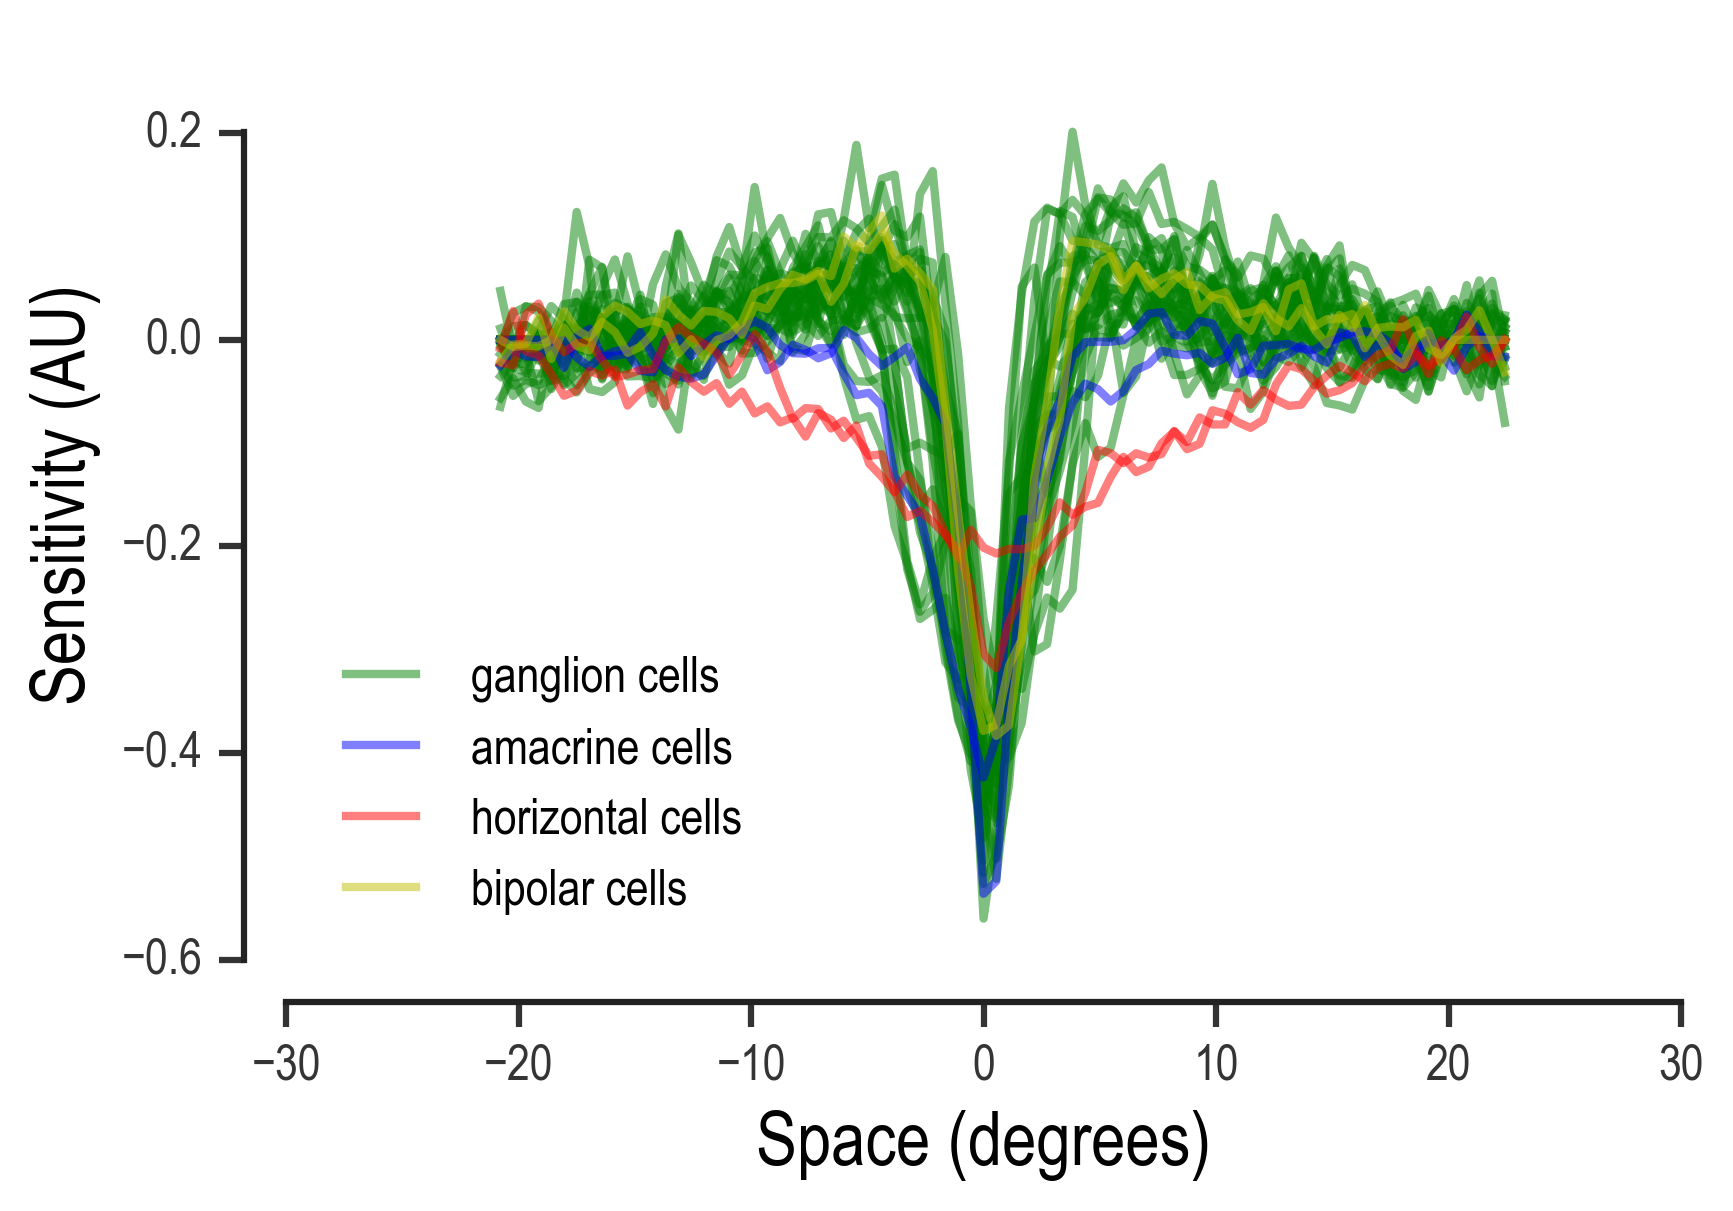

In [41]:
colorscheme = 'gbry'
for idc, c in enumerate(receptive_fields.keys()):
    this_color = colorscheme[idc]
    for idrf, rf in enumerate(receptive_fields[c]):
        if idrf == 0:
            plt.plot(average_spacing, rf, color=this_color, linewidth=2, alpha=0.5, label='%s cells' %c)
        else:
            plt.plot(average_spacing, rf, color=this_color, linewidth=2, alpha=0.5)

plt.ylabel('Sensitivity (AU)', fontsize=18)
plt.xlabel('Space (degrees)', fontsize=18)
plt.legend(frameon=False, loc='lower left', fontsize=12)
adjust_spines(plt.gca())

### Projective fields of amacrine and horizontal cells

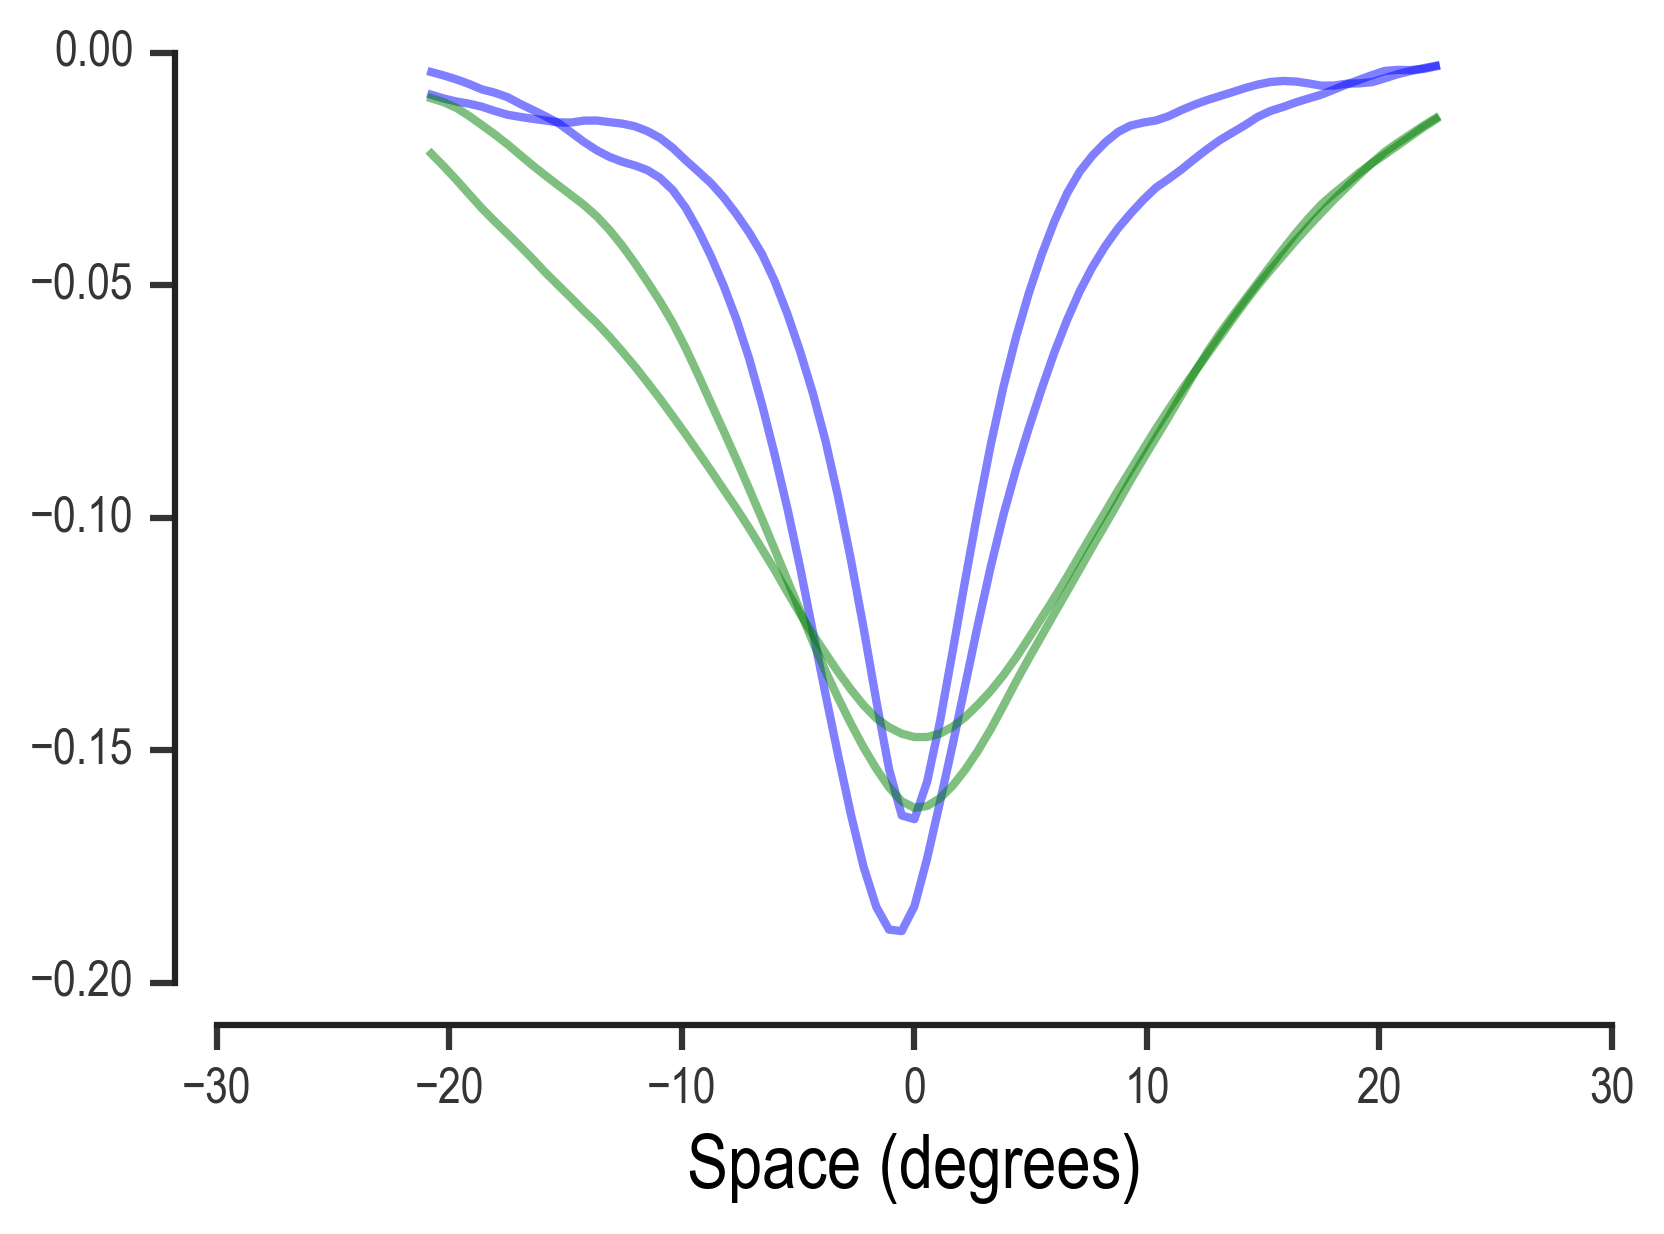

In [119]:
space_constants = {'horizontal': 118./22., 'amacrine': 78./22.}

projective_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['horizontal', 'amacrine']:
        for rf in receptive_fields[celltype]:
            spatial_smoothing = [np.exp(-abs(t)/space_constants[celltype]) for t in np.linspace(np.min(average_spacing),
                                                                                                np.max(average_spacing),
                                                                                                len(average_spacing))]
            proj_field = np.convolve(spatial_smoothing, rf, mode='same')
            proj_field *= np.mean(rf) / np.mean(proj_field)
            projective_fields[celltype].append(proj_field)

colorscheme = 'bg'
for i,celltype in enumerate(sorted(projective_fields.keys())):
    this_color = colorscheme[i]
    for pf in projective_fields[celltype]:
        plt.plot(average_spacing, pf, color=this_color, alpha=0.5, linewidth=2)
plt.xlabel('Space (degrees)', fontsize=18)
adjust_spines(plt.gca())

### Signal

Get the frequency range for average_spacing

In [51]:
freqs = np.linspace(0, 0.5/np.mean(np.diff(average_spacing)), len(np.fft.rfft(average_spacing)))

In [42]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd01A'
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 70 files in directory.


In [46]:
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches01A, spacing=spacing)

Interpolate signal at same resolution and scale as cell measurements

In [605]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt)
signal = func(freqs, *popt)
signal[0] = signal_amps[0]

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


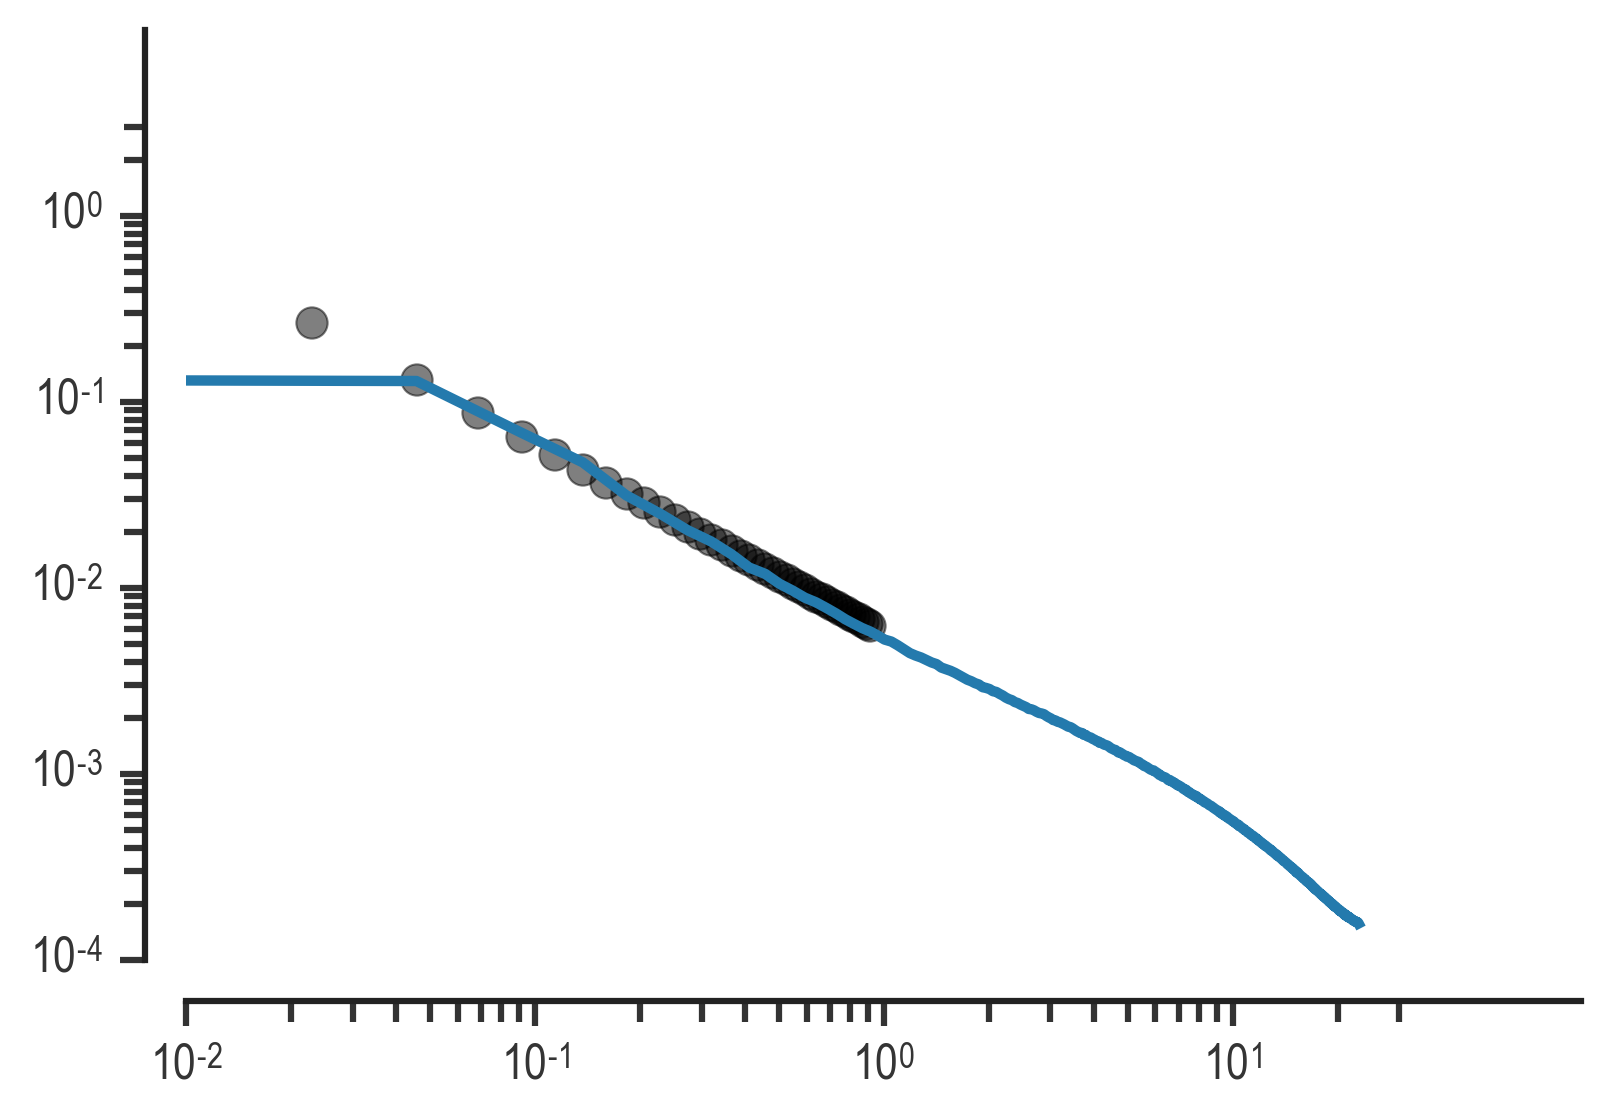

In [606]:
plt.plot(freqs, signal, 'k.', alpha=0.5)
plt.plot(signal_freqs, signal_amps)
plt.xscale('log')
plt.yscale('log')
adjust_spines(plt.gca())

In [607]:
spacing

0.021739130434782608

In [608]:
np.mean(np.diff(average_spacing))

0.54683544303797449

In [86]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0.)

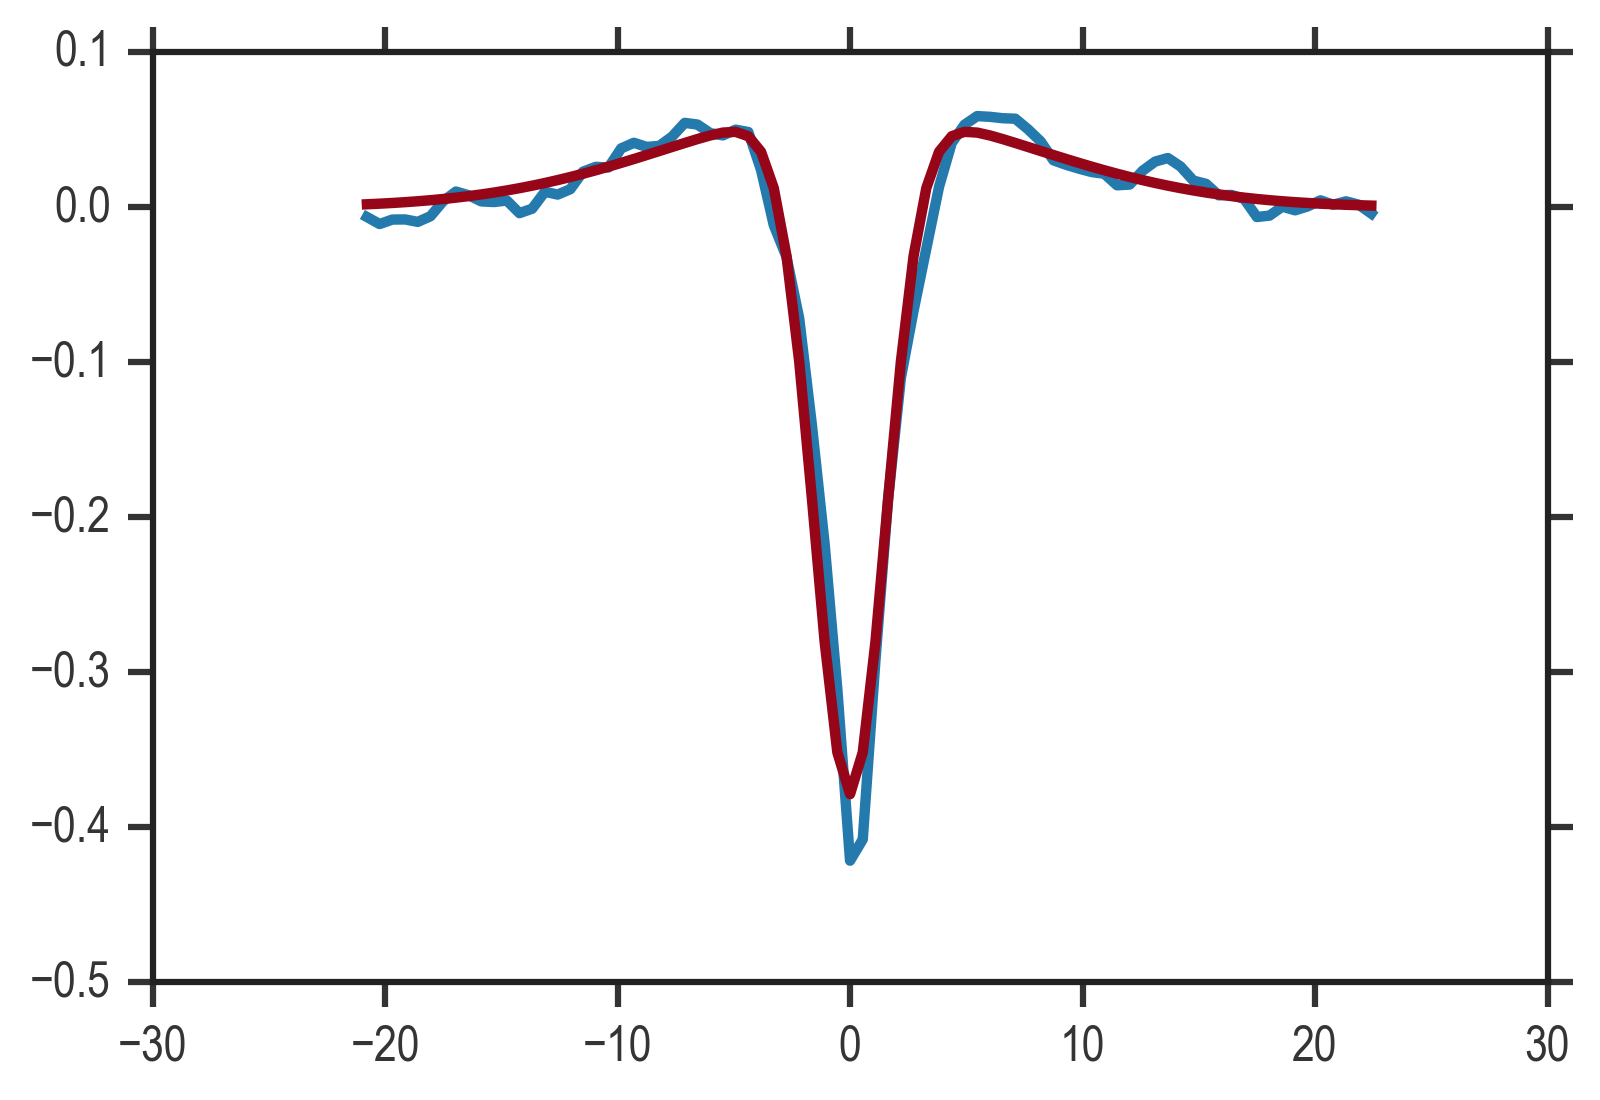

In [87]:
average_ganglion = np.mean(np.stack(receptive_fields['ganglion']), axis=0)
popt, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, average_ganglion)
plt.plot(average_spacing, average_ganglion)
plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt))

Couldn't fit cell 15
Couldn't fit cell 21
Couldn't fit cell 27


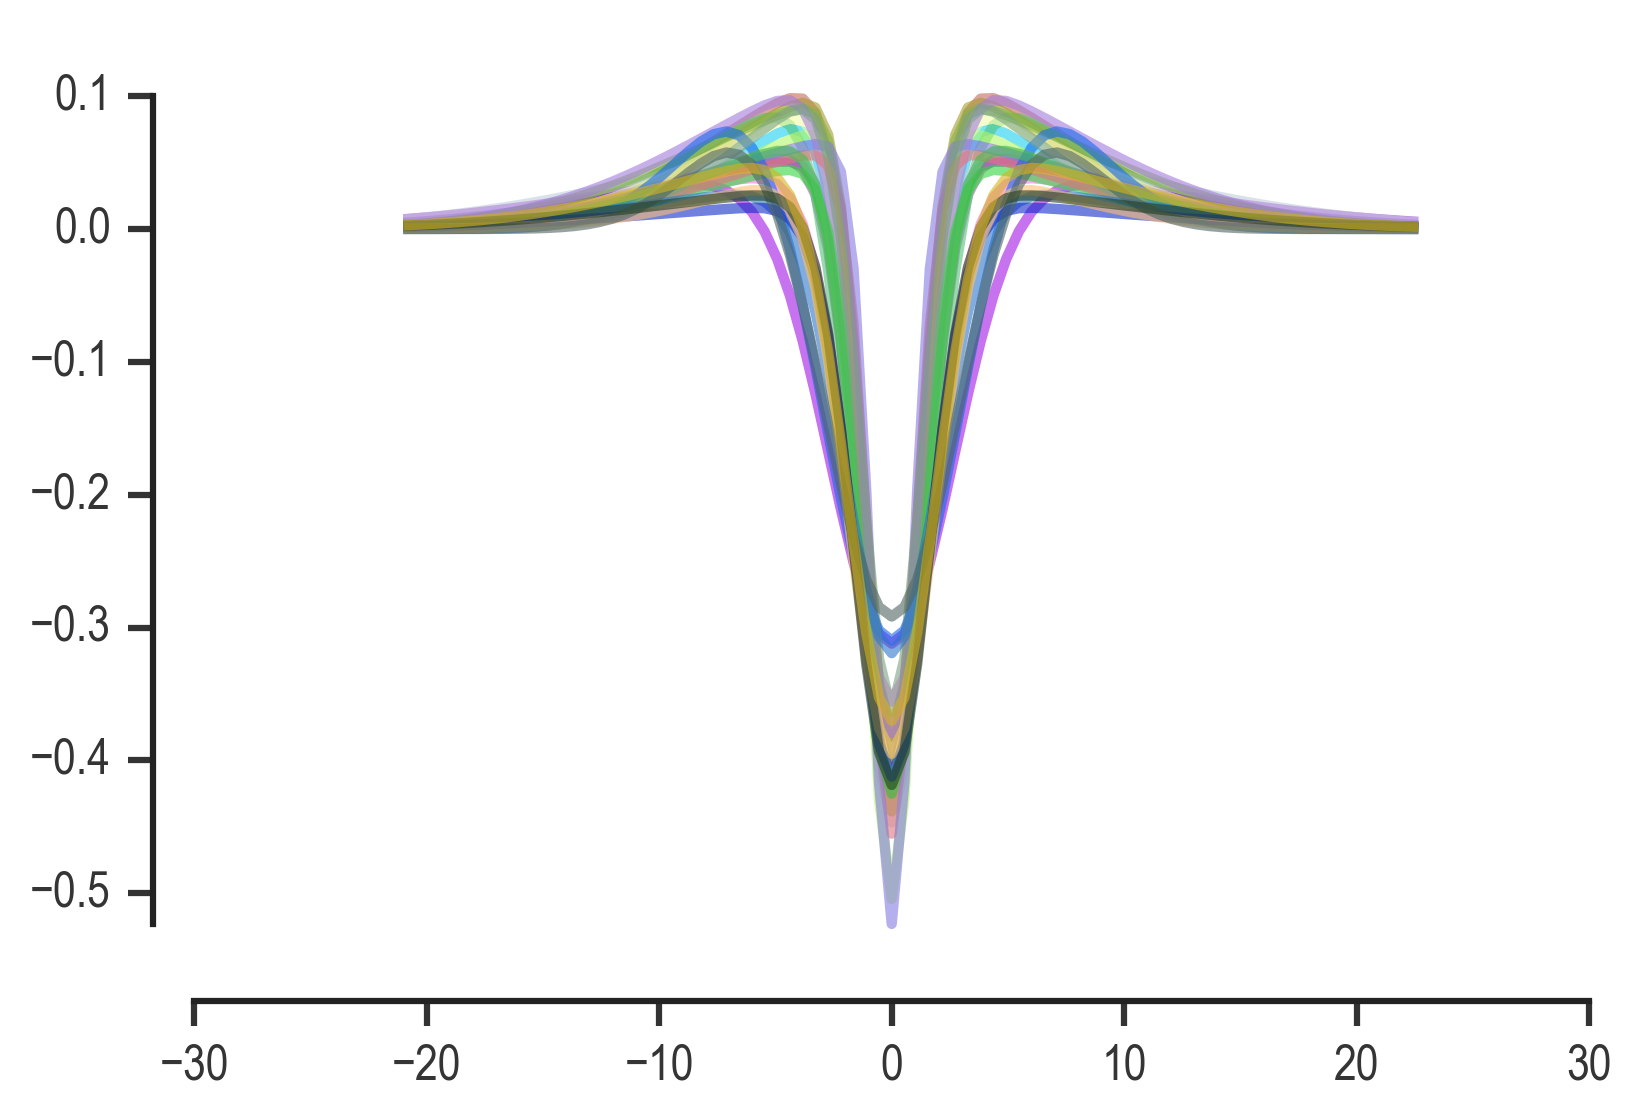

In [93]:
center_widths = []
surround_widths = []
for idg, g in enumerate(receptive_fields['ganglion']):
    try:
        popt_this, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, g, p0=popt)
        center_widths.append(np.min(abs(popt_this[:2])))
        surround_widths.append(np.max(abs(popt_this[:2])))
        plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt_this), color=np.random.rand(3), alpha=0.6)
    except:
        print("Couldn't fit cell %d" %idg)
        
plt.ylim(-.55, .15)
adjust_spines(plt.gca())

In [95]:
np.mean(surround_widths)

7.4899876868915491

In [96]:
np.mean(center_widths)

1.6329005789098545

In [101]:
tuple(np.random.choice(average_spacing, 2))

(1.6405063291139228, 19.139240506329109)

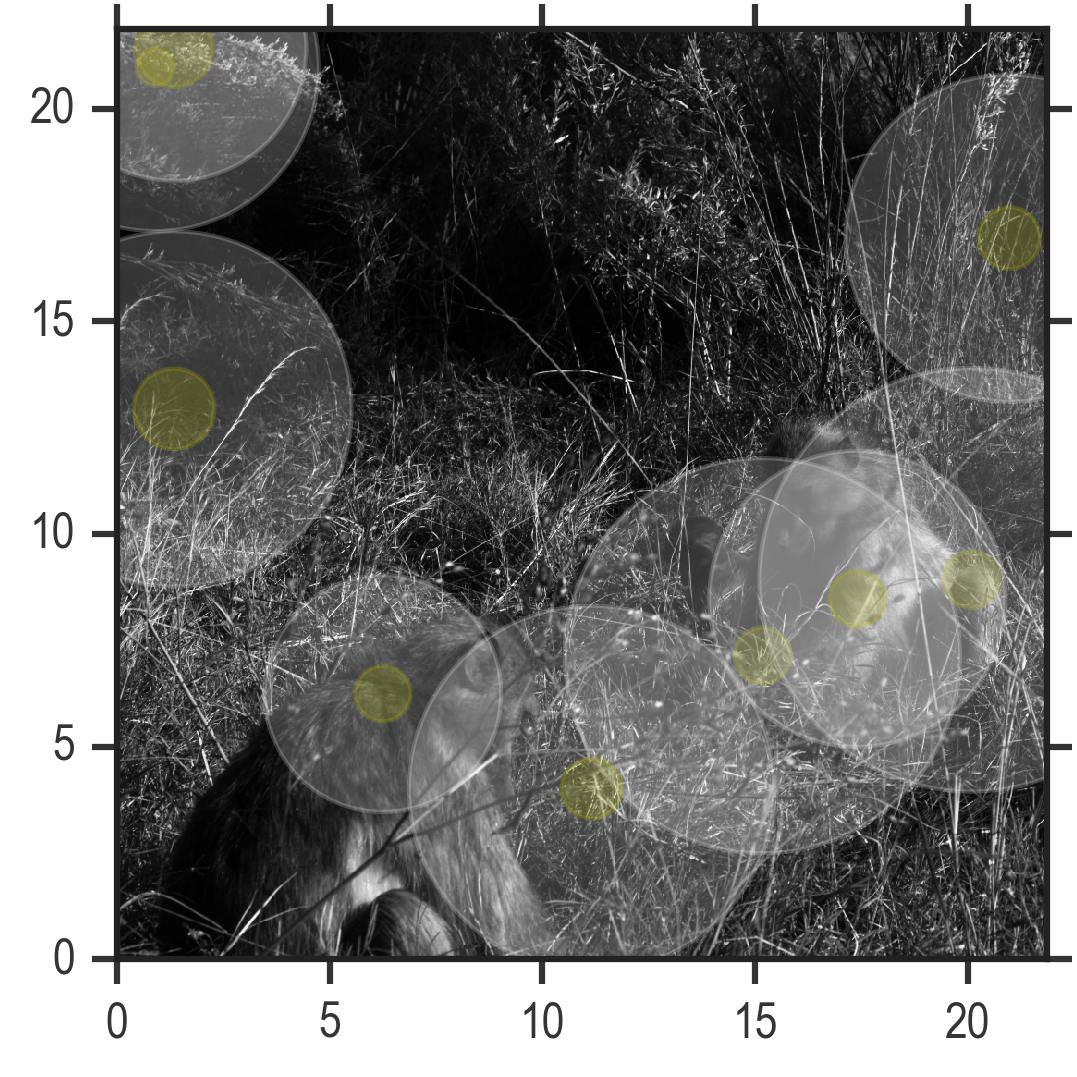

In [112]:
image_id = 15
plt.imshow(patches01A[image_id], extent=[0, spacing*patches01A[image_id].shape[0],
                                         0, spacing*patches01A[image_id].shape[0]])
ax = plt.gca()

center_choices = np.linspace(0, spacing*patches01A[1].shape[0])
for idc, center_diameter in enumerate(center_widths):
    # select a subset
    if idc % 3 == 0:
        center = tuple(np.random.choice(center_choices, 2))
        circle_surround = plt.Circle(center, surround_widths[idc]/2, color='w', alpha=0.2)
        circle_center = plt.Circle(center, center_diameter/2, color='y', alpha=0.2)

        ax.add_artist(circle_surround)
        ax.add_artist(circle_center)

Salamanders have very low resolution eyes!

### Noise

In [279]:
input_noise = np.array([0.12]*len(freqs))
output_noise = np.array([0.35]*len(freqs))

# David's ganglion cells on heatmap

In [157]:
from os.path import expanduser
import pyret.filtertools as ft
from sklearn.decomposition import PCA
from surround.modeling import gaussian

In [199]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [232]:
c.shape

(101, 96)

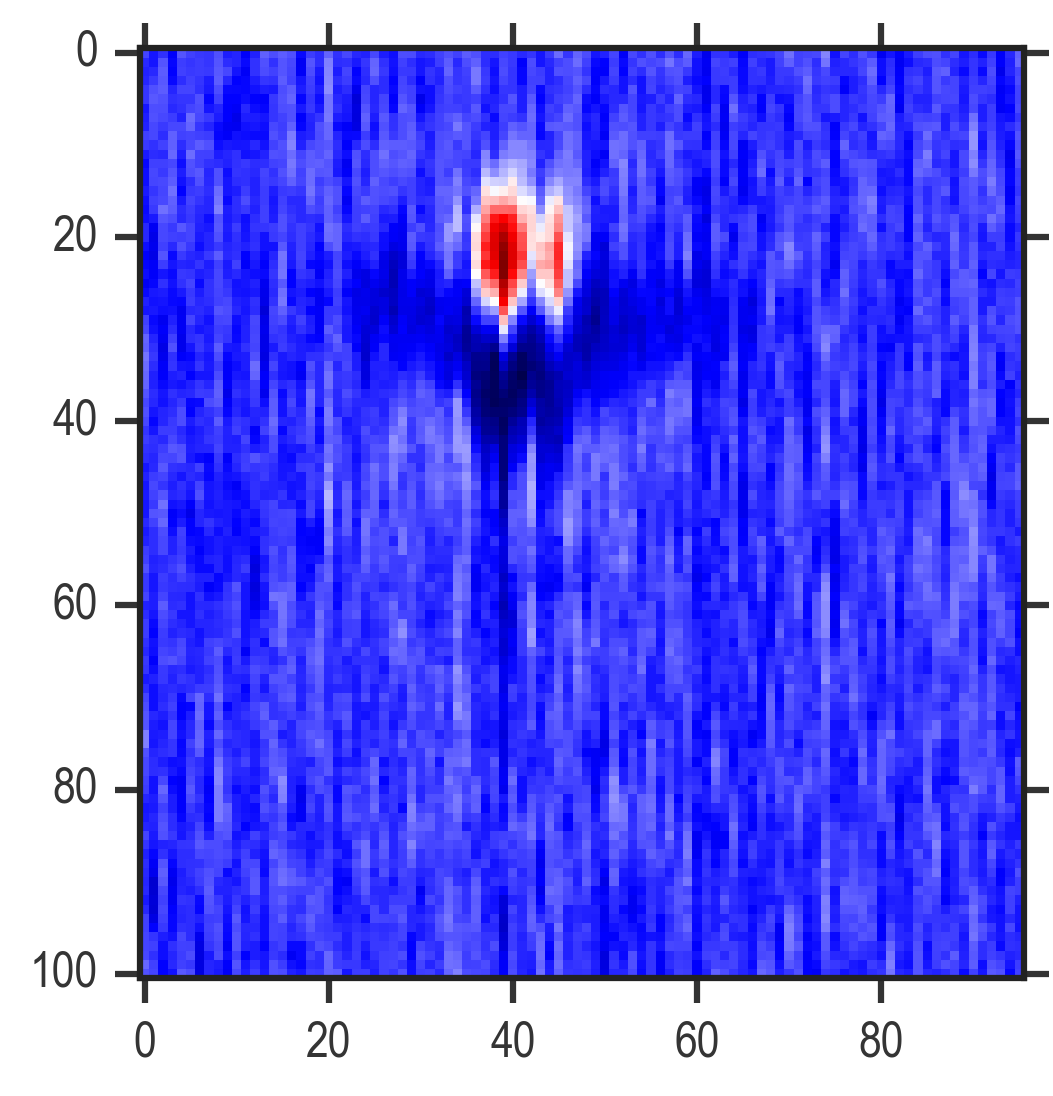

In [239]:
plt.imshow(c, cmap='seismic')

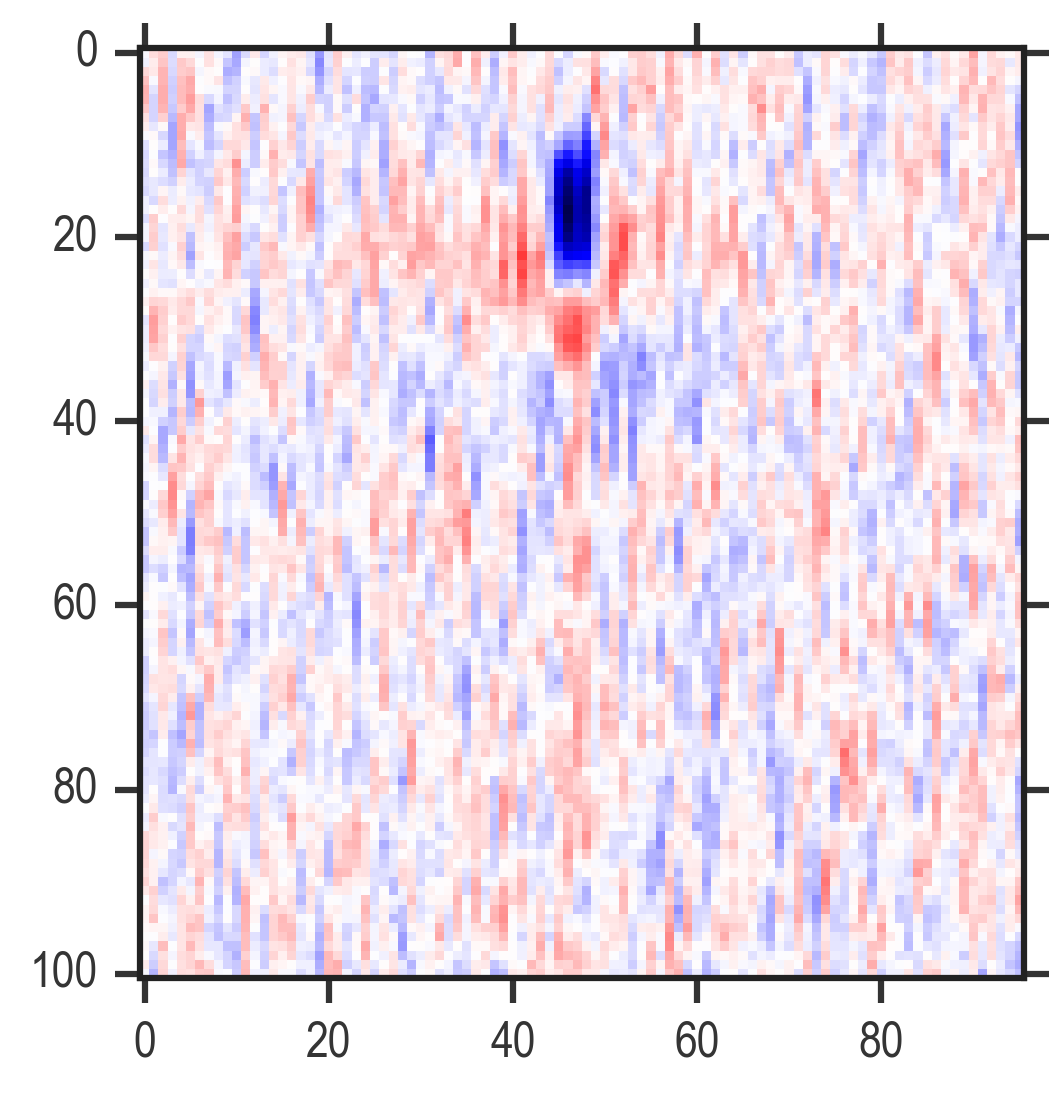

In [359]:
plt.imshow(ganglion_rfs['medium_off_adapting'][0], cmap='seismic')
plt.clim([-np.max(abs(ganglion_rfs['medium_off_adapting'][0])), np.max(abs(ganglion_rfs['medium_off_adapting'][0]))])

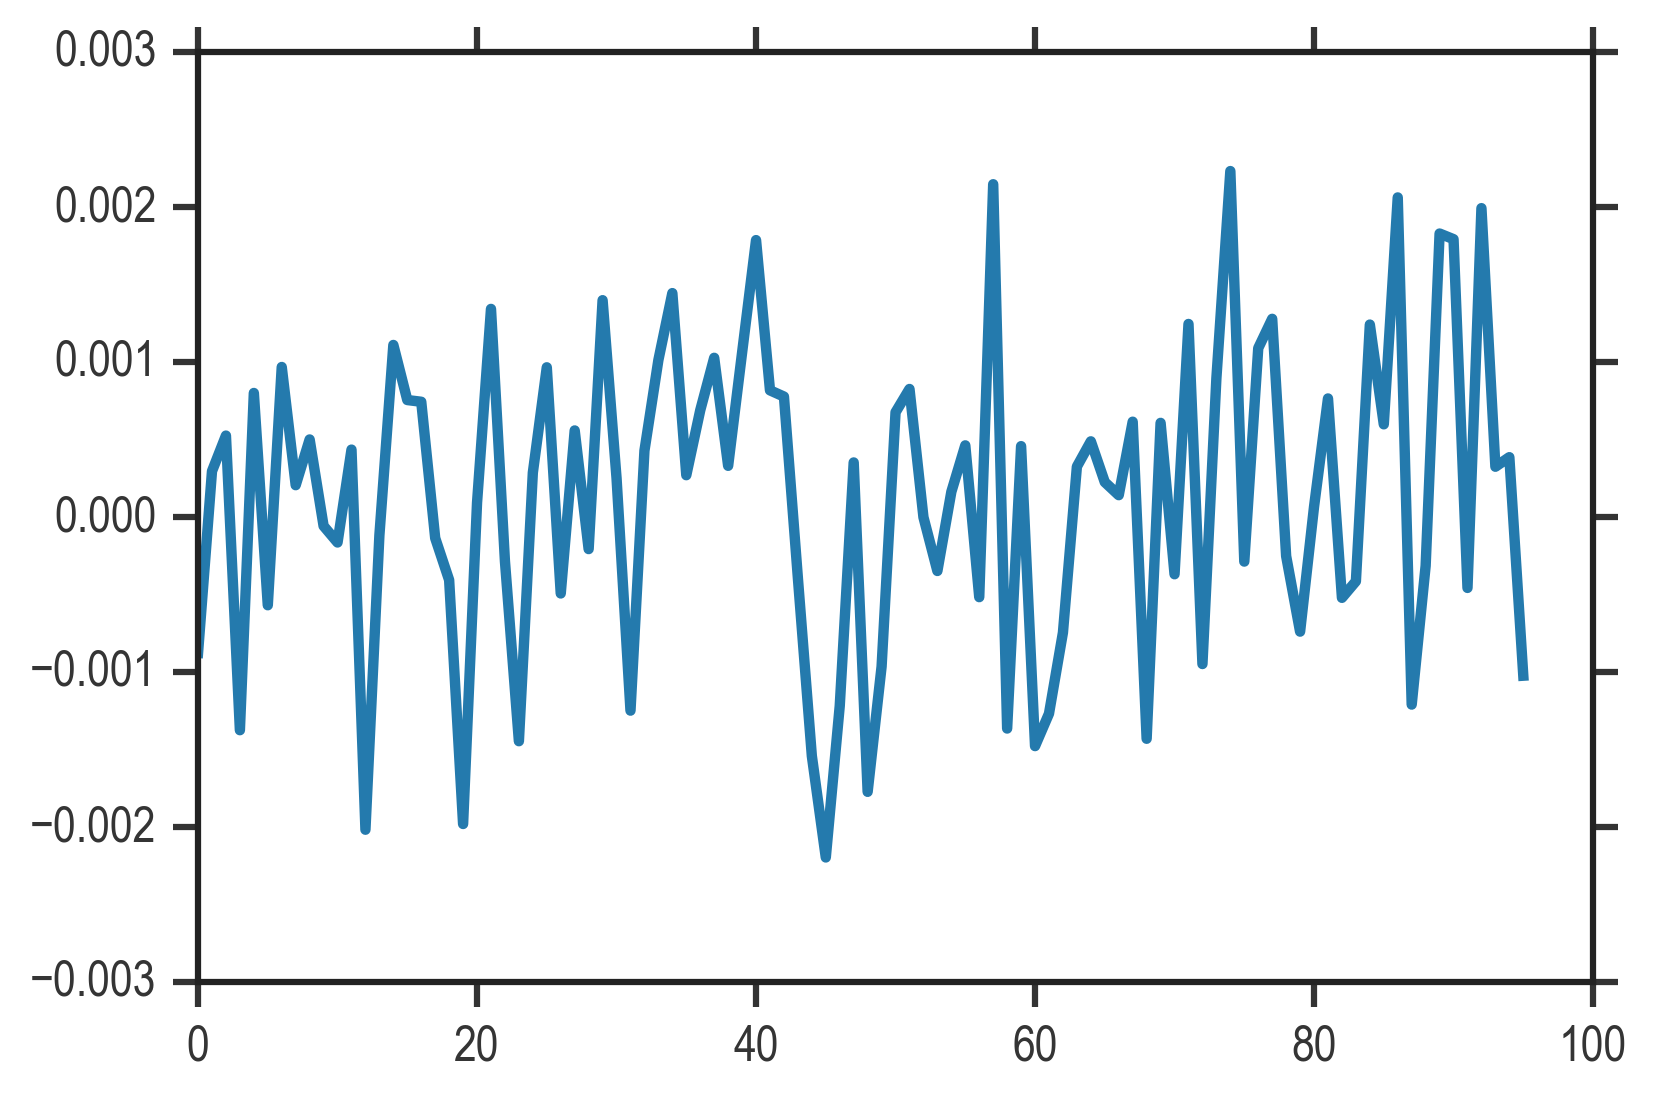

In [357]:
plt.plot(np.mean(ganglion_rfs['medium_off_adapting'][0], axis=0))

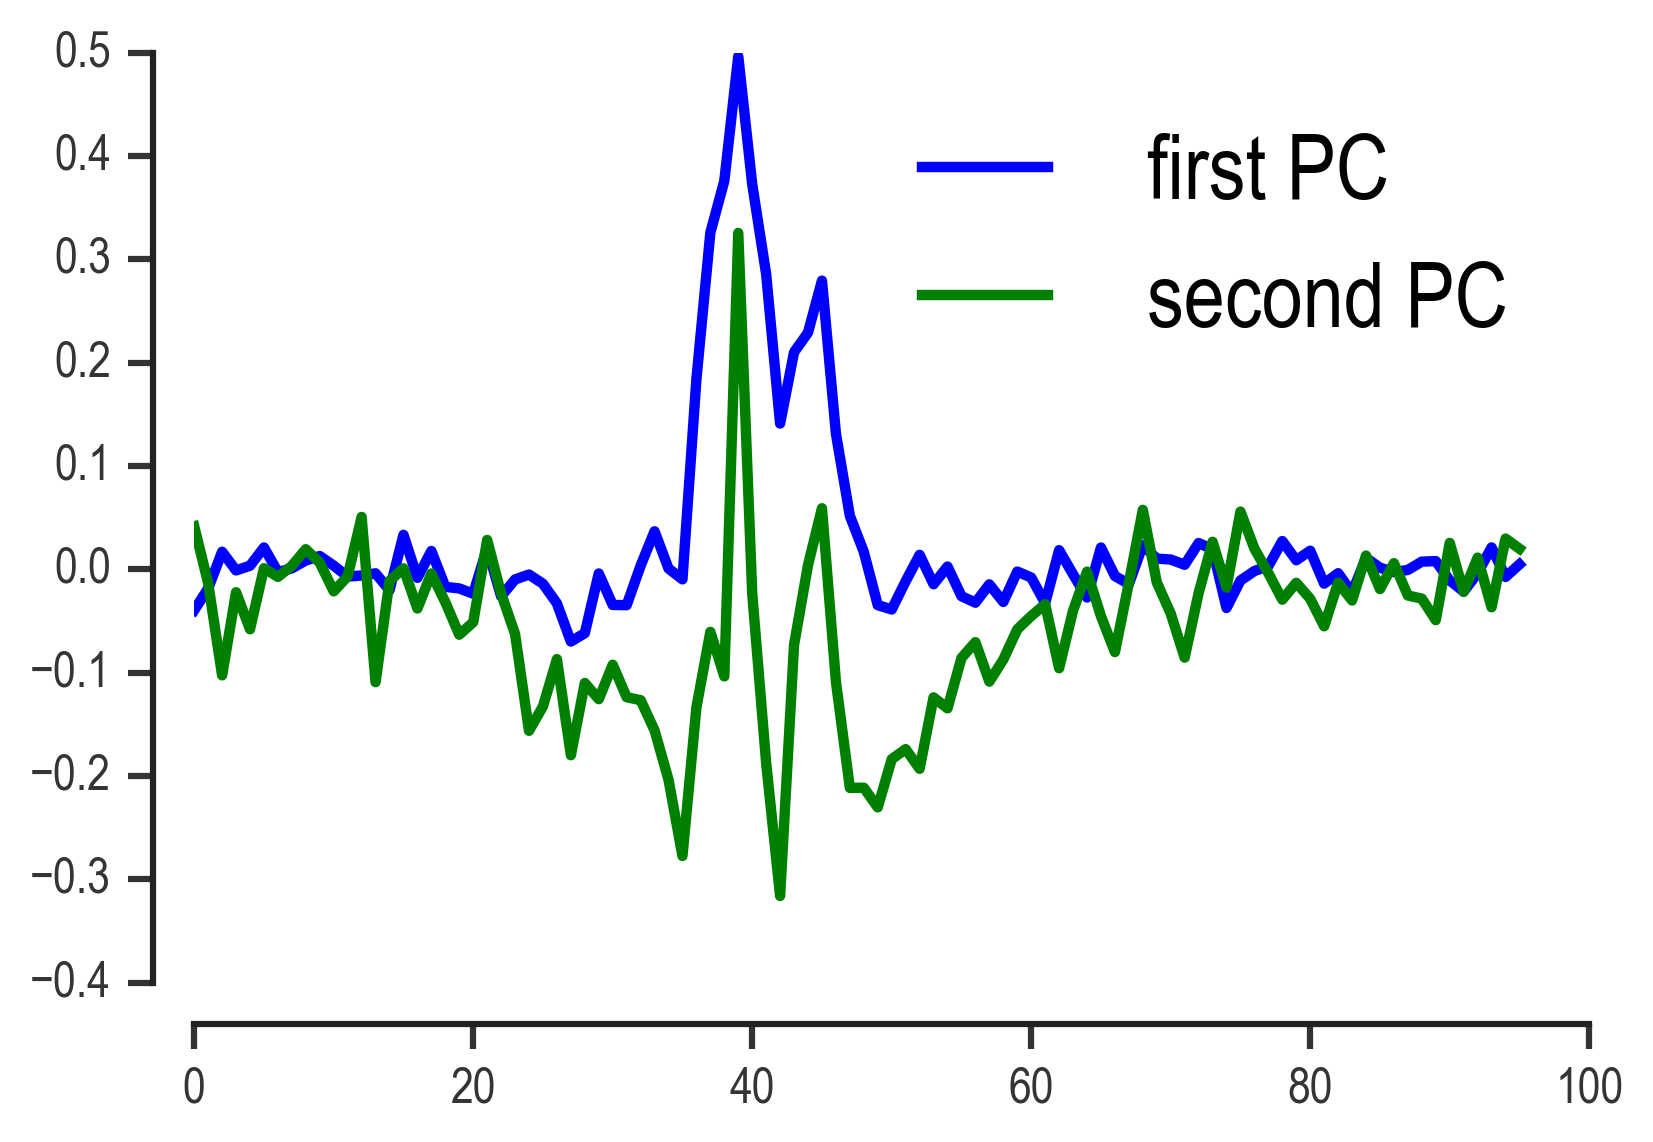

In [247]:
plt.plot(pca.components_[0], 'b', label='first PC')
plt.plot(pca.components_[1], 'g', label='second PC')
plt.legend(frameon=False)
adjust_spines(plt.gca())

In [248]:
ganglion_1d_rfs = collections.defaultdict(list)
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        space      = get_space(g_pca, spatialDelta, micronsPerDeg)

        ganglion_1d_rfs[celltype].append((space, sign_of_pc * g_pca))

In [249]:
ganglion_aligned_rfs = collections.defaultdict(list)
for celltype in ganglion_1d_rfs.keys():
    for space, rf in ganglion_1d_rfs[celltype]:
        rf_interp = interp1d(space, rf, kind='slinear', bounds_error=False, fill_value=[0])
        ganglion_aligned_rfs[celltype].append(rf_interp(average_spacing))

In [250]:
def rf_express(horz_weight, center_weight, center_width=np.mean(center_widths), return_space=False):
    horz_weight = np.min([1.0, abs(horz_weight)])
    ama_weight = 1.0 - horz_weight
    center_weight = np.min([1.0, abs(center_weight)])
    surround_weight = 1.0 - center_weight
    
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround
    
    if return_space:
        return space, rf
    else:
        return rf

In [251]:
from tqdm import tqdm

In [253]:
fits = collections.defaultdict(list)
errors = collections.defaultdict(list)
for celltype in ganglion_aligned_rfs.keys():
    popts = []
    absolute_errors = []
    print('Fitting ganglion celltype %s.' %celltype)
    for i,rf in tqdm(enumerate(ganglion_aligned_rfs[celltype])):
        def model_error_to_ganglion_cells(weights, valid_space=average_spacing, mean_ganglion=rf):
            horz_weight, center_weight = weights
            space, rf = rf_express(horz_weight, center_weight, return_space=True)
            model_rf = interp1d(space, -rf, kind='slinear', bounds_error=False, fill_value=[0]) # negative since we have OFF cells
            normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))
            return sum(abs(normalized_model_rf - (mean_ganglion-np.mean(mean_ganglion))))

        popt = minimize(model_error_to_ganglion_cells, np.array([0.8,0.9]))

        # truncate params between 0 and 1
        x = np.where(popt.x < 0, 0, popt.x)
        x = np.where(x > 1, 1, x)
        
        popts.append(x)
        absolute_errors.append(popt.fun)

    fits[celltype] = np.stack(popts)
    errors[celltype] = np.stack(absolute_errors)

Fitting ganglion celltype medium_off_adapting.
Fitting ganglion celltype slow_off.


Fitting ganglion celltype fast_off_adapting.


Fitting ganglion celltype fast_off_sensitizing.


Fitting ganglion celltype fast_on.

### Load heatmap

In [254]:
import h5py

In [255]:
with h5py.File('info_grid_search.h5', 'r') as f:
    info_color_map = np.array(f['info_colormap'])
    center_weights = np.array(f['center_weight_xaxis'])
    horz_weights = np.array(f['horz_weight_yaxis'])

In [256]:
celltype

'fast_on'

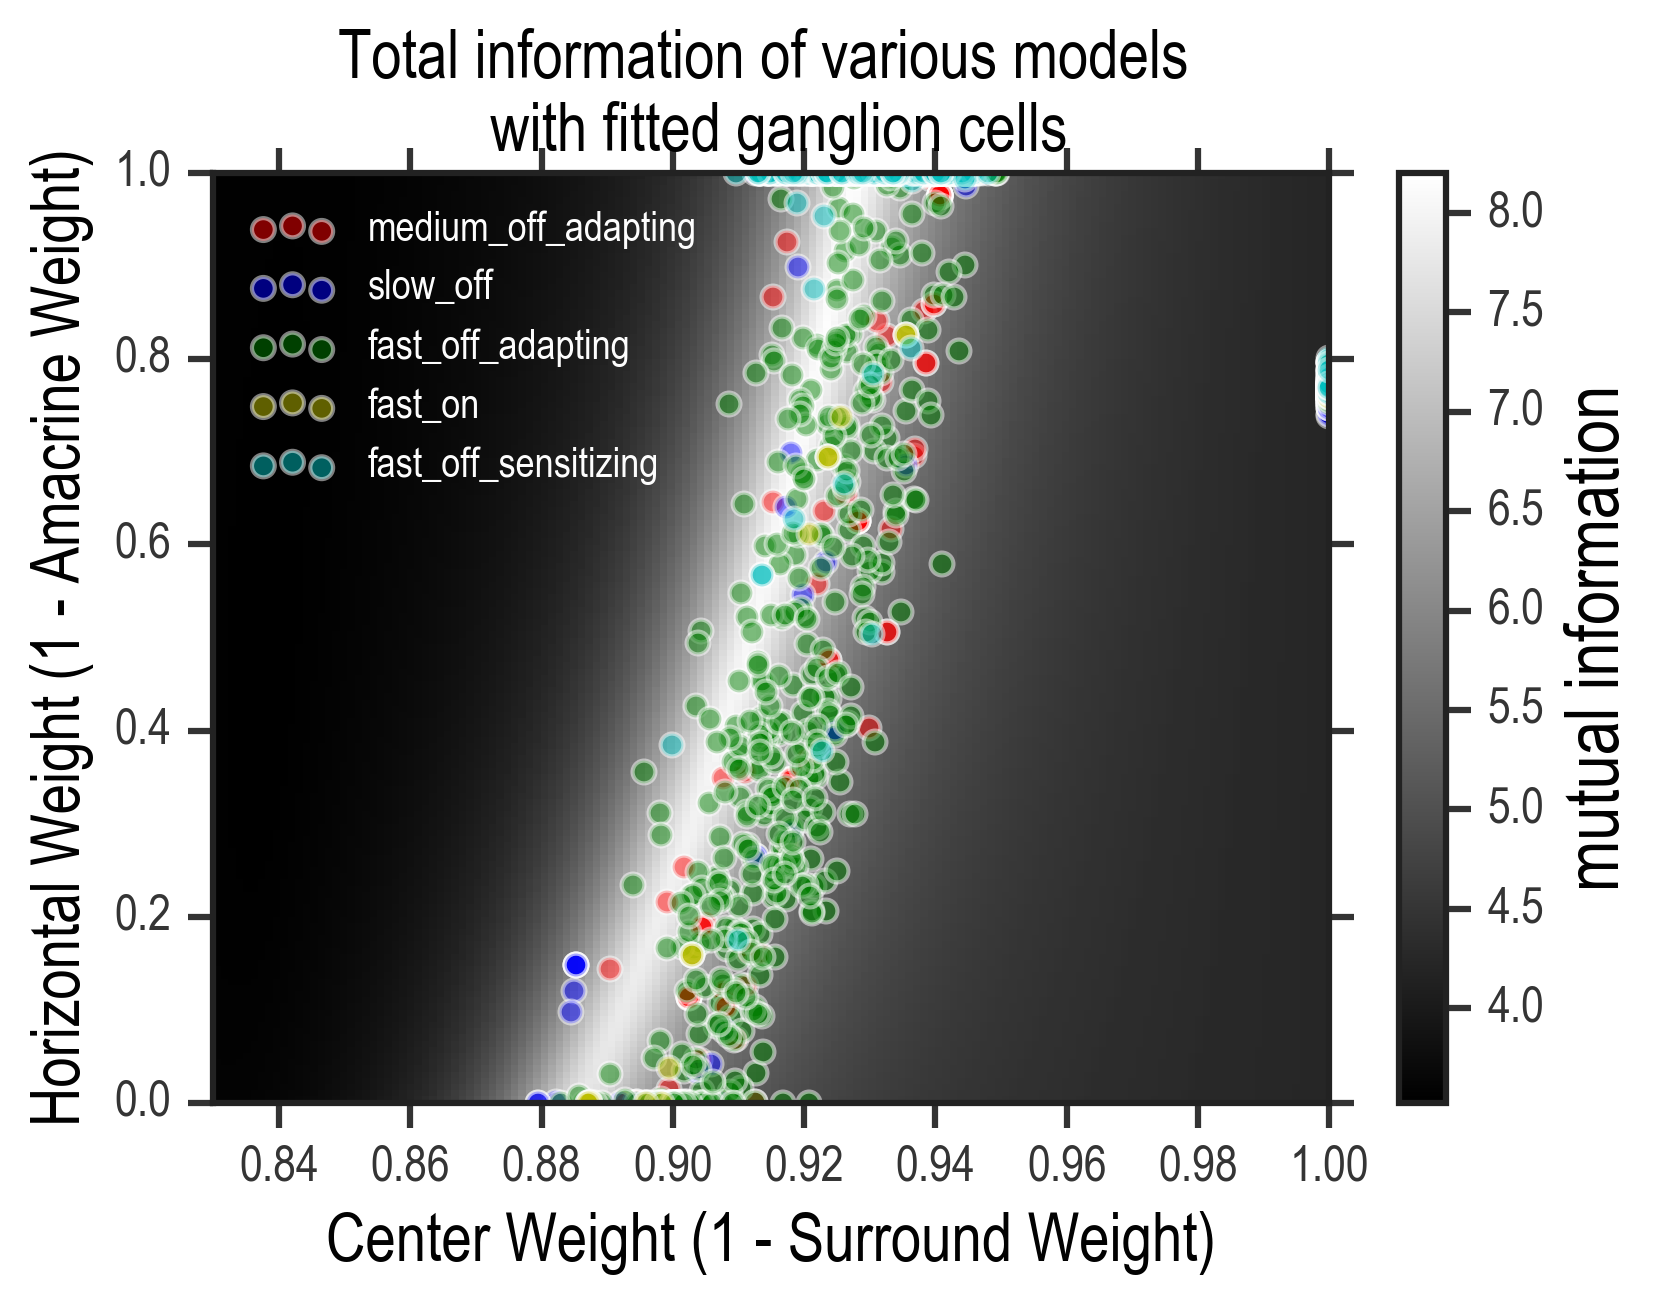

In [262]:
plt.imshow(info_color_map, extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
cbar = plt.colorbar()
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('mutual information', fontsize=18)

colorscheme = 'rbgyc'
for c,celltype in enumerate(fits.keys()):
    plt.scatter(fits[celltype][:,1], fits[celltype][:,0], c=colorscheme[c], edgecolor='w', s=30, 
            alpha=0.5, label=celltype)
    
# plt.xlim([0,1])
l = plt.legend(loc='upper left', frameon=False, fontsize=10)
for text in l.get_texts():
    text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])
plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

In [268]:
ncells = 0
for celltype in ganglion_aligned_rfs.keys():
    print(len(ganglion_aligned_rfs[celltype]))
    ncells += len(ganglion_aligned_rfs[celltype])
    

321
253
772
249
126


In [344]:
fits.keys()

dict_keys(['medium_off_adapting', 'slow_off', 'fast_off_adapting', 'fast_on', 'fast_off_sensitizing'])

In [345]:
fits['medium_off_adapting'][0]

array([ 0.82452455,  0.93259798])

In [351]:
np.var(rf_express(*fits['medium_off_adapting'][0]))

0.0001277616419981766

In [266]:
ncells

1721

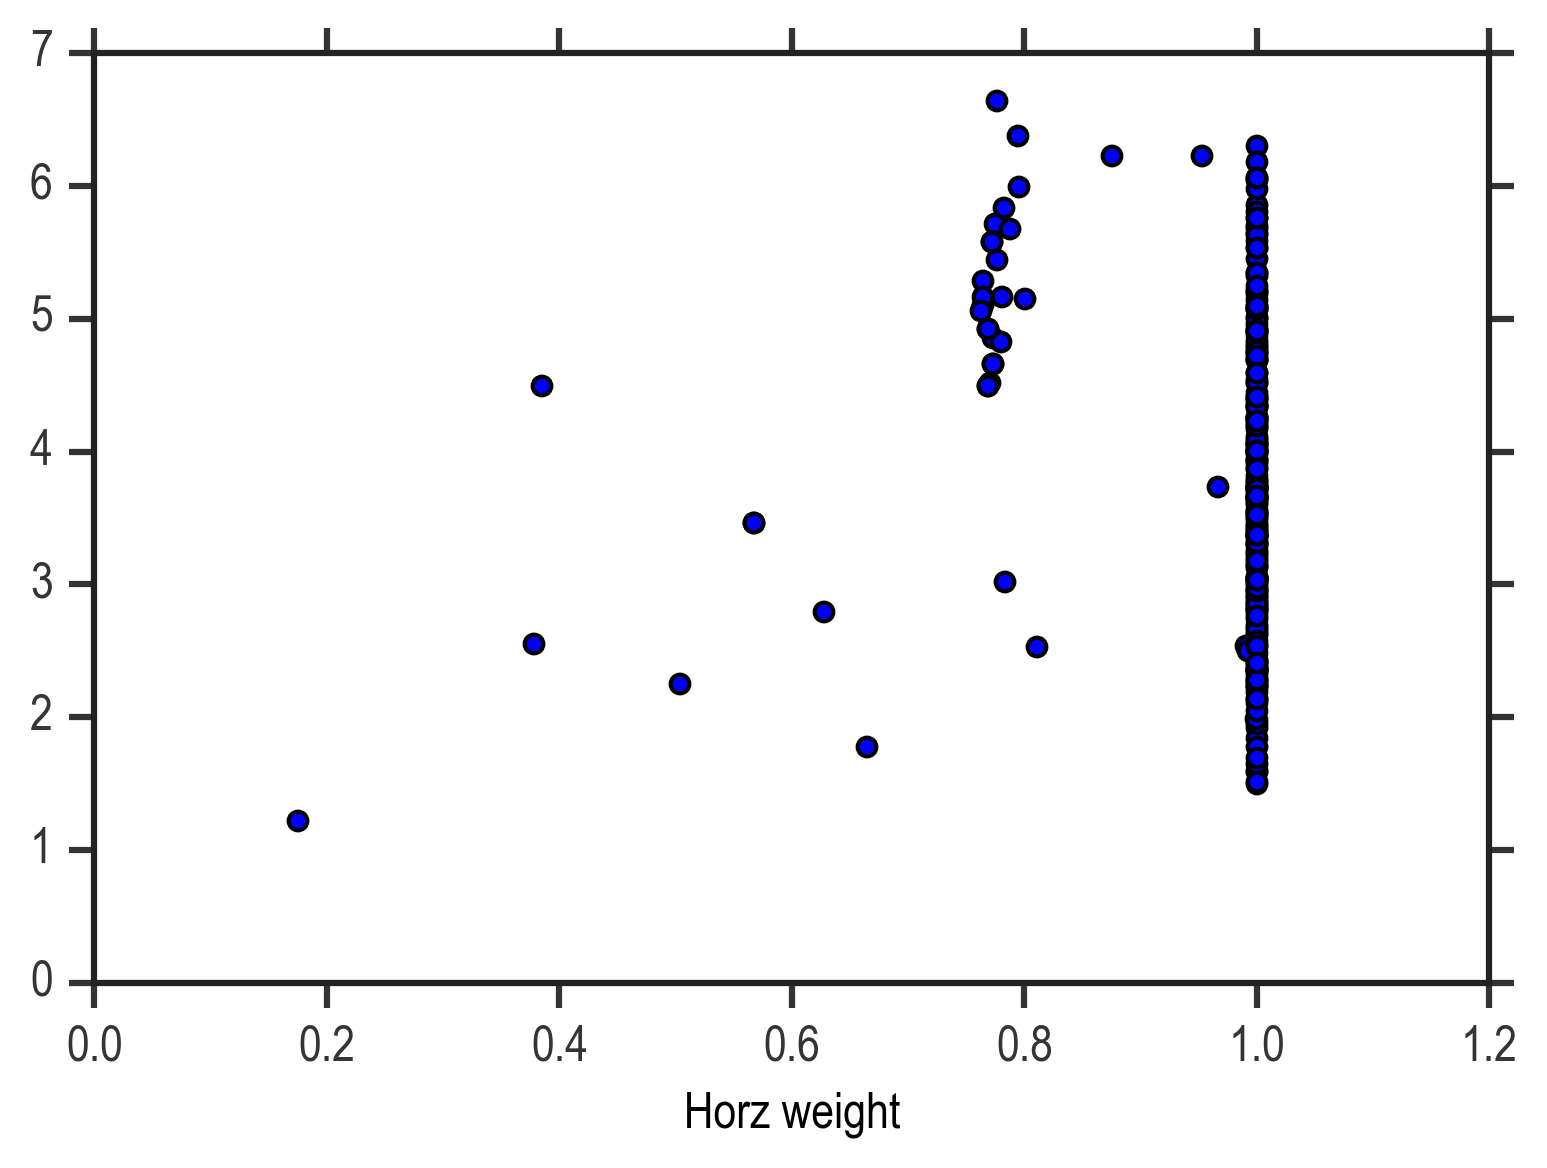

In [273]:
plt.scatter(fits['fast_off_sensitizing'][:,0], errors['fast_off_sensitizing'])
plt.xlabel('Horz weight')

Save RF fits

In [274]:
with h5py.File('ganglion_fits.h5', 'w') as f:
    for celltype in fits.keys():
        f.create_dataset(celltype, data=fits[celltype])
        f.create_dataset('%s_errors' %celltype, data=errors[celltype])

### Analytically compute horz weight and center weight

In [362]:
center_width = np.mean(center_widths)
print(center_width)

1.63290057891


In [378]:
# Get original data
horz_pfs = get_horizontal_projective_field()
ama_pfs  = get_amacrine_projective_field()

# get means of the projective fields
space_h, horz_pf, horz_sem = get_mean(horz_pfs)
space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

# interpolate horz and ama to get a unified space; mode='valid'
horz_interp = interp1d(space_h, horz_pf, kind='linear', bounds_error=False, fill_value='extrapolate')
ama_interp  = interp1d(space_a, ama_pf, kind='linear', bounds_error=False, fill_value='extrapolate')

# project interpolations on unified space
horz_pf     = horz_interp(average_spacing)
ama_pf      = ama_interp(average_spacing)

# make center
center = gaussian(x=average_spacing, sigma=center_width, mu=0.) # gaussian

(-0.2, 0.1)

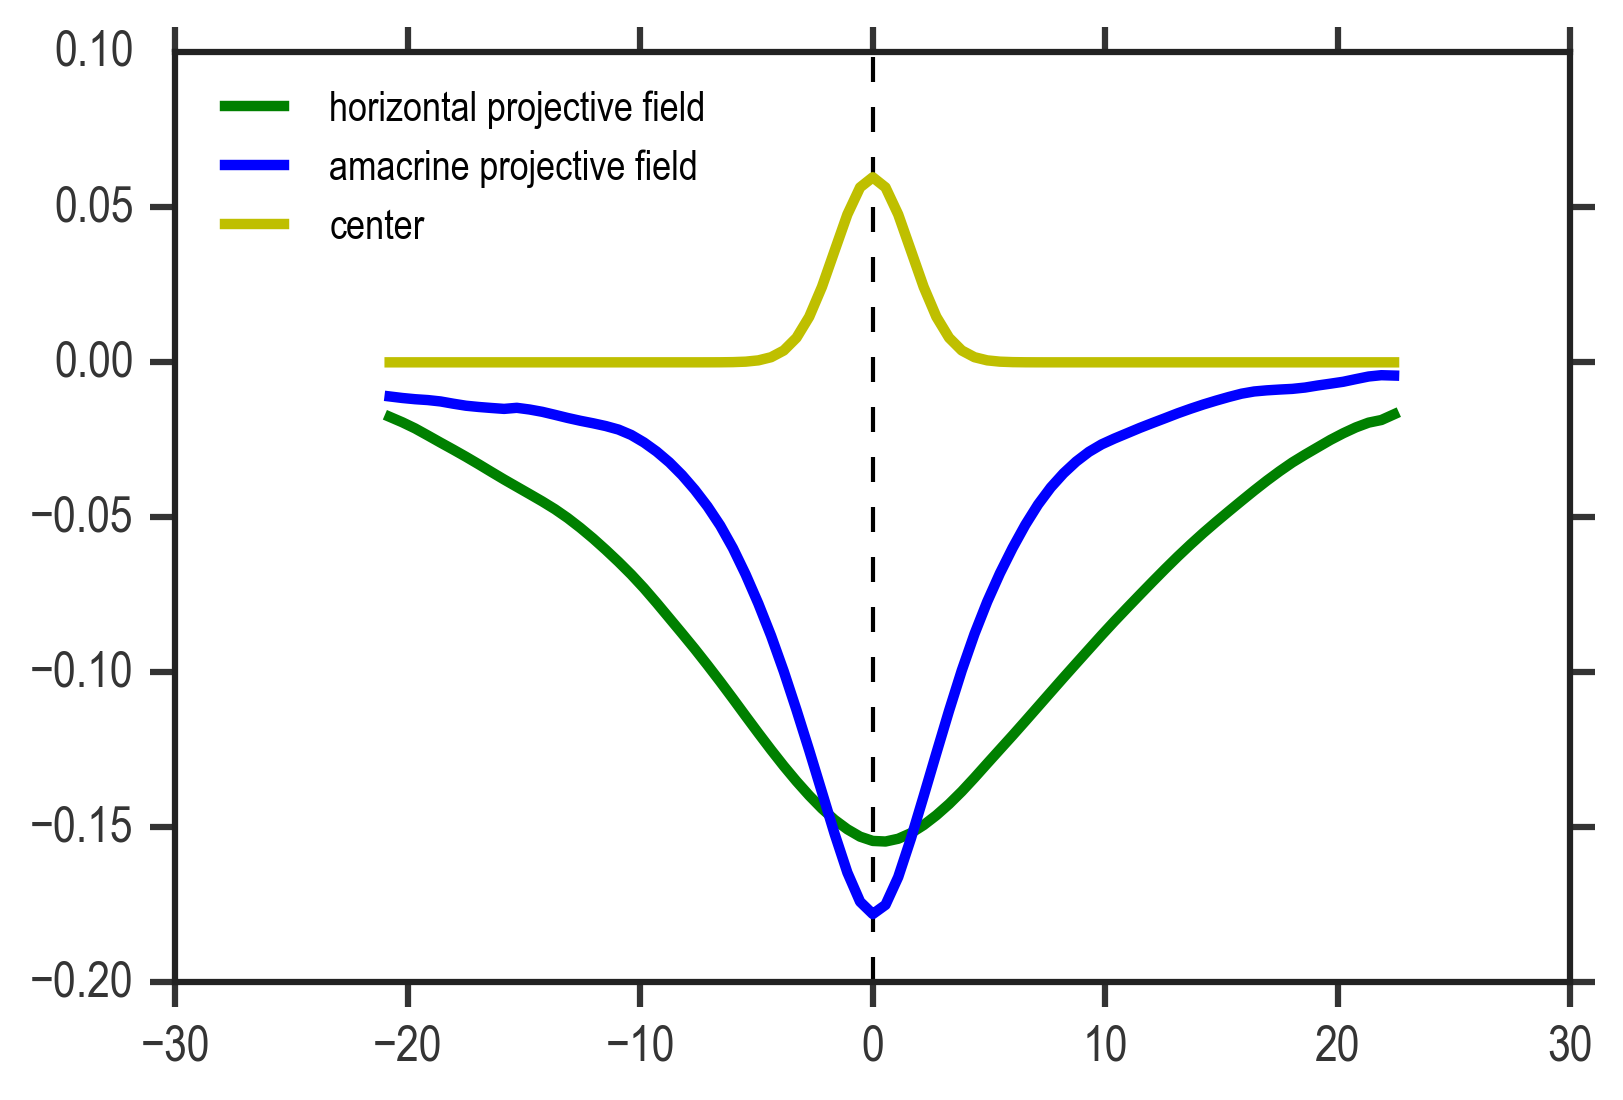

In [380]:
plt.plot(average_spacing, horz_pf, 'g', label='horizontal projective field')
plt.plot(average_spacing, ama_pf, 'b', label='amacrine projective field')
plt.plot(average_spacing, center, 'y', label='center')
plt.legend(loc='upper left', frameon=False, fontsize=10)
plt.vlines(0, -.2, 0.1, linestyle='--', linewidth=1)
plt.ylim(-.2, .1)

In [395]:
def rf_cached(horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1 - center_weight)*(horz_weight*horz_pf + (1 - horz_weight)*ama_pf)

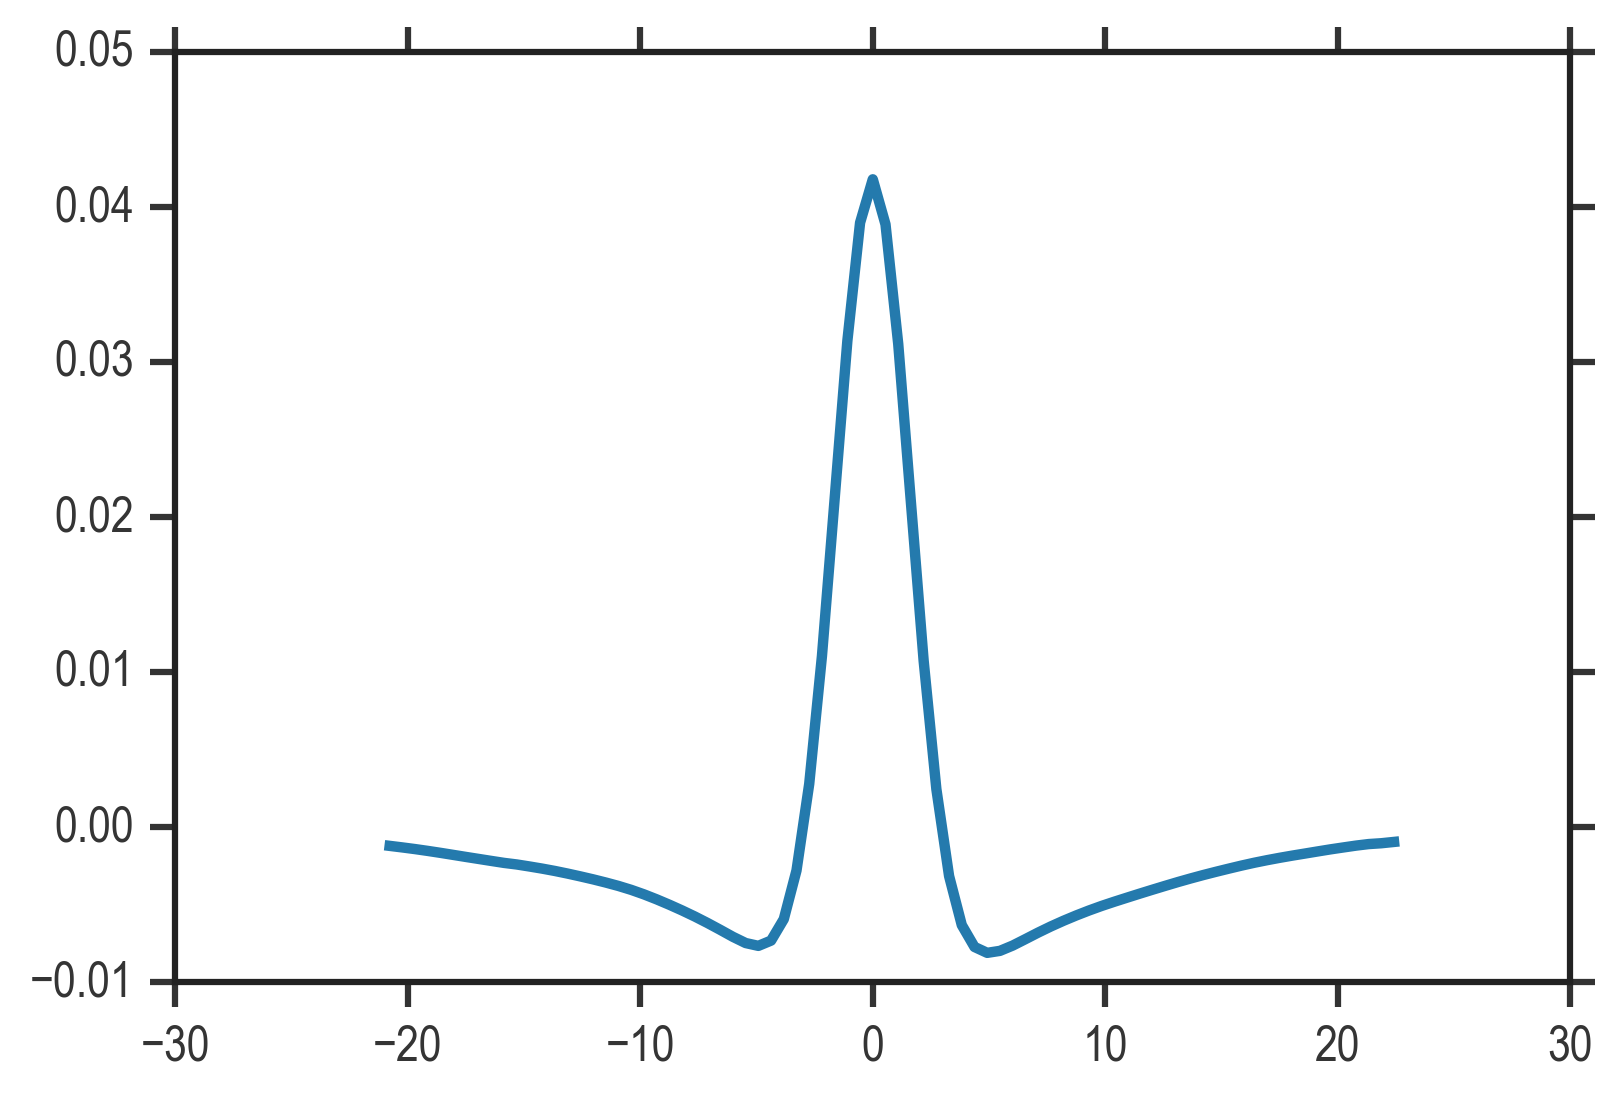

In [396]:
plt.plot(average_spacing, rf_cached(0.6, 0.92))

In [ ]:
def model_error_to_ganglion_cells(weights, valid_space=average_spacing, mean_ganglion=rf):
    horz_weight, center_weight = weights
    space, rf = rf_express(horz_weight, center_weight, return_space=True)
    model_rf = interp1d(space, -rf, kind='slinear', bounds_error=False, fill_value=[0]) # negative since we have OFF cells
    normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))
    return sum(abs(normalized_model_rf - (mean_ganglion-np.mean(mean_ganglion))))

In [437]:
this_ganglion = ganglion_aligned_rfs['fast_on'][0]
def model_error_to_ganglion_cells(weights, valid_space=average_spacing, mean_ganglion=this_ganglion):
    horz_weight, center_weight = weights
    space, rf = rf_express(horz_weight, center_weight, return_space=True)
    model_rf = interp1d(space, -rf, kind='slinear', bounds_error=False, fill_value=[0]) # negative since we have OFF cells
    normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))
    return sum(abs(normalized_model_rf - (mean_ganglion-np.mean(mean_ganglion))))

popt = minimize(model_error_to_ganglion_cells, np.array([0.8,0.9]))

# truncate params between 0 and 1
x = np.where(popt.x < 0, 0, popt.x)
x = np.where(x > 1, 1, x)

space_model, model = rf_express(x[0], x[1], return_space=True)
model_rf = interp1d(space_model, -model, kind='slinear', bounds_error=False, fill_value=[0]) # negative since we have OFF cells
normalized_model_rf = np.max(abs(this_ganglion))*model_rf(average_spacing)/np.max(abs(model_rf(average_spacing)))

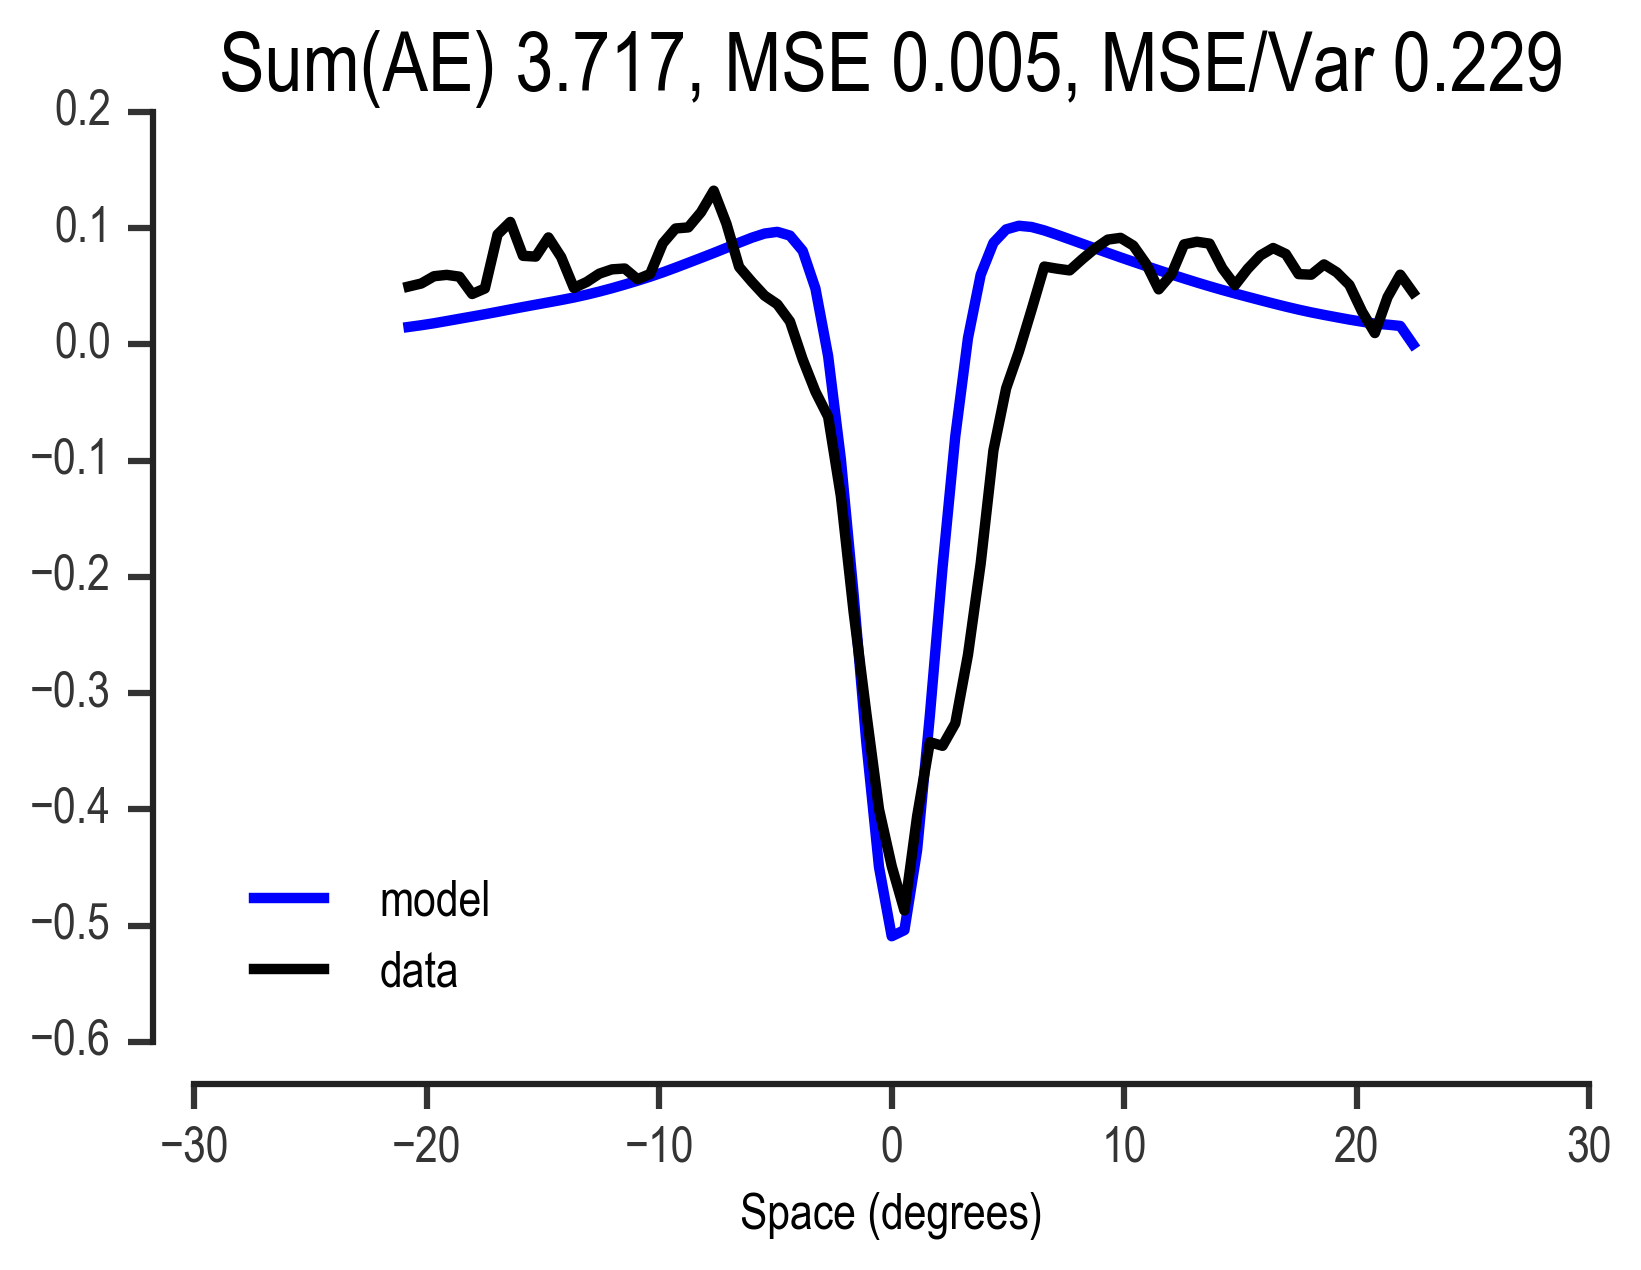

In [438]:
plt.plot(average_spacing, normalized_model_rf, 'b', label='model')
plt.plot(average_spacing, this_ganglion-np.mean(this_ganglion), 'k', label='data')
mse = np.mean((normalized_model_rf - (this_ganglion-np.mean(this_ganglion)))**2)
plt.title('Sum(AE) %0.3f, MSE %0.3f, MSE/Var %0.3f' %(popt.fun, mse, mse/np.var(this_ganglion)))
plt.xlabel('Space (degrees)')
plt.legend(loc='lower left', frameon=False, fontsize=12)
adjust_spines(plt.gca())

In [439]:
popt

      fun: 3.7167531518869614
 hess_inv: array([[ 0.01210386, -0.01557392],
       [-0.01557392,  0.0775576 ]])
      jac: array([ 0.        ,  0.16548952])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 648
      nit: 6
     njev: 159
   status: 2
  success: False
        x: array([ 1.00170305,  0.92788302])

In [450]:
this_ganglion = ganglion_aligned_rfs['fast_on'][0]
def model_error_to_ganglion_cells(weights, rf=this_ganglion):
    horz_weight, center_weight = weights
    model_rf = -rf_cached(horz_weight, center_weight)
    normalized_model_rf = np.max(abs(rf))*model_rf/np.max(abs(model_rf))
    return sum(abs(normalized_model_rf - (rf-np.mean(rf))))

popt = minimize(model_error_to_ganglion_cells, np.array([0.8,0.9]))

# truncate params between 0 and 1
x = np.where(popt.x < 0, 0, popt.x)
x = np.where(x > 1, 1, x)

model_rf = -rf_cached(x[0], x[1])
normalized_model_rf = np.max(abs(this_ganglion))*model_rf/np.max(abs(model_rf))

In [451]:
popt

      fun: 3.926381745144182
 hess_inv: array([[ 0.61176372,  0.05973166],
       [ 0.05973166,  0.00829943]])
      jac: array([-0.05039415,  3.22664928])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 488
      nit: 4
     njev: 119
   status: 2
  success: False
        x: array([ 1.        ,  0.92942001])

In [452]:
model_error_to_ganglion_cells([1.0017, 0.927883])

3.9213854683145941

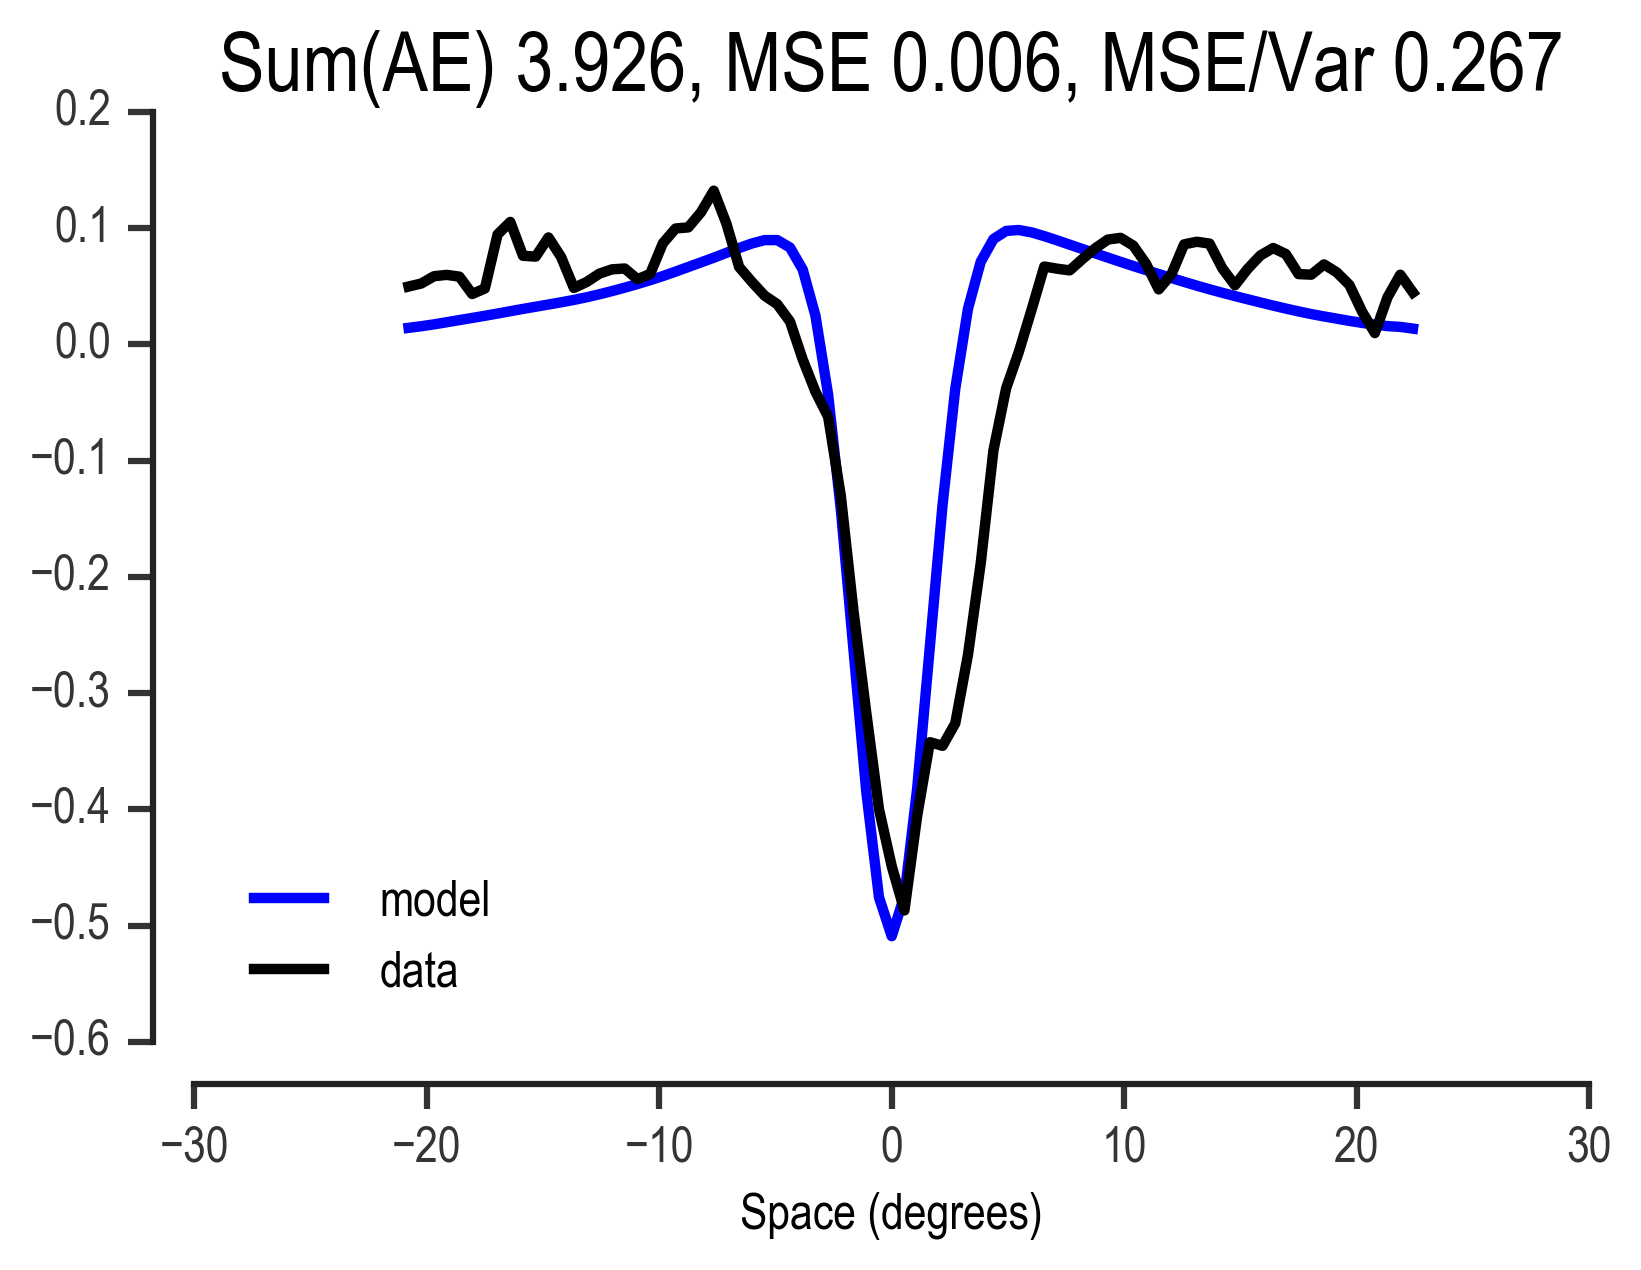

In [453]:
plt.plot(average_spacing, normalized_model_rf, 'b', label='model')
plt.plot(average_spacing, this_ganglion-np.mean(this_ganglion), 'k', label='data')
mse = np.mean((normalized_model_rf - (this_ganglion-np.mean(this_ganglion)))**2)
plt.title('Sum(AE) %0.3f, MSE %0.3f, MSE/Var %0.3f' %(popt.fun, mse, mse/np.var(this_ganglion)))
plt.xlabel('Space (degrees)')
plt.legend(loc='lower left', frameon=False, fontsize=12)
adjust_spines(plt.gca())

In [454]:
x

array([ 1.        ,  0.92942001])

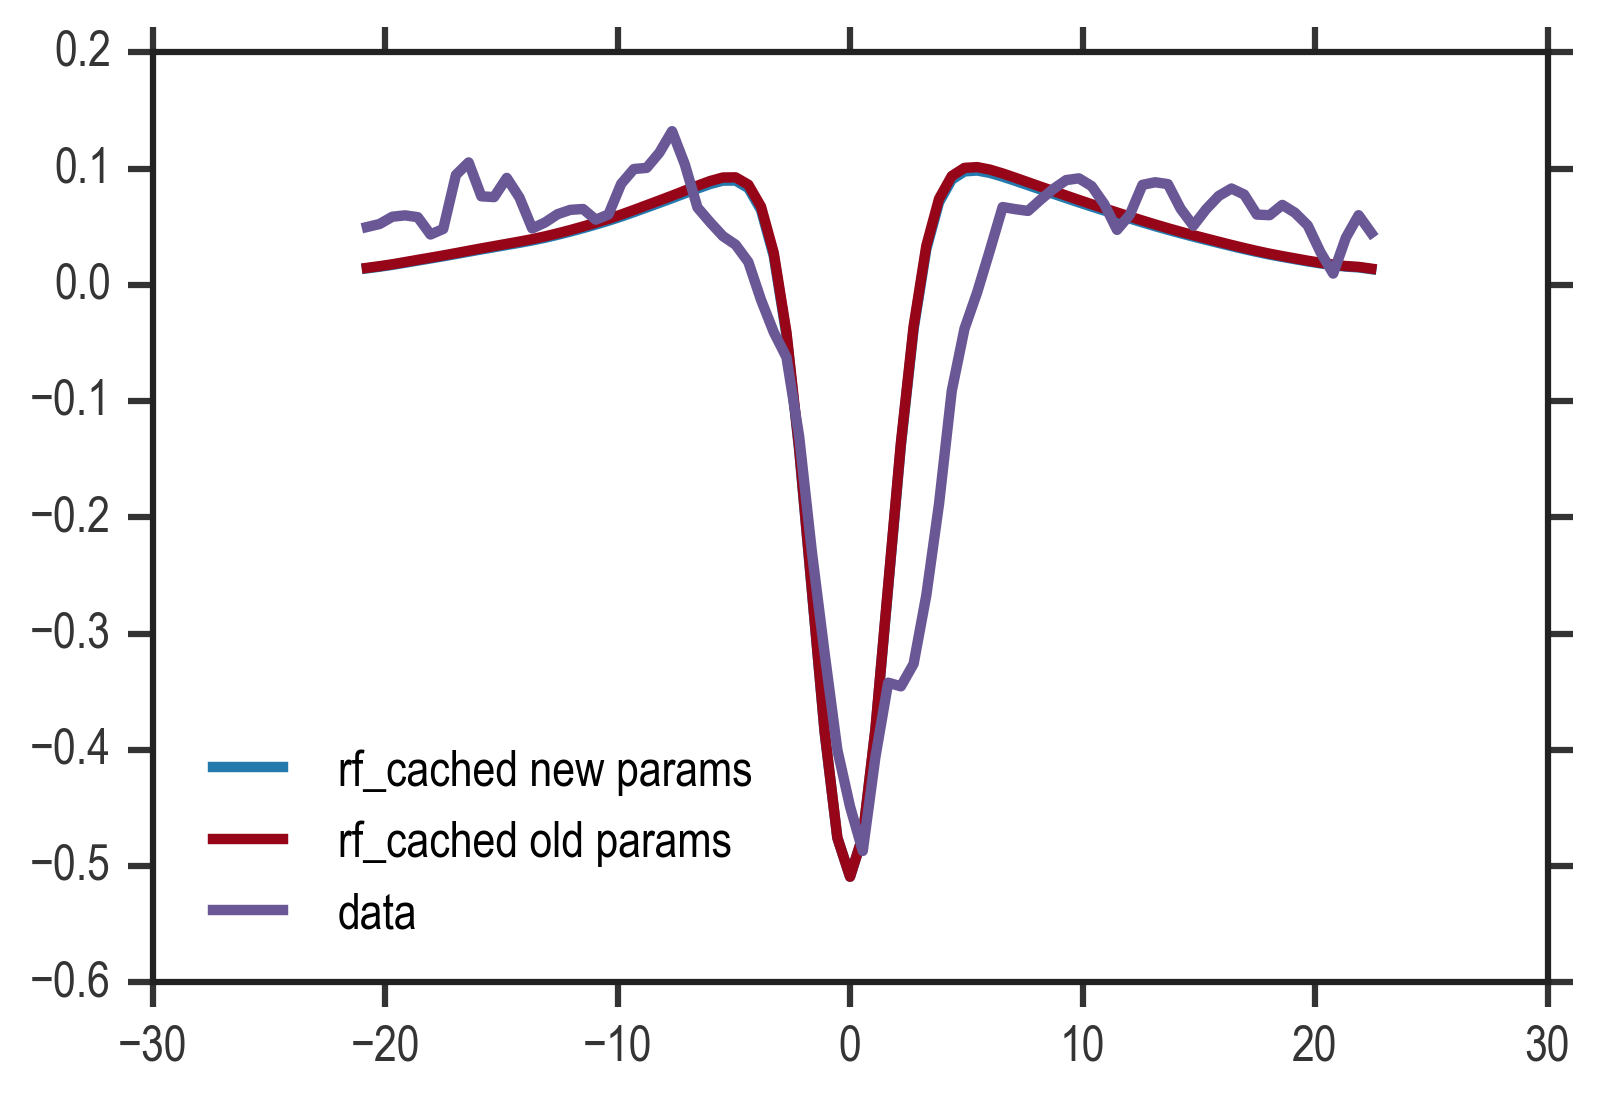

In [455]:
model_rf = -rf_cached(x[0], x[1])
normalized_model_rf = np.max(abs(this_ganglion))*model_rf/np.max(abs(model_rf))

og_model_rf = -rf_cached(*[1.0017, 0.927883])
normalized_og_model_rf = np.max(abs(this_ganglion))*og_model_rf/np.max(abs(og_model_rf))

plt.plot(average_spacing, normalized_model_rf, label='rf_cached new params')
plt.plot(average_spacing, normalized_og_model_rf, label='rf_cached old params')
plt.plot(average_spacing, this_ganglion - np.mean(this_ganglion), label='data')
plt.legend(frameon=False, loc='lower left', fontsize=12)

Verify reported errors

In [456]:
# plt.plot(average_spacing, normalized_model_rf, label='rf_cached new params')
# plt.plot(average_spacing, normalized_og_model_rf, label='rf_cached old params')
# plt.plot(average_spacing, this_ganglion - np.mean(this_ganglion), label='data')
sum(abs(normalized_model_rf) - (this_ganglion - np.mean(this_ganglion)))

6.5740046578919813

In [457]:
sum(abs(normalized_og_model_rf) - (this_ganglion - np.mean(this_ganglion)))

6.6695502908135085

Fixed!

### Get center width for each celltype

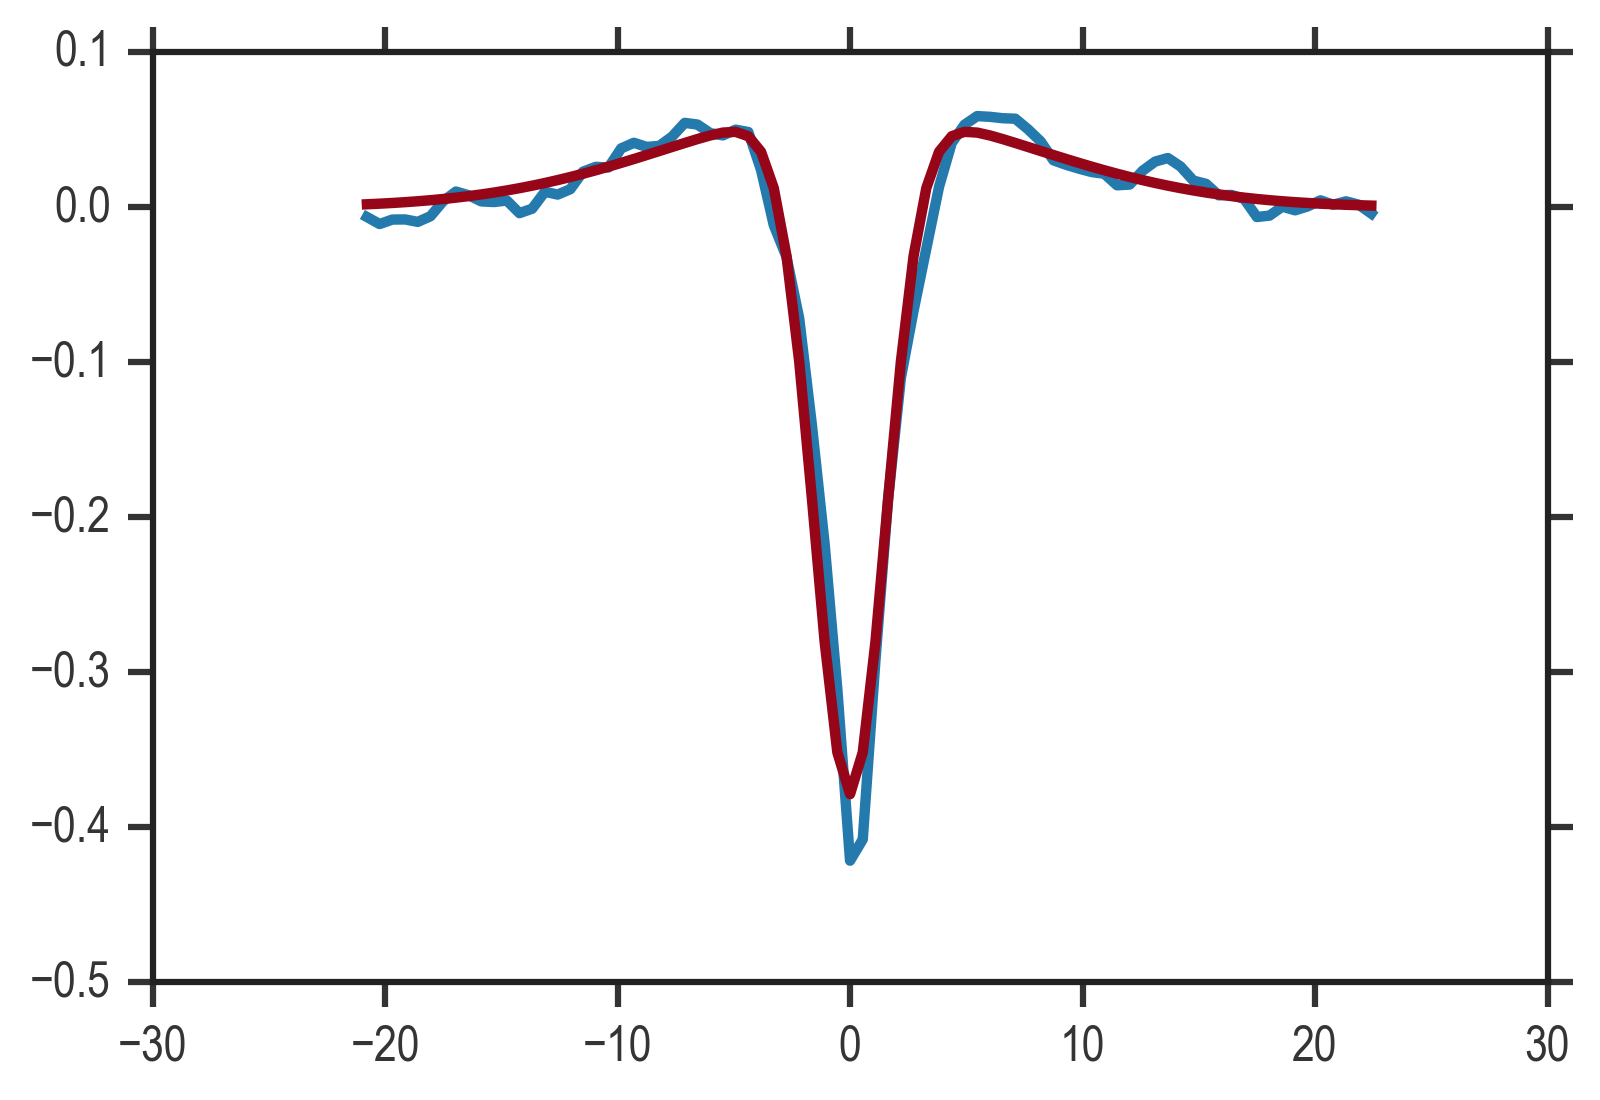

In [459]:
average_ganglion = np.mean(np.stack(receptive_fields['ganglion']), axis=0)
popt, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, average_ganglion)
plt.plot(average_spacing, average_ganglion)
plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt))

In [462]:
center_widths_by_celltype = {}
surround_widths_by_celltype = {}
for celltype in ganglion_aligned_rfs.keys():
    these_center_widths = []
    these_surround_widths = []
    for idg, g in enumerate(ganglion_aligned_rfs[celltype]):
        try:
            popt_this, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, g, p0=popt)
            these_center_widths.append(np.min(abs(popt_this[:2])))
            these_surround_widths.append(np.max(abs(popt_this[:2])))
#             plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt_this), color=np.random.rand(3), alpha=0.6)
        except:
            print("Couldn't fit cell %d" %idg)
    center_widths_by_celltype[celltype] = np.stack(these_center_widths)
    surround_widths_by_celltype[celltype] = np.stack(these_surround_widths)

Couldn't fit cell 4
Couldn't fit cell 8
Couldn't fit cell 29
Couldn't fit cell 172
Couldn't fit cell 175
Couldn't fit cell 38
Couldn't fit cell 49
Couldn't fit cell 50
Couldn't fit cell 51
Couldn't fit cell 52
Couldn't fit cell 61
Couldn't fit cell 63
Couldn't fit cell 67
Couldn't fit cell 69
Couldn't fit cell 74
Couldn't fit cell 153
Couldn't fit cell 178
Couldn't fit cell 185
Couldn't fit cell 191
Couldn't fit cell 194
Couldn't fit cell 195
Couldn't fit cell 197
Couldn't fit cell 203
Couldn't fit cell 206
Couldn't fit cell 207
Couldn't fit cell 209
Couldn't fit cell 215
Couldn't fit cell 218
Couldn't fit cell 219
Couldn't fit cell 393
Couldn't fit cell 424
Couldn't fit cell 513
Couldn't fit cell 666
Couldn't fit cell 70
Couldn't fit cell 71
Couldn't fit cell 72
Couldn't fit cell 114
Couldn't fit cell 131
Couldn't fit cell 207
Couldn't fit cell 212
Couldn't fit cell 213
Couldn't fit cell 218
Couldn't fit cell 230
Couldn't fit cell 233
Couldn't fit cell 236
Couldn't fit cell 58
Couldn'

In [463]:
for celltype in center_widths_by_celltype.keys():
    print('%s:' %celltype)
    print('Mean center width: %0.3f' %np.mean(center_widths_by_celltype[celltype]))
    print('Mean surround width: %0.3f' %np.mean(surround_widths_by_celltype[celltype]))

medium_off_adapting:
Mean center width: 1.673
Mean surround width: 29.238
slow_off:
Mean center width: 1.783
Mean surround width: 163.561
fast_off_adapting:
Mean center width: 1.780
Mean surround width: 18.493
fast_on:
Mean center width: 2.296
Mean surround width: 212.831
fast_off_sensitizing:
Mean center width: 2.376
Mean surround width: 72.171


In [464]:
popt

array([ -1.53279755,   7.90984136,  -6.50750764,  24.45152691])

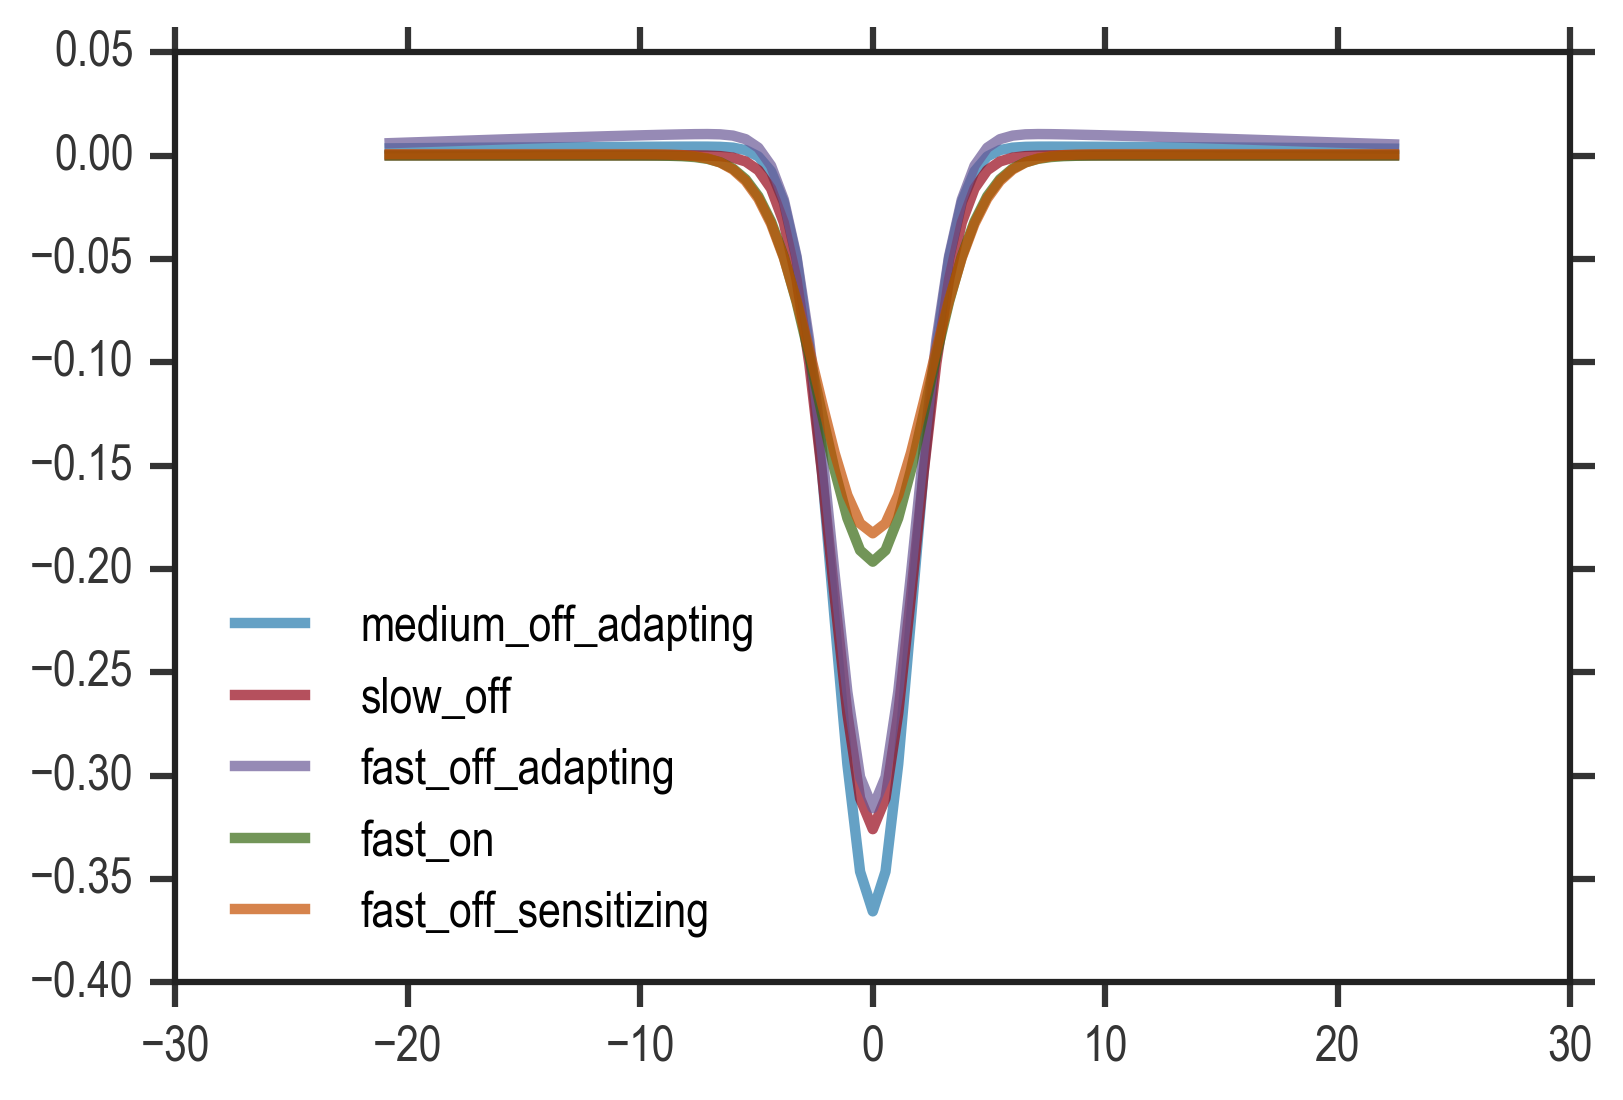

In [469]:
for celltype in center_widths_by_celltype.keys():
    mean_center = np.mean(center_widths_by_celltype[celltype])
    mean_surround = np.mean(surround_widths_by_celltype[celltype])
    plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, mean_center, mean_surround, -6.51, 24.45),
             label=celltype, alpha=0.7)
plt.legend(loc='lower left', frameon=False, fontsize=12)

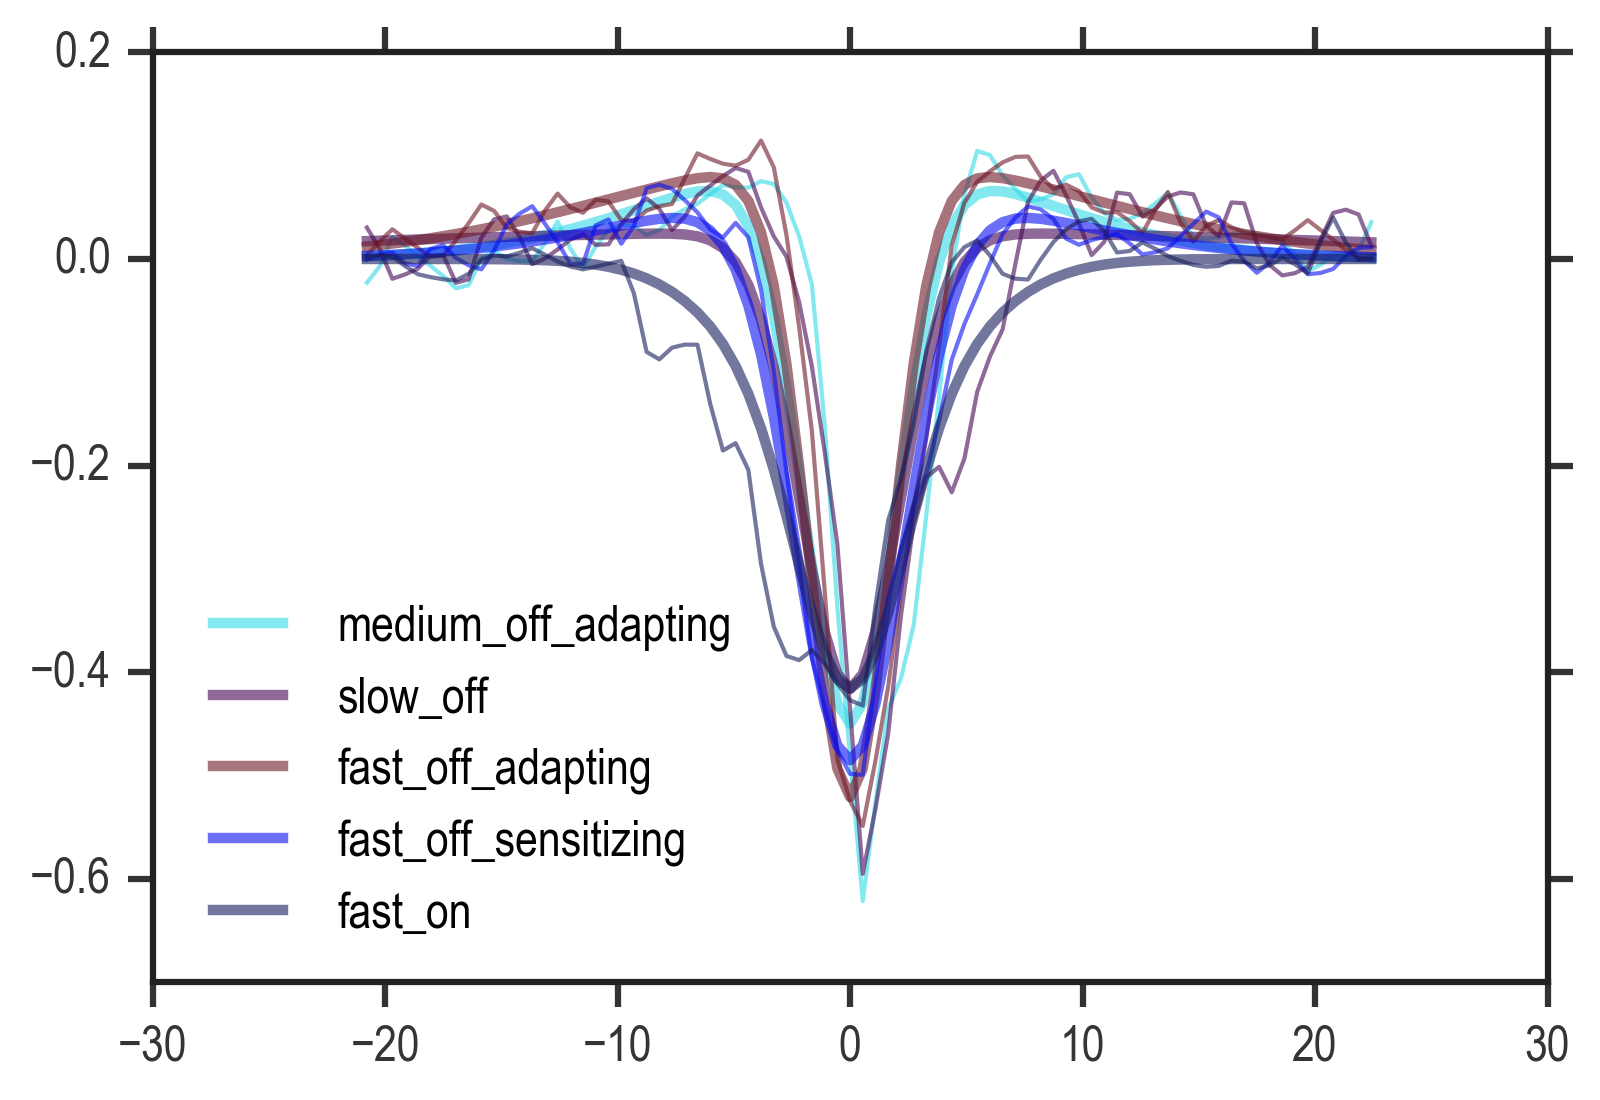

In [484]:
for celltype in ganglion_aligned_rfs.keys():
    g = ganglion_aligned_rfs[celltype][np.random.choice(len(ganglion_aligned_rfs[celltype]))]
    try:
        popt_this, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, g, p0=popt)
        this_color = np.random.rand(3)
        plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt_this), alpha=0.6, 
                 color=this_color, label=celltype)
        plt.plot(average_spacing, g, alpha=0.6, color=this_color, linewidth=1)
    except:
        print("Couldn't fit celltype %s" %celltype)
plt.legend(loc='lower left', frameon=False, fontsize=12)

## Use first 2 PCs

In [545]:
rf = ganglion_rfs['fast_on'][np.random.choice(len(ganglion_rfs['fast_on']))]
pca = PCA(n_components=2)
pca.fit(rf)

PCA(copy=True, n_components=2, whiten=False)

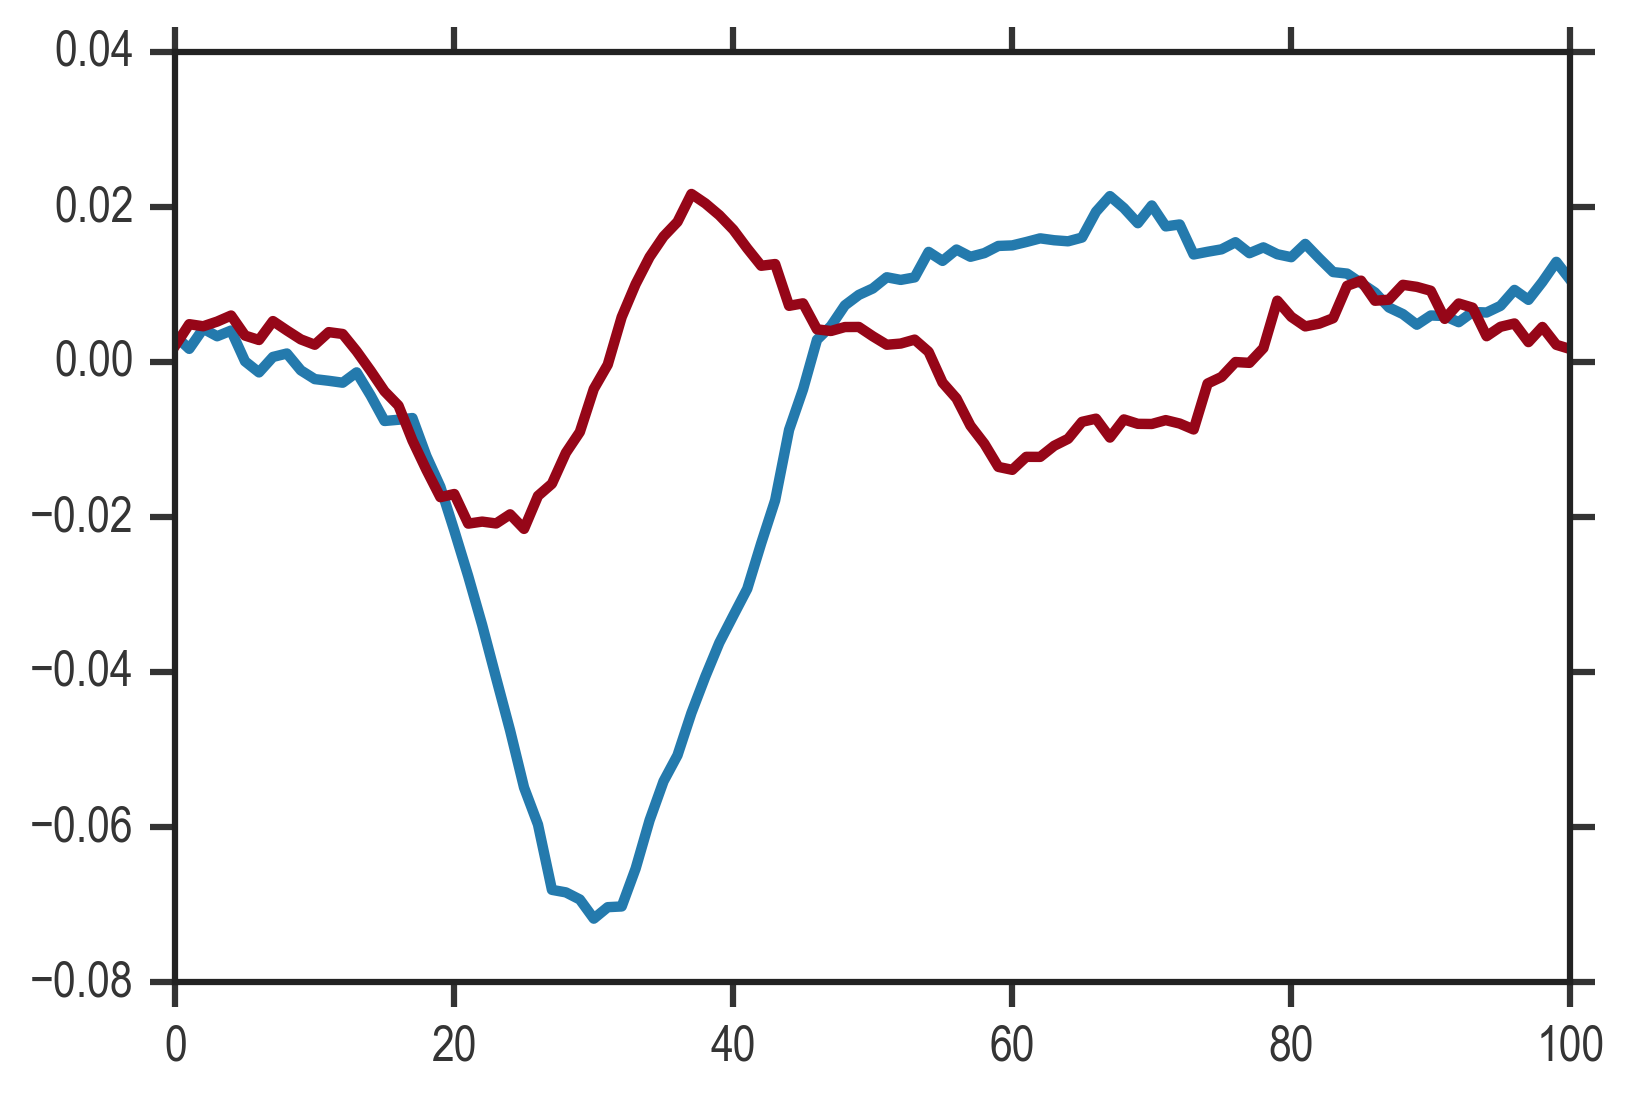

In [546]:
temporal_kernels = [np.dot(pca.components_[0], rf.T), np.dot(pca.components_[1], rf.T)]
plt.plot(temporal_kernels[0])
plt.plot(temporal_kernels[1])

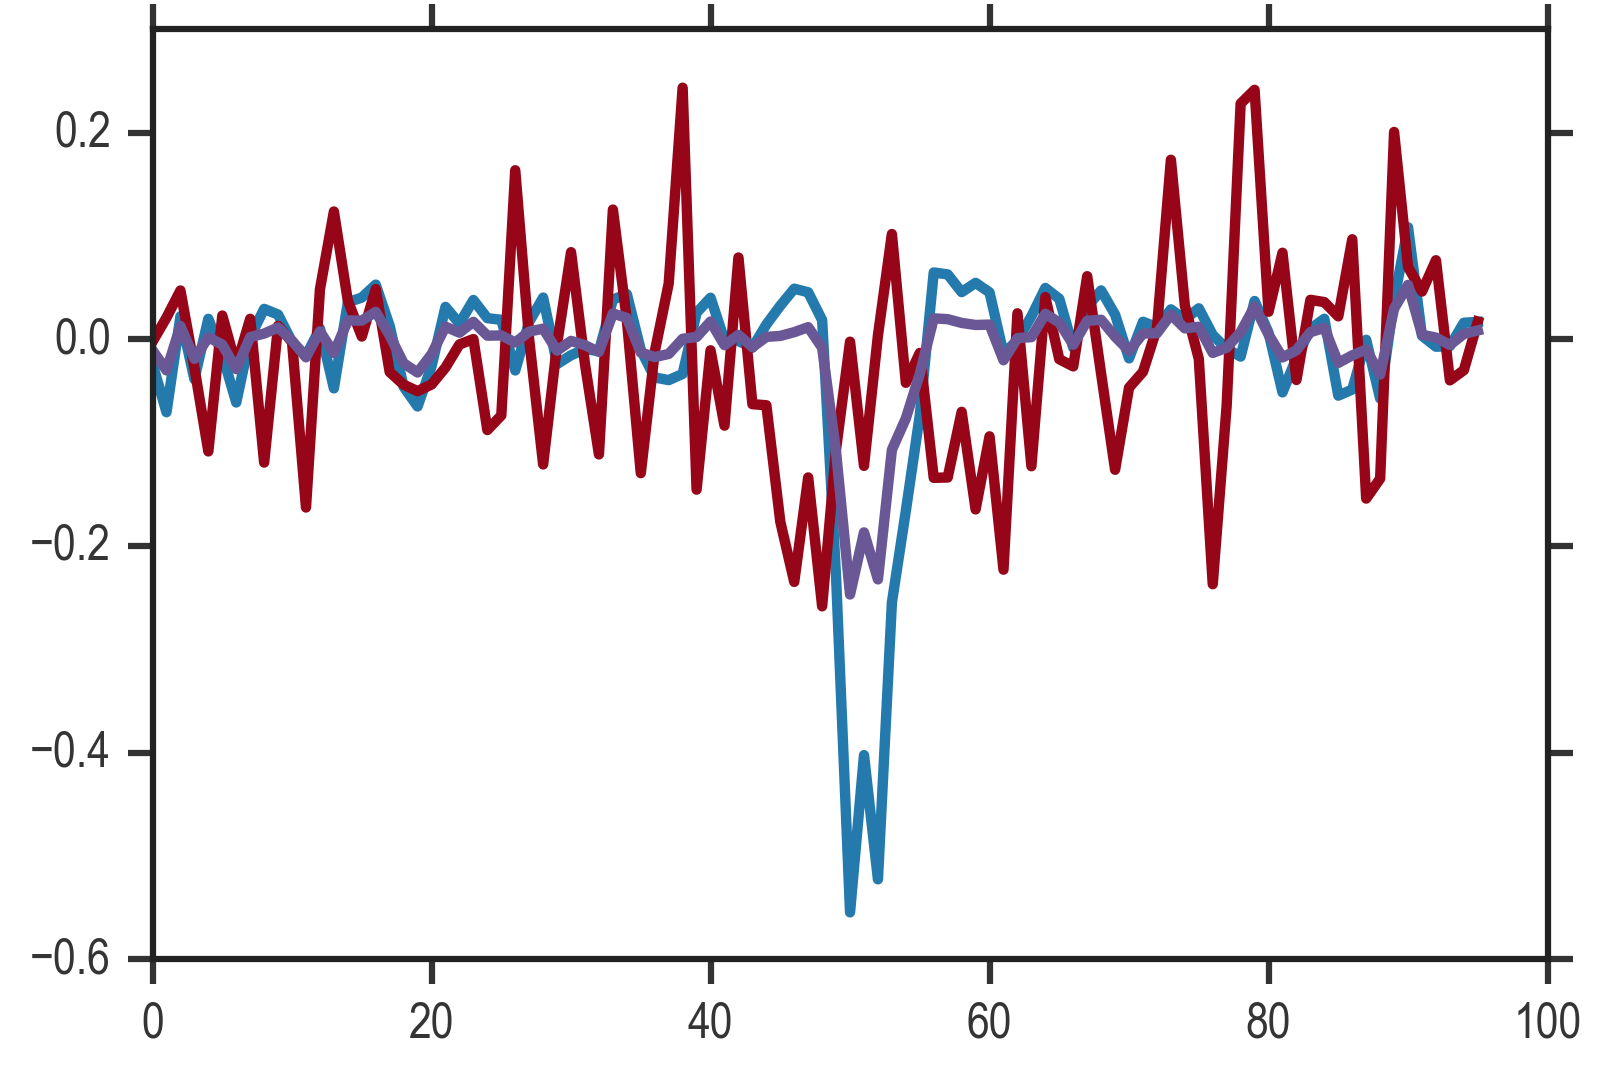

In [547]:
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])
plt.plot(pca.explained_variance_ratio_[0]*pca.components_[0] + pca.explained_variance_ratio_[1]*pca.components_[1])

In [548]:
print(np.var(temporal_kernels[0]))
print(np.var(temporal_kernels[1]))

0.000694283183495
9.88327173458e-05


In [549]:
pca.explained_variance_ratio_

array([ 0.44501061,  0.06334823])

In [550]:
pca.explained_variance_

array([  6.94283183e-04,   9.88327173e-05])

([], <a list of 0 Text yticklabel objects>)

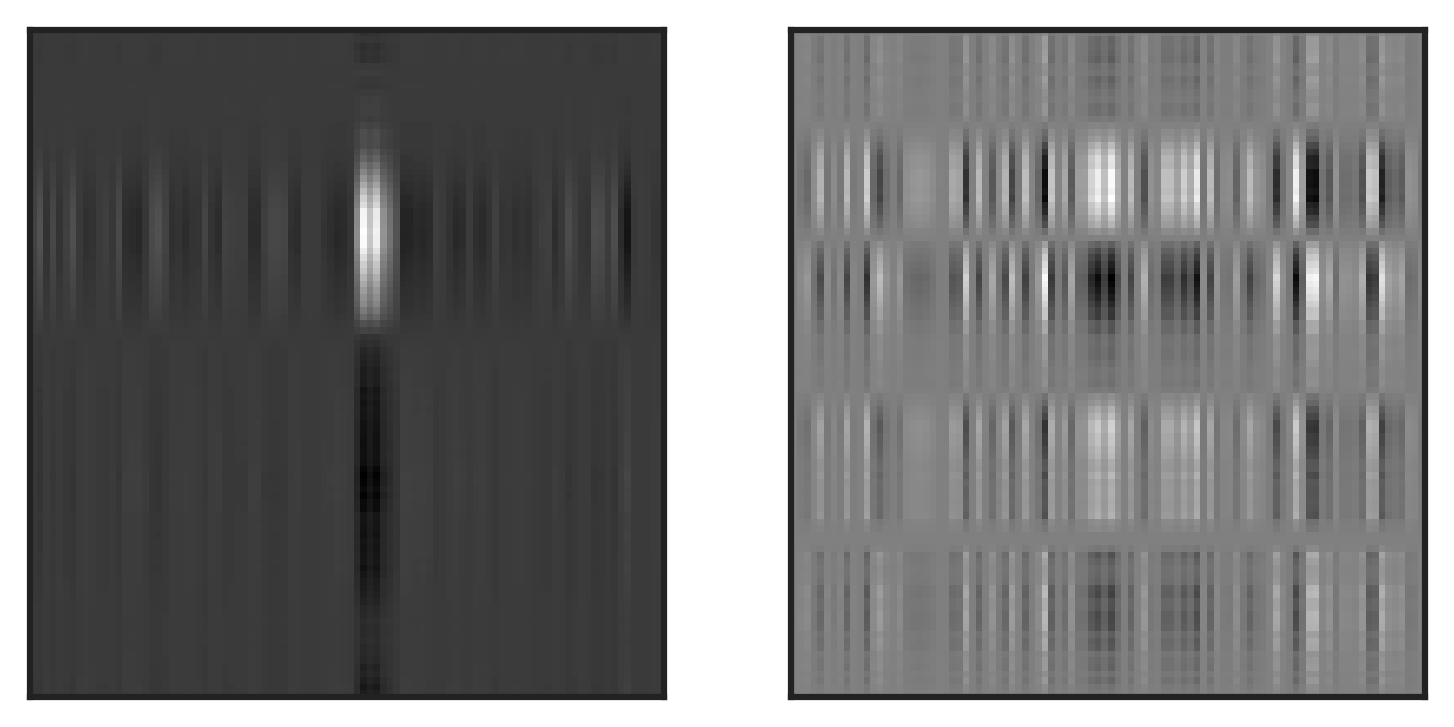

In [551]:
plt.subplot(121)
plt.imshow(np.outer(pca.components_[0], temporal_kernels[0]).T)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(np.outer(pca.components_[1], temporal_kernels[1]).T)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

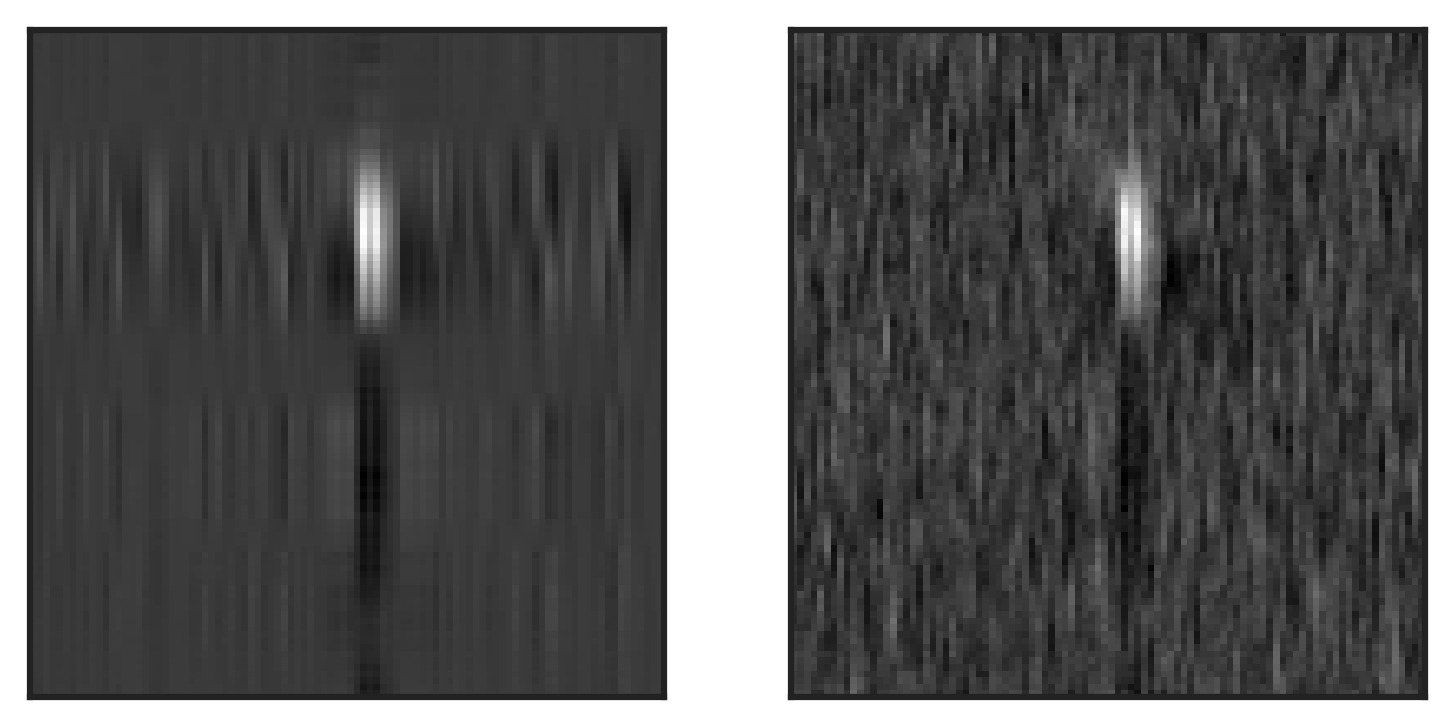

In [552]:
plt.subplot(121)
approx_2nd = np.outer(pca.components_[0], temporal_kernels[0]).T + np.outer(pca.components_[1], temporal_kernels[1]).T
plt.imshow(approx_2nd)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(rf)
plt.xticks([])
plt.yticks([])

In [554]:
ganglion_1d_rfs_2pcs = collections.defaultdict(list)
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        first_component = pca.explained_variance_ratio_[0]*pca.components_[0]
        second_component = pca.explained_variance_ratio_[1]*pca.components_[1]
        g_pca = first_component + second_component

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        space      = get_space(g_pca, spatialDelta, micronsPerDeg)

        ganglion_1d_rfs_2pcs[celltype].append((space, sign_of_pc * g_pca))

Plot 5 random examples for each celltype

In [559]:
for celltype in ganglion_rfs.keys():
    choices = np.random.choice(len(ganglion_rfs[celltype]), 5, replace=False)
    for c in choices:
        space_2pcs, rf_2pcs = ganglion_1d_rfs_2pcs[celltype][c]
        space, rf = ganglion_1d_rfs[celltype][c]
        plt.plot(space, rf, 'b', alpha=0.7, label='1 pc')
        plt.plot(space_2pcs, rf_2pcs, 'g', alpha=0.7, label='2 pcs')
        adjust_spines(plt.gca())
        plt.title('%s cell %d' %(celltype, c))
        plt.xlabel('Space (degrees)')
        plt.ylabel('Sensitivity')
        plt.legend(frameon=False, fontsize=12, loc='lower left')
        plt.savefig('%s cell %d 1 vs 2 pc spatial profiles.pdf' %(celltype, c))
        plt.close()

Histogram of error

In [567]:
eps = 1e-4
bins = np.linspace(0, np.max([np.max(errors[e]) for e in errors.keys()])+eps, 50)

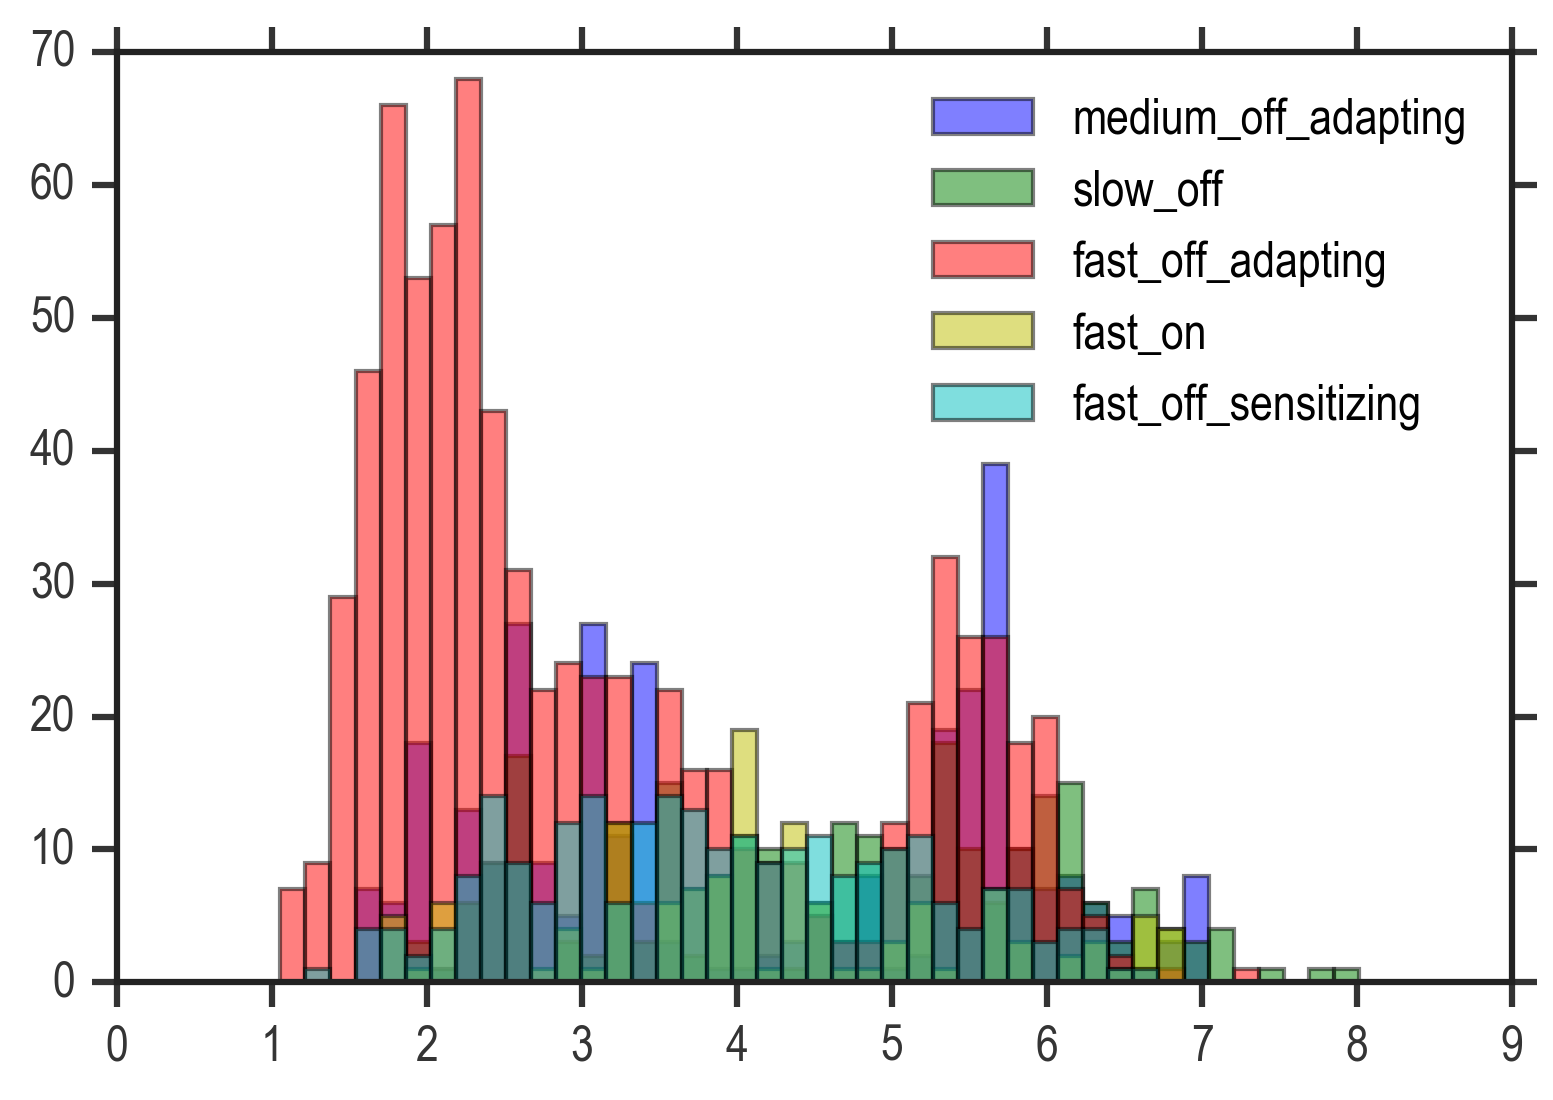

In [570]:
colorscheme = 'bgryc'
for c, celltype in enumerate(errors.keys()):
    hist, bin_edges = np.histogram(errors[celltype], bins=bins)
    bin_width = np.mean(np.diff(bin_edges))
    plt.bar(bin_edges[:-1]+bin_width/2, hist, width=bin_width, label=celltype, 
            color=colorscheme[c], alpha=0.5)
plt.legend(frameon=False, fontsize=12)

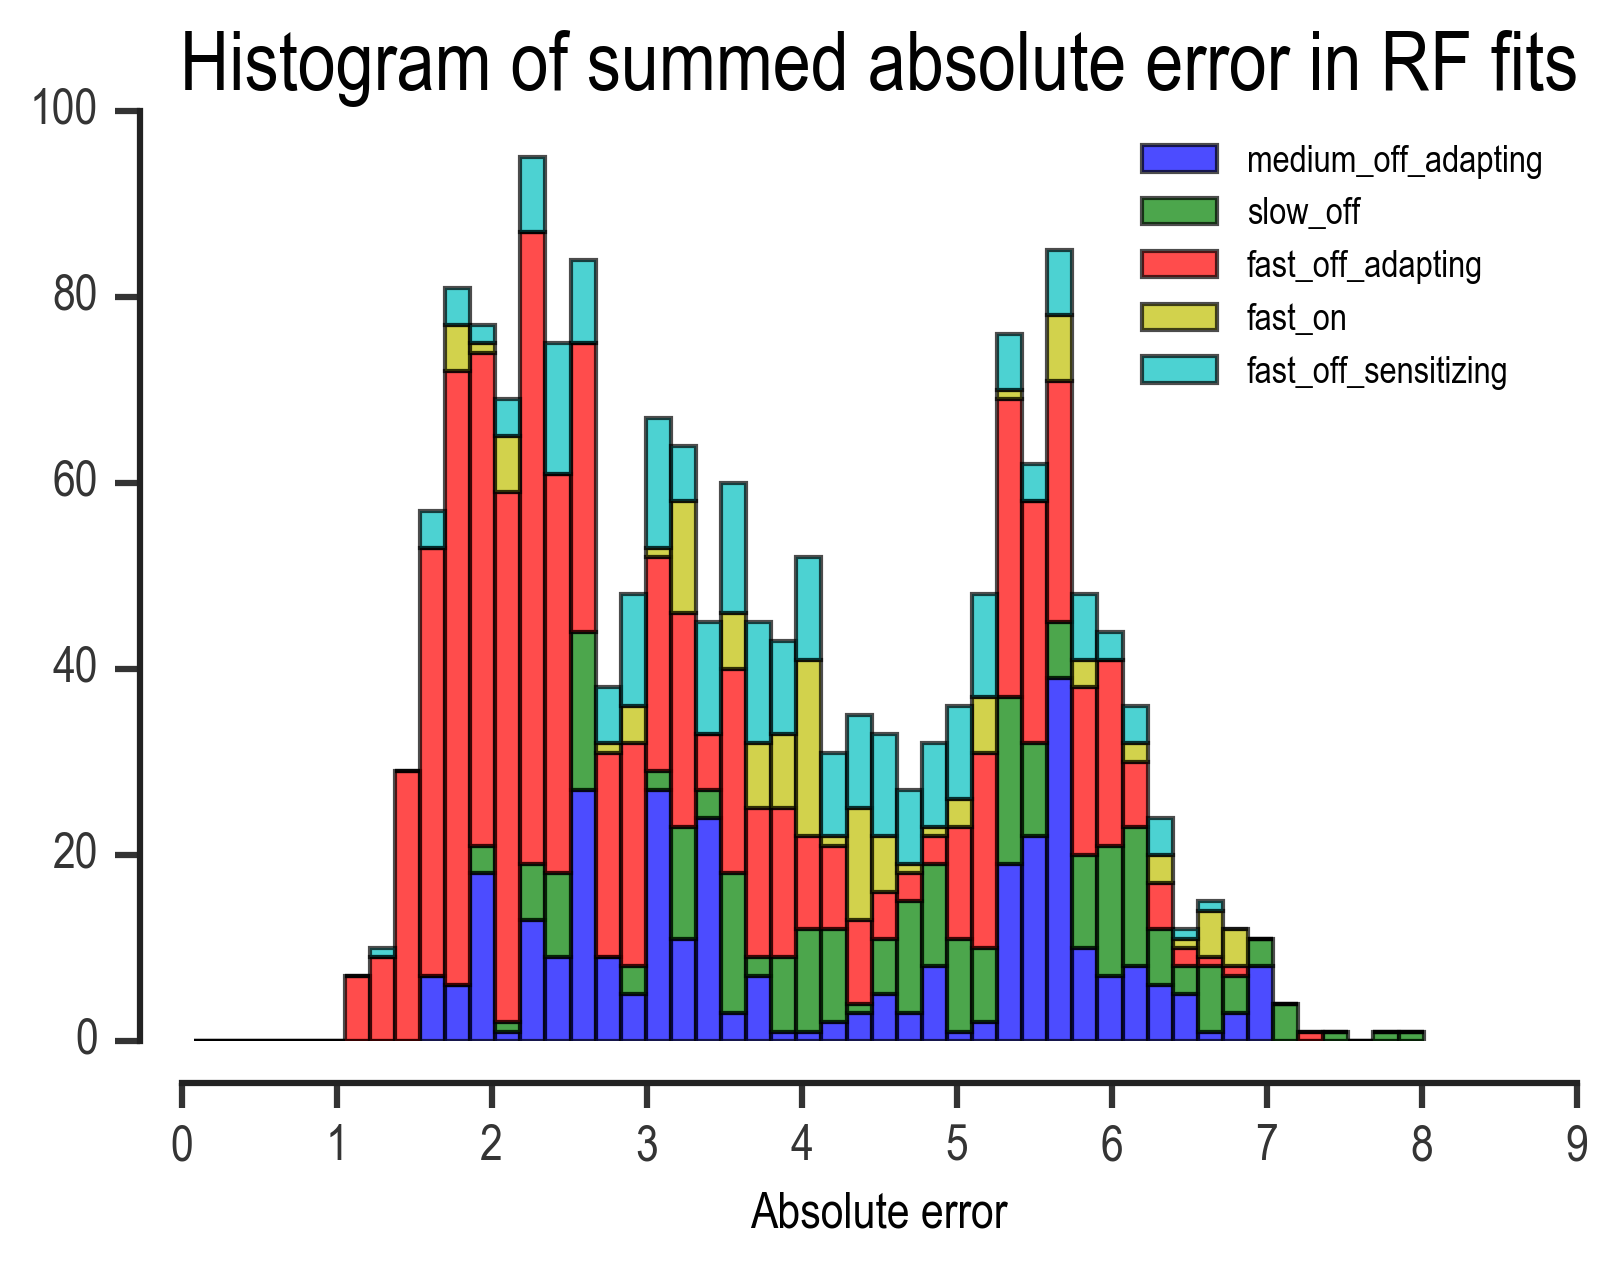

In [581]:
colorscheme = 'bgryc'
previous_counts = np.zeros((len(bins)-1,))
for c, celltype in enumerate(errors.keys()):
    hist, bin_edges = np.histogram(errors[celltype], bins=bins)
    bin_width = np.mean(np.diff(bin_edges))
    plt.bar(bin_edges[:-1]+bin_width/2, hist, width=bin_width, label=celltype, 
            color=colorscheme[c], alpha=0.7, bottom=previous_counts)
    previous_counts += hist
plt.legend(frameon=False, fontsize=9)
plt.title('Histogram of summed absolute error in RF fits')
plt.xlabel('Absolute error')
adjust_spines(plt.gca())

Get percent error (as a function of variance)

In [585]:
percent_errors = collections.defaultdict(list)

# back calculate the MSE - note this is just approximate
# what we're actually calculating is the squared mean error

N = len(average_spacing)
for celltype in errors.keys():
    for ide, e in enumerate(errors[celltype]):
        mse = (e/N)**2
        var = np.var(ganglion_aligned_rfs[celltype][ide])
        percent_errors[celltype].append(mse/var)

In [586]:
eps = 1e-4
bins = np.linspace(0, np.max([np.max(percent_errors[e]) for e in percent_errors.keys()])+eps, 50)
bins[-1]

0.83791250914144588

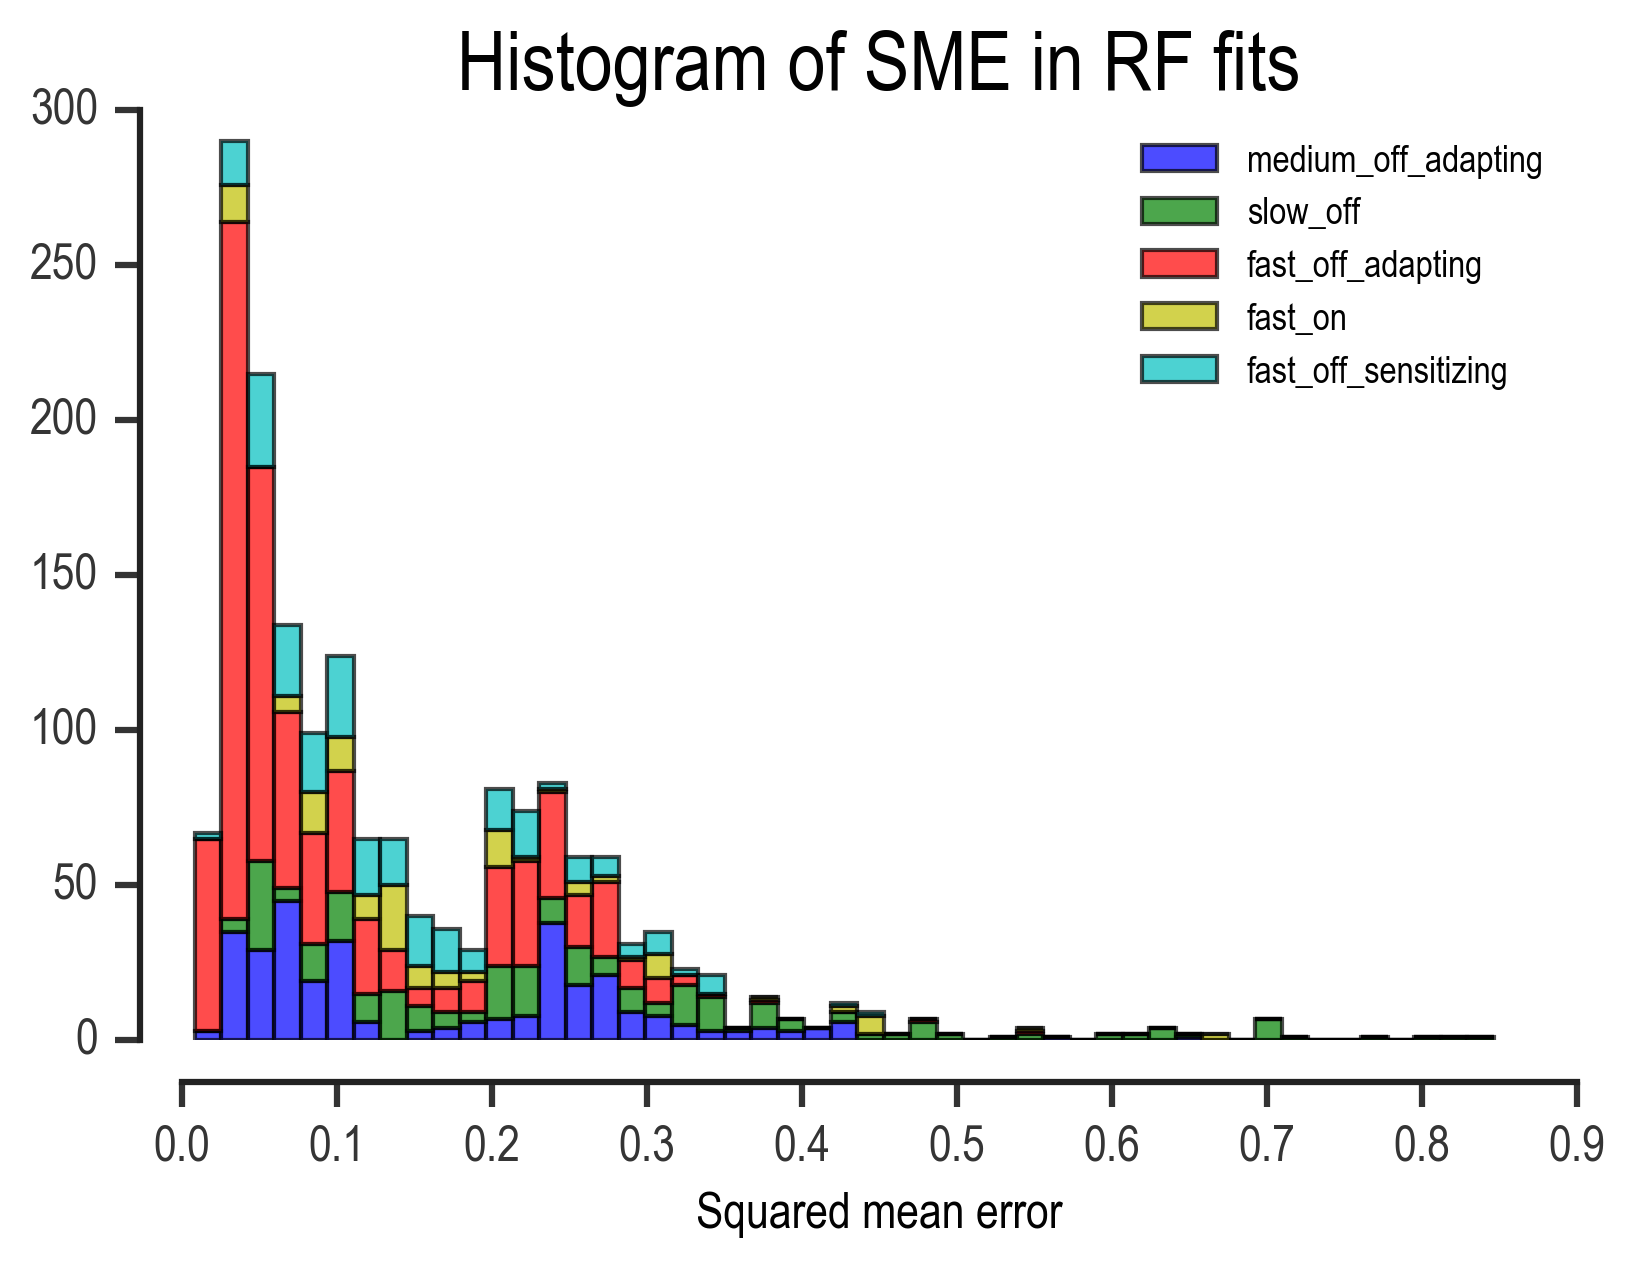

In [587]:
colorscheme = 'bgryc'
previous_counts = np.zeros((len(bins)-1,))
for c, celltype in enumerate(errors.keys()):
    hist, bin_edges = np.histogram(percent_errors[celltype], bins=bins)
    bin_width = np.mean(np.diff(bin_edges))
    plt.bar(bin_edges[:-1]+bin_width/2, hist, width=bin_width, label=celltype, 
            color=colorscheme[c], alpha=0.7, bottom=previous_counts)
    previous_counts += hist
plt.legend(frameon=False, fontsize=9)
plt.title('Histogram of SME in RF fits')
plt.xlabel('Squared mean error')
adjust_spines(plt.gca())

In [589]:
np.max(info_color_map)

8.2032745580930158

In [609]:
? get_snr

In [610]:
input_noise = 0.12
output_noise = 0.35
infos = collections.defaultdict(list)
for celltype in ganglion_aligned_rfs.keys():
    for idg, g in enumerate(ganglion_aligned_rfs[celltype]):
        filt = abs(np.fft.rfft(g))
        snr = get_snr(input_noise, output_noise, signal, filt)
        infos[celltype].append(.5*np.log2(1 + snr))

In [612]:
eps = 1e-4
bins = np.linspace(0, np.max([np.max(infos[c]) for c in infos.keys()])+eps, 50)
bins[-1]

0.29197190779651566

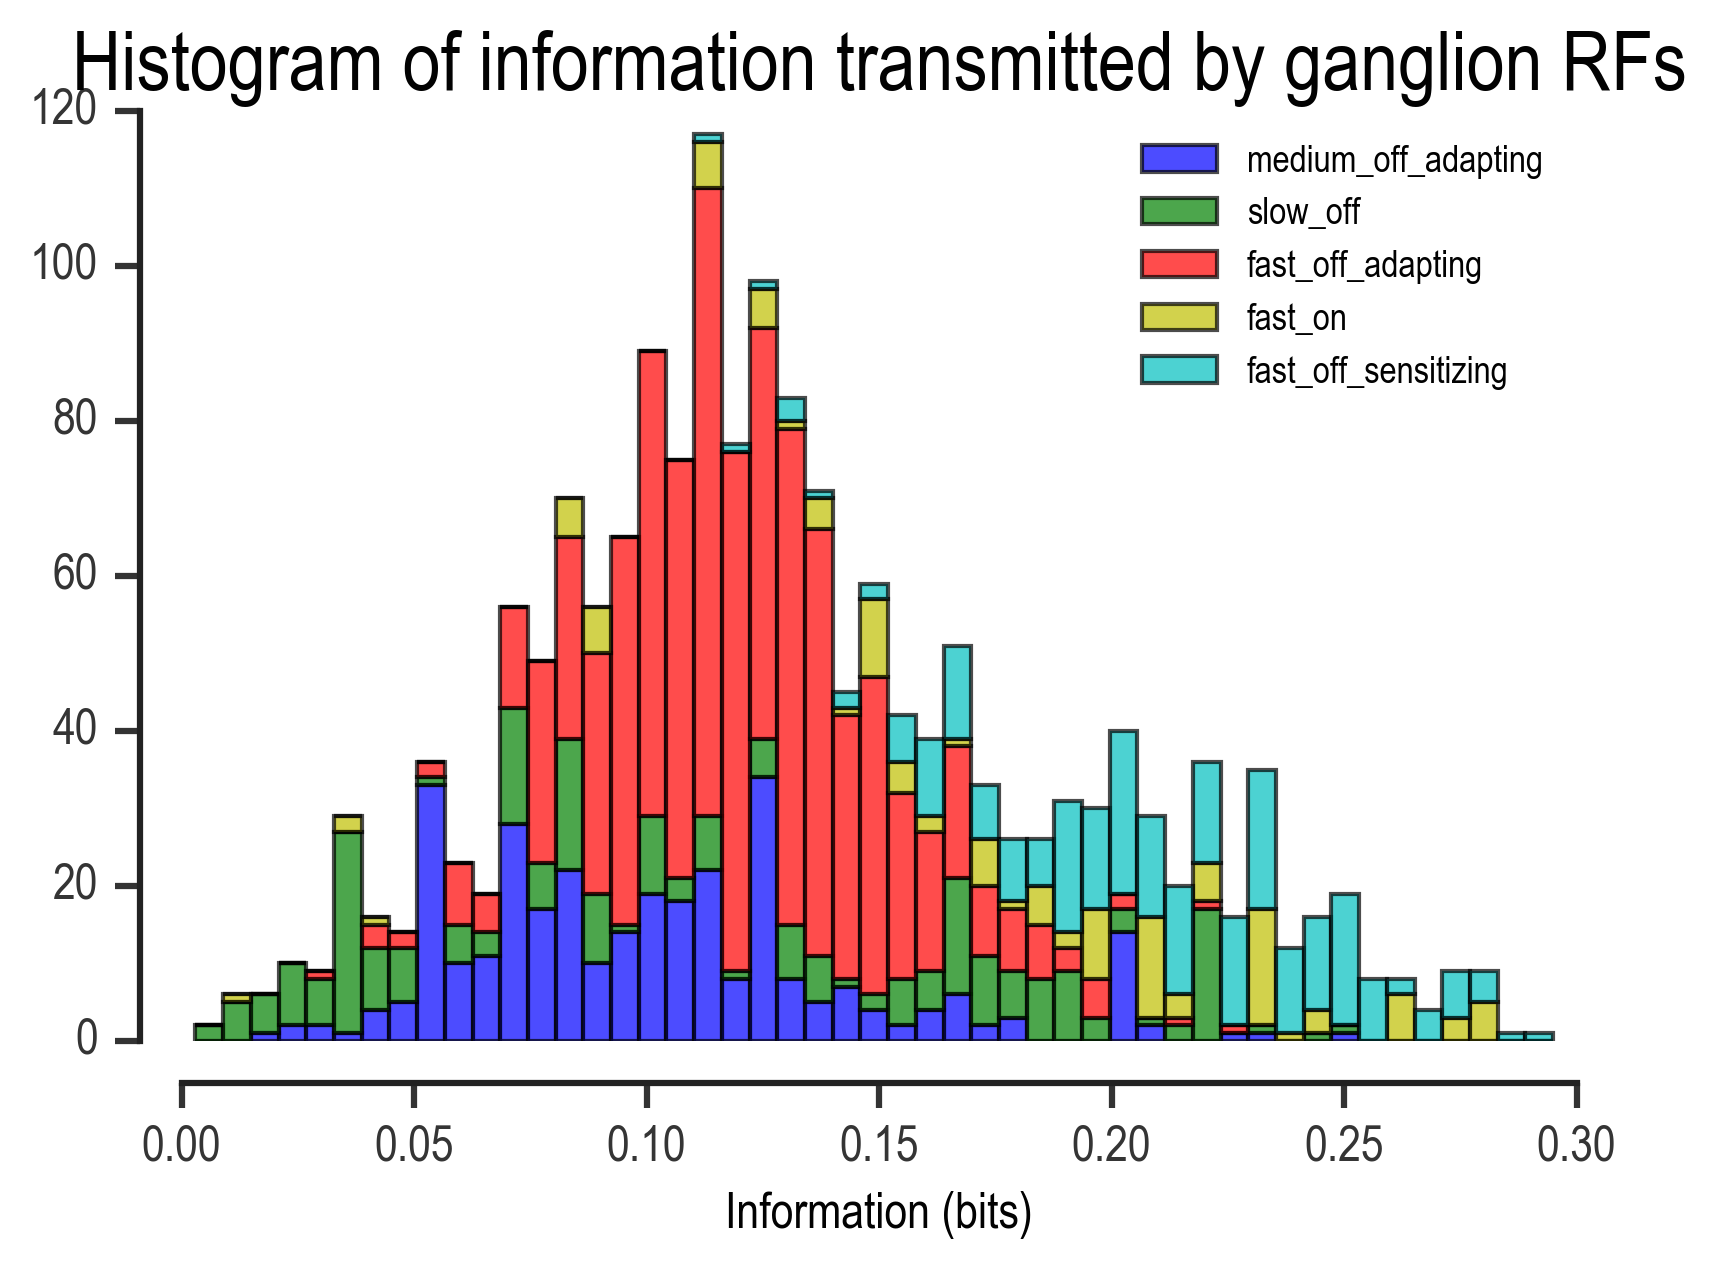

In [614]:
colorscheme = 'bgryc'
previous_counts = np.zeros((len(bins)-1,))
for c, celltype in enumerate(infos.keys()):
    hist, bin_edges = np.histogram(infos[celltype], bins=bins)
    bin_width = np.mean(np.diff(bin_edges))
    plt.bar(bin_edges[:-1]+bin_width/2, hist, width=bin_width, label=celltype, 
            color=colorscheme[c], alpha=0.7, bottom=previous_counts)
    previous_counts += hist
plt.legend(frameon=False, fontsize=9)
plt.title('Histogram of information transmitted by ganglion RFs')
plt.xlabel('Information (bits)')
adjust_spines(plt.gca())

## Need to control for output variance  
While we need to control for this to make an apples-to-apples comparison, this is not really true in real life. In particular, different cell types have different average firing rates, and so have different output variance constraints.

In [625]:
input_noise = 0.12
output_noise = 0.35
target_var = 30.
infos = collections.defaultdict(list)
for celltype in ganglion_aligned_rfs.keys():
    for idg, g in enumerate(ganglion_aligned_rfs[celltype]):
        filt = abs(np.fft.rfft(g))
        
        def constrain_output_var(filt_const):
            this_var = get_output_var(input_noise, output_noise, signal, filt_const*filt)
            return abs(this_var - target_var)

        res = minimize(constrain_output_var, x0=0.9)
        
        snr = get_snr(input_noise, output_noise, signal, res.x*filt)
        infos[celltype].append(.5*np.log2(1 + snr))

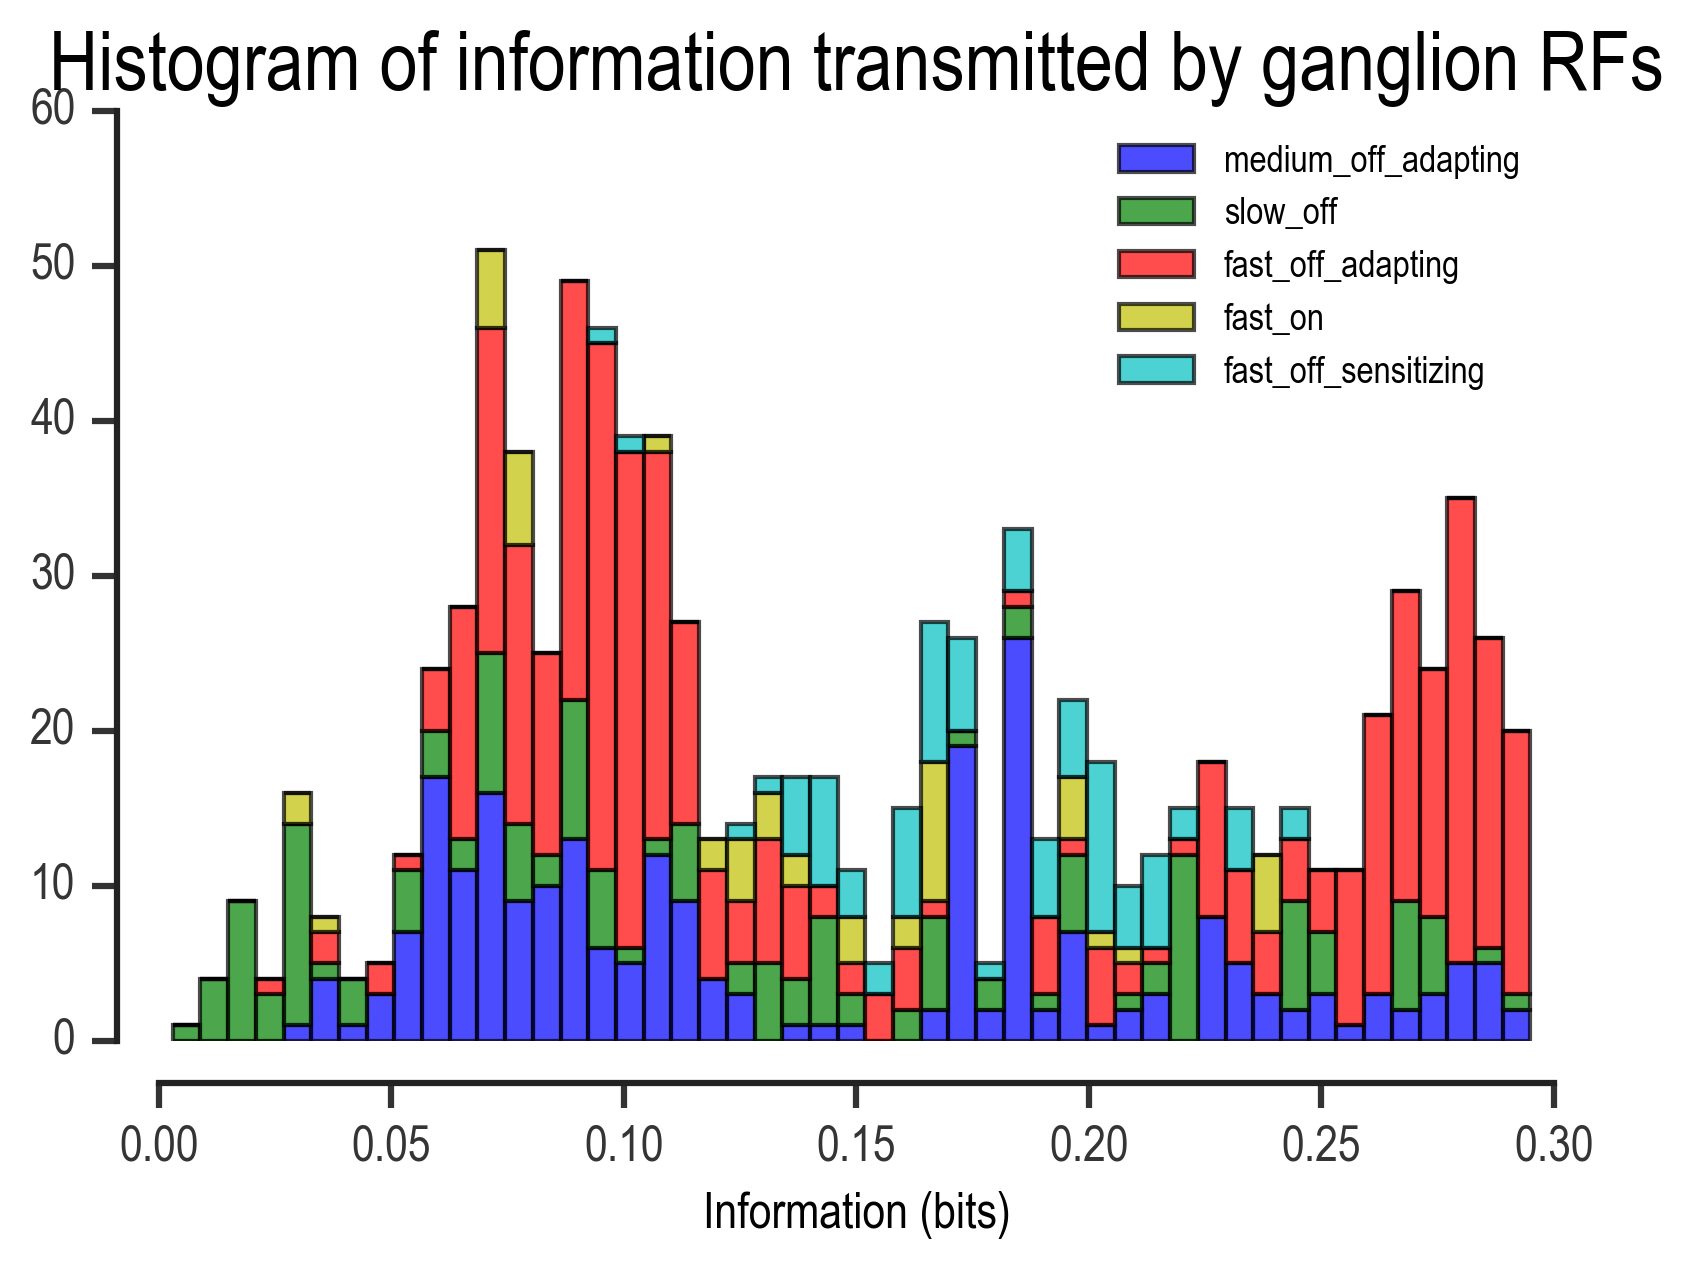

In [626]:
colorscheme = 'bgryc'
previous_counts = np.zeros((len(bins)-1,))
for c, celltype in enumerate(infos.keys()):
    hist, bin_edges = np.histogram(infos[celltype], bins=bins)
    bin_width = np.mean(np.diff(bin_edges))
    plt.bar(bin_edges[:-1]+bin_width/2, hist, width=bin_width, label=celltype, 
            color=colorscheme[c], alpha=0.7, bottom=previous_counts)
    previous_counts += hist
plt.legend(frameon=False, fontsize=9)
plt.title('Histogram of information transmitted by ganglion RFs')
plt.xlabel('Information (bits)')
adjust_spines(plt.gca())

In [630]:
ideal_filt = unique_soln(signal**2, input_noise, output_noise)

def constrain_output_var(filt_const):
    this_var = get_output_var(input_noise, output_noise, signal, filt_const*ideal_filt)
    return abs(this_var - target_var)

res = minimize(constrain_output_var, x0=0.9)
snr_ideal = get_snr(input_noise, output_noise, signal, res.x*ideal_filt)
info_ideal = 0.5*np.log2(1 + snr_ideal)
print('SNR for constrained ideal filter is %0.3f' %snr_ideal)
print('Info for constrained ideal filter is %0.3f' %info_ideal)

The relative error from this choice of Lagrangian multiplier is 6.6134009395e-09.
SNR for constrained ideal filter is 0.624
Info for constrained ideal filter is 0.350


In [632]:
bins = np.linspace(0, 1, 50)

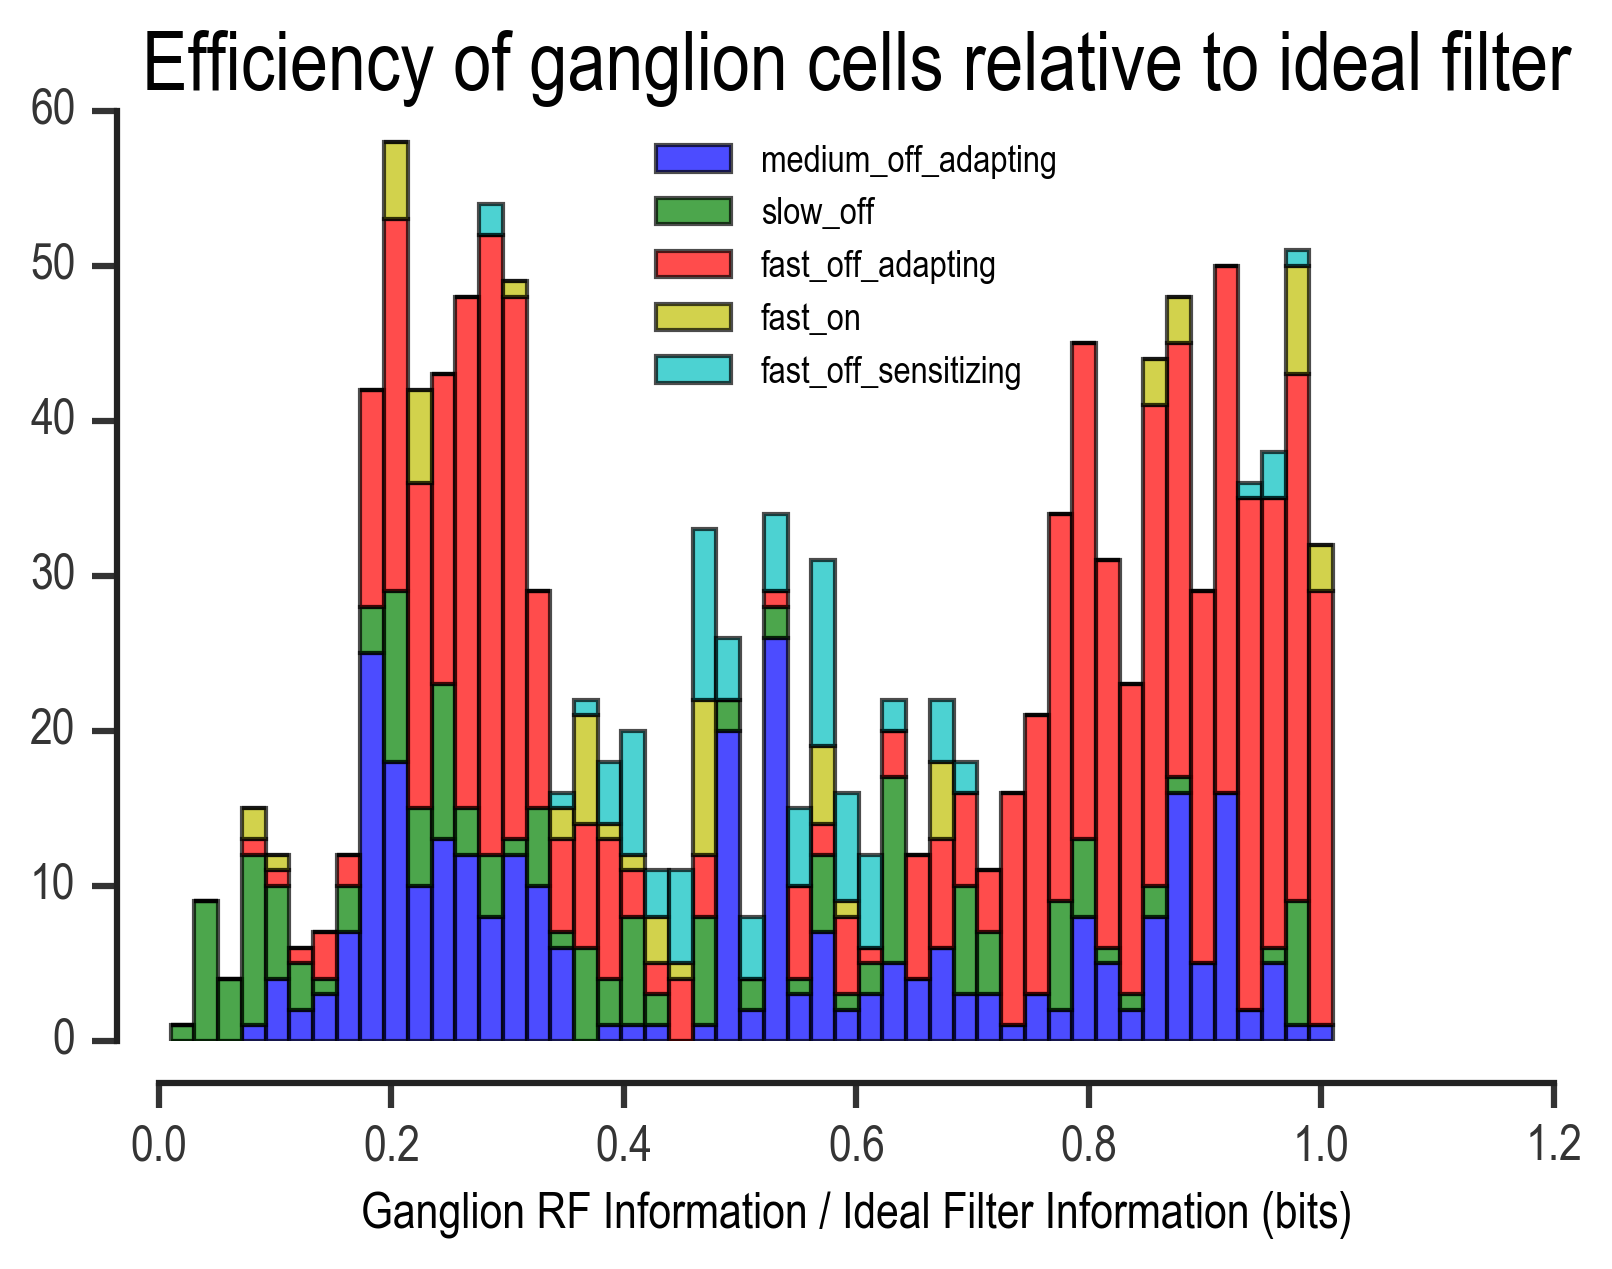

In [634]:
colorscheme = 'bgryc'
previous_counts = np.zeros((len(bins)-1,))
for c, celltype in enumerate(infos.keys()):
    normalized_infos = [i/info_ideal for i in infos[celltype]]
    hist, bin_edges = np.histogram(normalized_infos, bins=bins)
    bin_width = np.mean(np.diff(bin_edges))
    plt.bar(bin_edges[:-1]+bin_width/2, hist, width=bin_width, label=celltype, 
            color=colorscheme[c], alpha=0.7, bottom=previous_counts)
    previous_counts += hist
plt.legend(frameon=False, fontsize=9, loc='upper center')
plt.title('Efficiency of ganglion cells relative to ideal filter')
plt.xlabel('Ganglion RF Information / Ideal Filter Information (bits)')
adjust_spines(plt.gca())

## Look at diversity of RFs as parameterized by our model

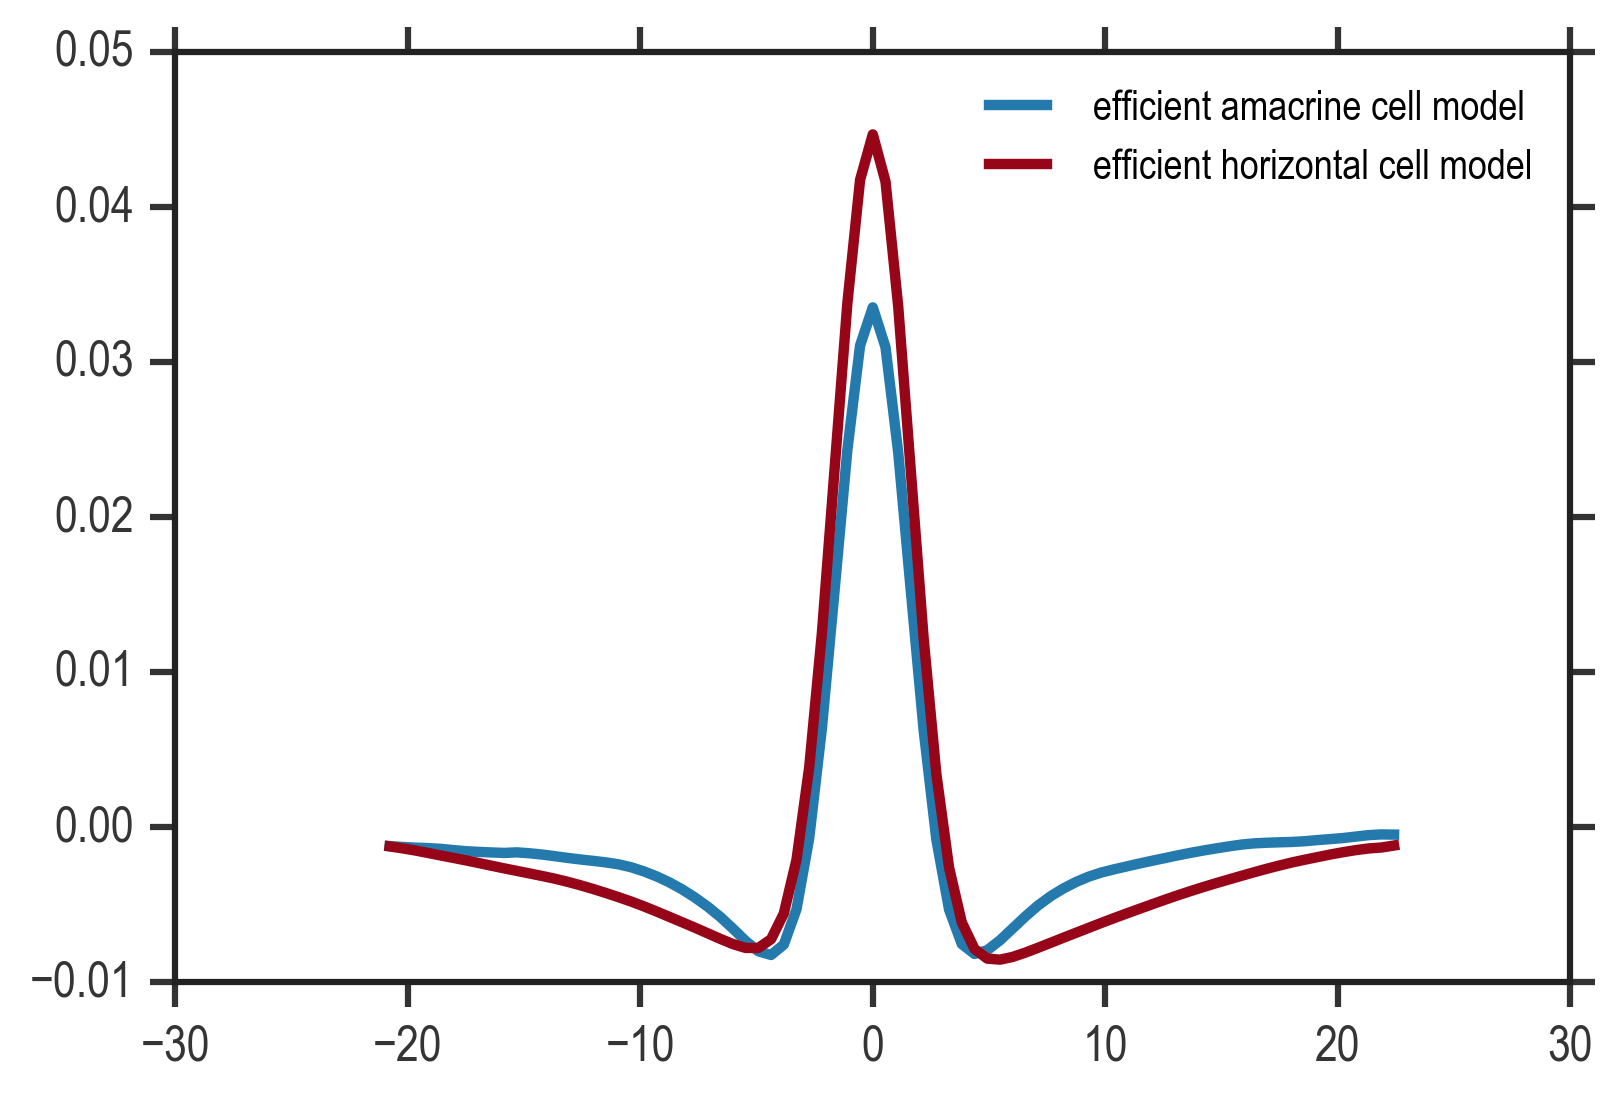

In [638]:
plt.plot(average_spacing, rf_cached(0, .89), label='efficient amacrine cell model')
plt.plot(average_spacing, rf_cached(1, .93), label='efficient horizontal cell model')
plt.legend(frameon=False, fontsize=10)

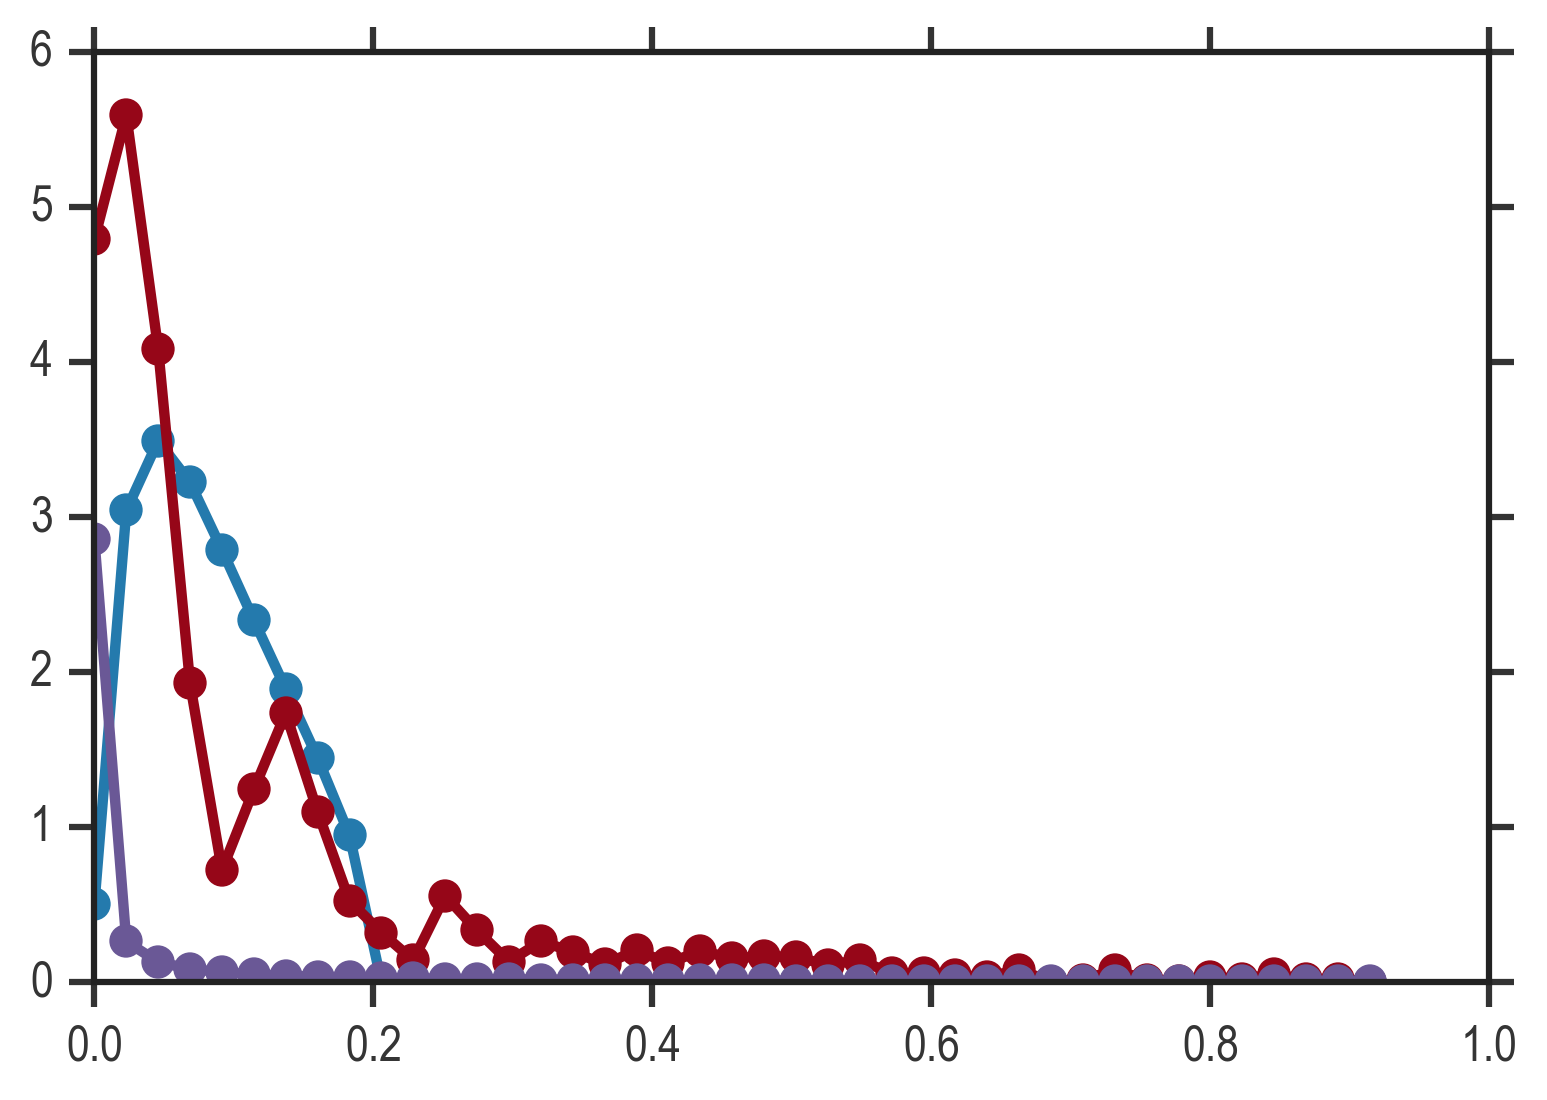

In [646]:
plt.plot(freqs, ideal_filt, '.-')
plt.plot(freqs, filt, '.-')
plt.plot(freqs, signal, '.-')

In [809]:
N = len(average_spacing)
test_x = np.fft.irfft(signal) + 5 #np.random.randn(N)
test_input_noise = input_noise*np.random.randn(N)
test_output_noise = output_noise*np.random.randn(N)
test_filt = ganglion_aligned_rfs['fast_off_adapting'][np.random.choice(len(ganglion_aligned_rfs['fast_off_adapting']))]
test_y = np.convolve(test_x + test_input_noise, test_filt, mode='same') + test_output_noise

In [770]:
np.var(test_y)

4.3979613379073346

In [771]:
np.std(test_input_noise)

0.12731024557404155

In [772]:
np.std(test_output_noise)

0.32874334755092233

In [773]:
get_output_var(input_noise, output_noise, abs(np.fft.rfft(test_x)), abs(np.fft.rfft(test_filt)))

0.002084717660112095

In [774]:
get_signal_var(abs(np.fft.rfft(test_x)), abs(np.fft.rfft(test_filt)))

0.00024663733921143305

In [775]:
get_noise_var(input_noise, output_noise, abs(np.fft.rfft(test_filt)))

0.0018380803209006619

In [776]:
get_snr(input_noise, output_noise, abs(np.fft.rfft(test_x)), abs(np.fft.rfft(test_filt)))

0.13418202480432434

In [778]:
np.mean(test_x)

5.0357142857142865

In [783]:
get_signal_var(abs(np.fft.rfft(test_x)), abs(np.fft.rfft(test_filt)))

0.00024663733921143305

In [820]:
test_x = np.random.randn(1000) + 5
test_filt = np.random.randn(1000)

In [821]:
np.var(np.convolve(test_x, test_filt, mode='same'))

8284.9603171655835

In [822]:
np.sum((np.convolve(test_x, test_filt, mode='full'))**2)

22466379.860056847

In [823]:
N = 2 * (len(abs(np.fft.rfft(test_filt)))-1)
2 * np.sum((abs(np.fft.rfft(test_filt)) * abs(np.fft.rfft(test_x)))**2) / N

2606329.083093585

In [825]:
np.var(np.convolve(test_x, test_filt, mode='full'))

11021.349388279243

In [827]:
N = 2 * (len(abs(np.fft.rfft(test_filt)))-1)
2 * np.sum((abs(np.fft.rfft(test_filt)[1:]) * abs(np.fft.rfft(test_x)[1:]))**2) / N**2

868.38875641278435

In [828]:
blah = np.fft.irfft(abs(np.fft.rfft(test_filt)) * abs(np.fft.rfft(test_x)))
np.var(blah)

868.38875343884388

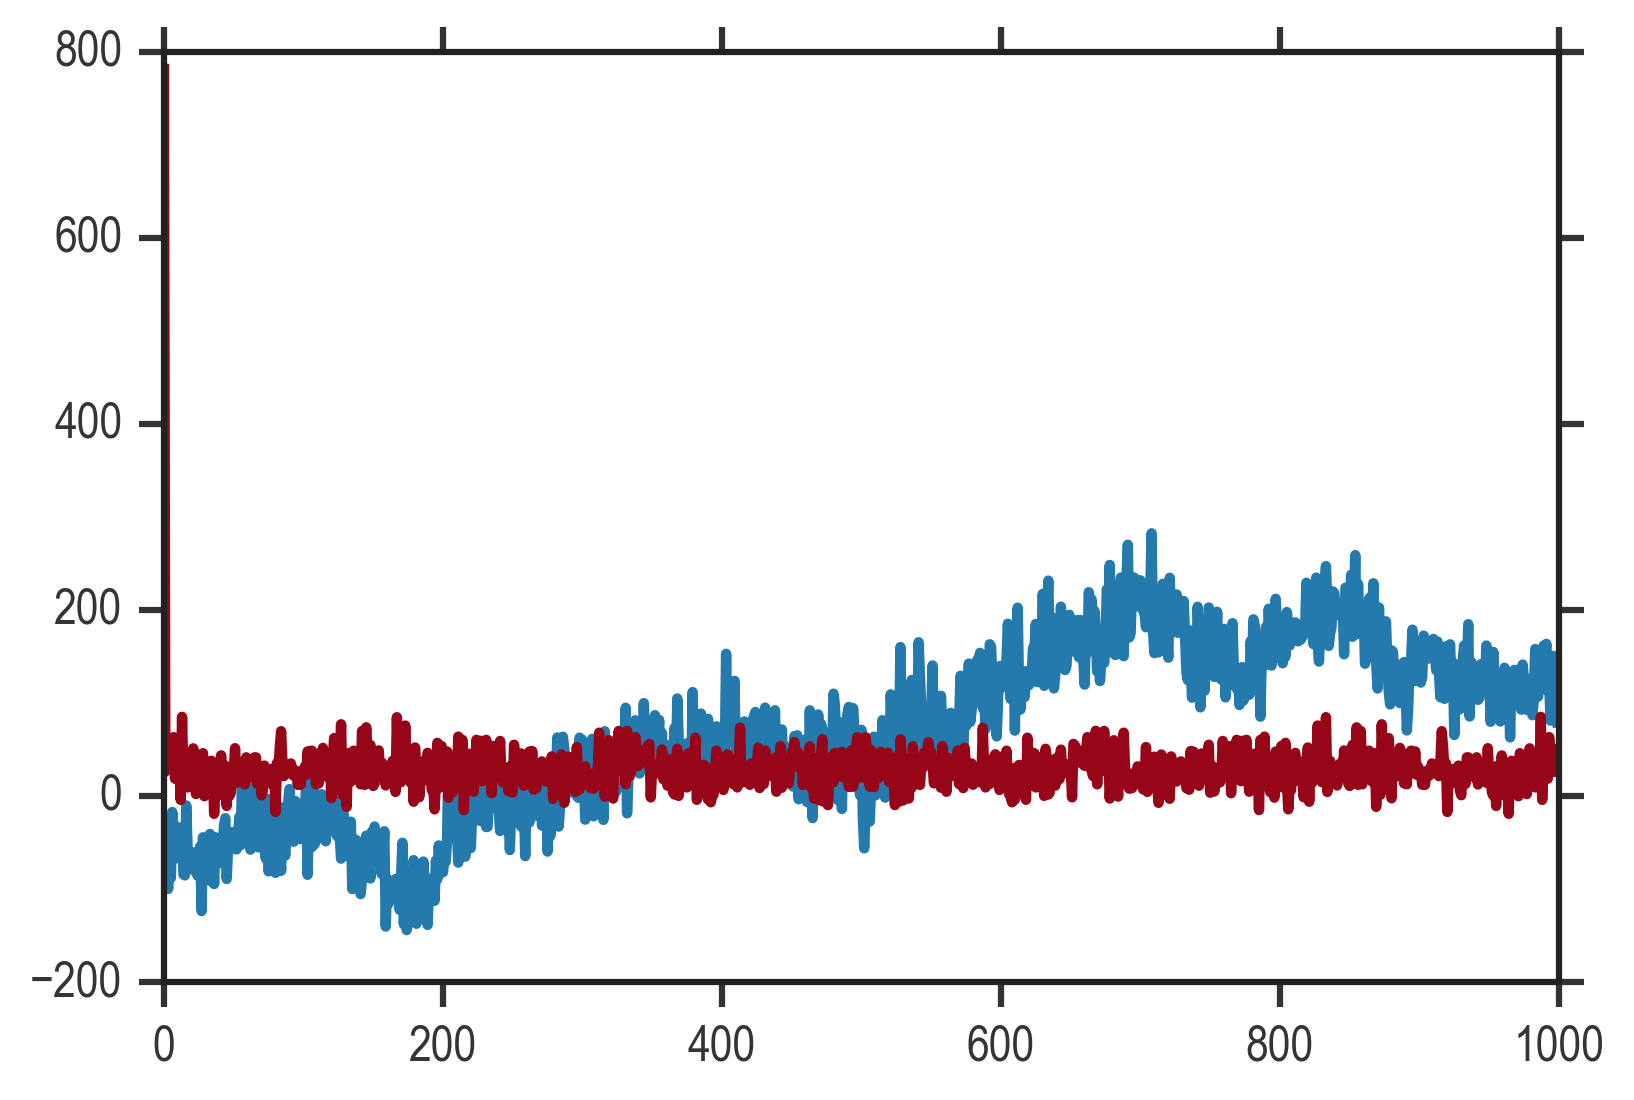

In [831]:
plt.plot(np.convolve(test_x, test_filt, mode='same'))
plt.plot(blah)

In [835]:
from scipy.signal import fftconvolve

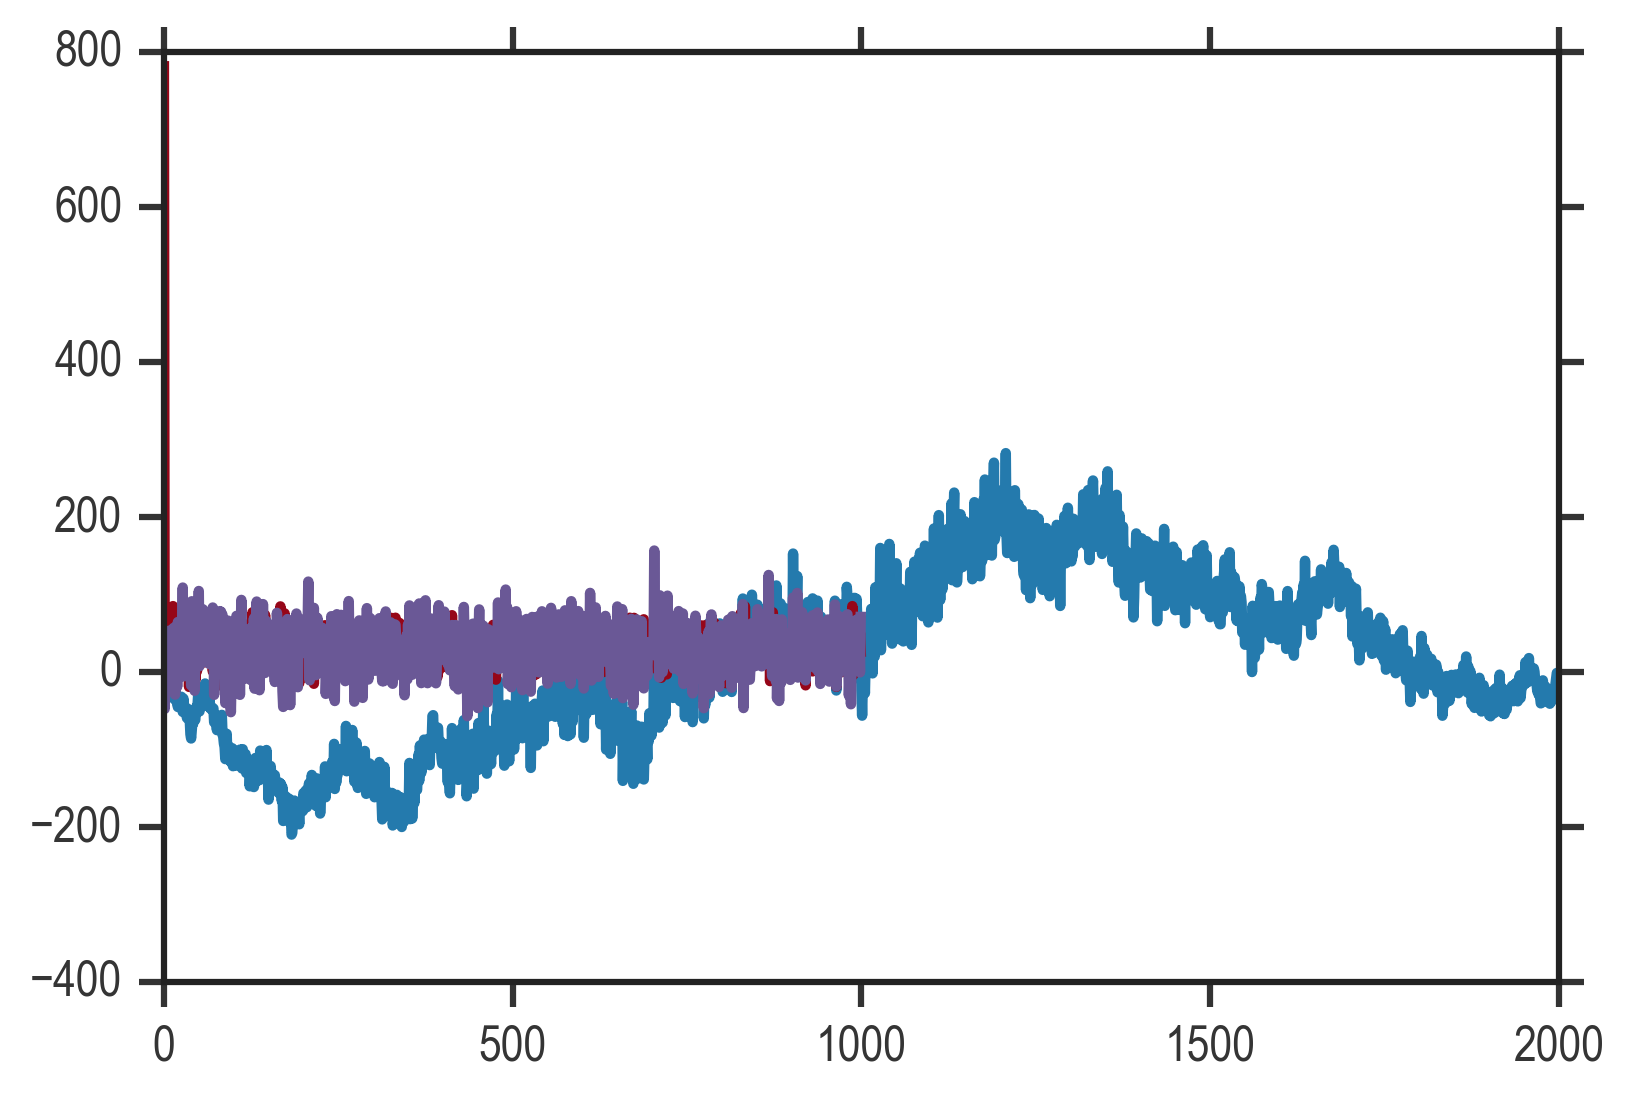

In [839]:
plt.plot(fftconvolve(test_x, test_filt))
plt.plot(np.fft.irfft(abs(np.fft.rfft(test_x)) * abs(np.fft.rfft(test_filt))))
plt.plot(np.fft.irfft(np.fft.rfft(test_x) * np.fft.rfft(test_filt)))

In [840]:
from scipy import fftpack

In [844]:
shape = np.array(test_x.shape) + np.array(test_filt.shape) - 1
shape

array([1999])

In [845]:
fftpack.helper.next_fast_len(int(shape))

2000

In [859]:
sp1 = np.fft.rfft(test_x)
sp1n = np.fft.rfftn(test_x, shape)

sp2 = np.fft.rfft(test_filt)
sp2n = np.fft.rfftn(test_filt, shape)

In [856]:
fslice = tuple([slice(0, int(sz)) for sz in shape])

/Users/lmcintosh/Library/Python/3.5/lib/python/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


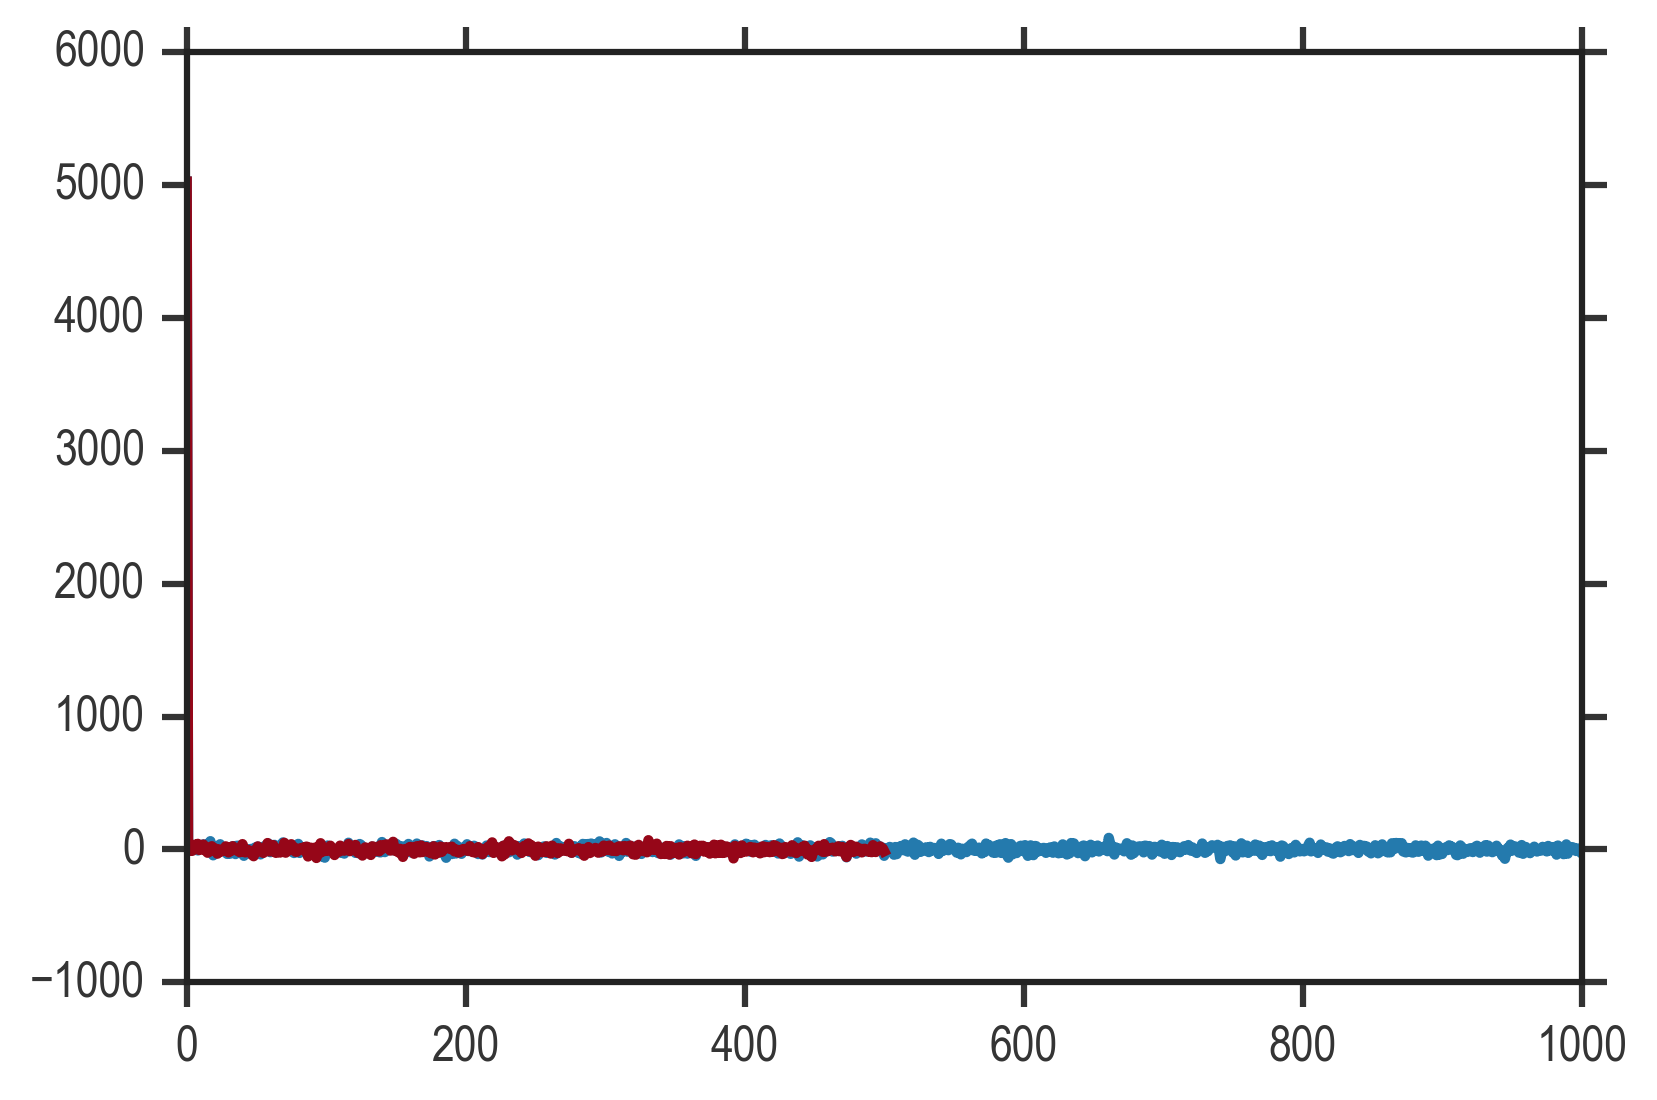

In [855]:
plt.plot(sp1n)
plt.plot(sp1)

/Users/lmcintosh/Library/Python/3.5/lib/python/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


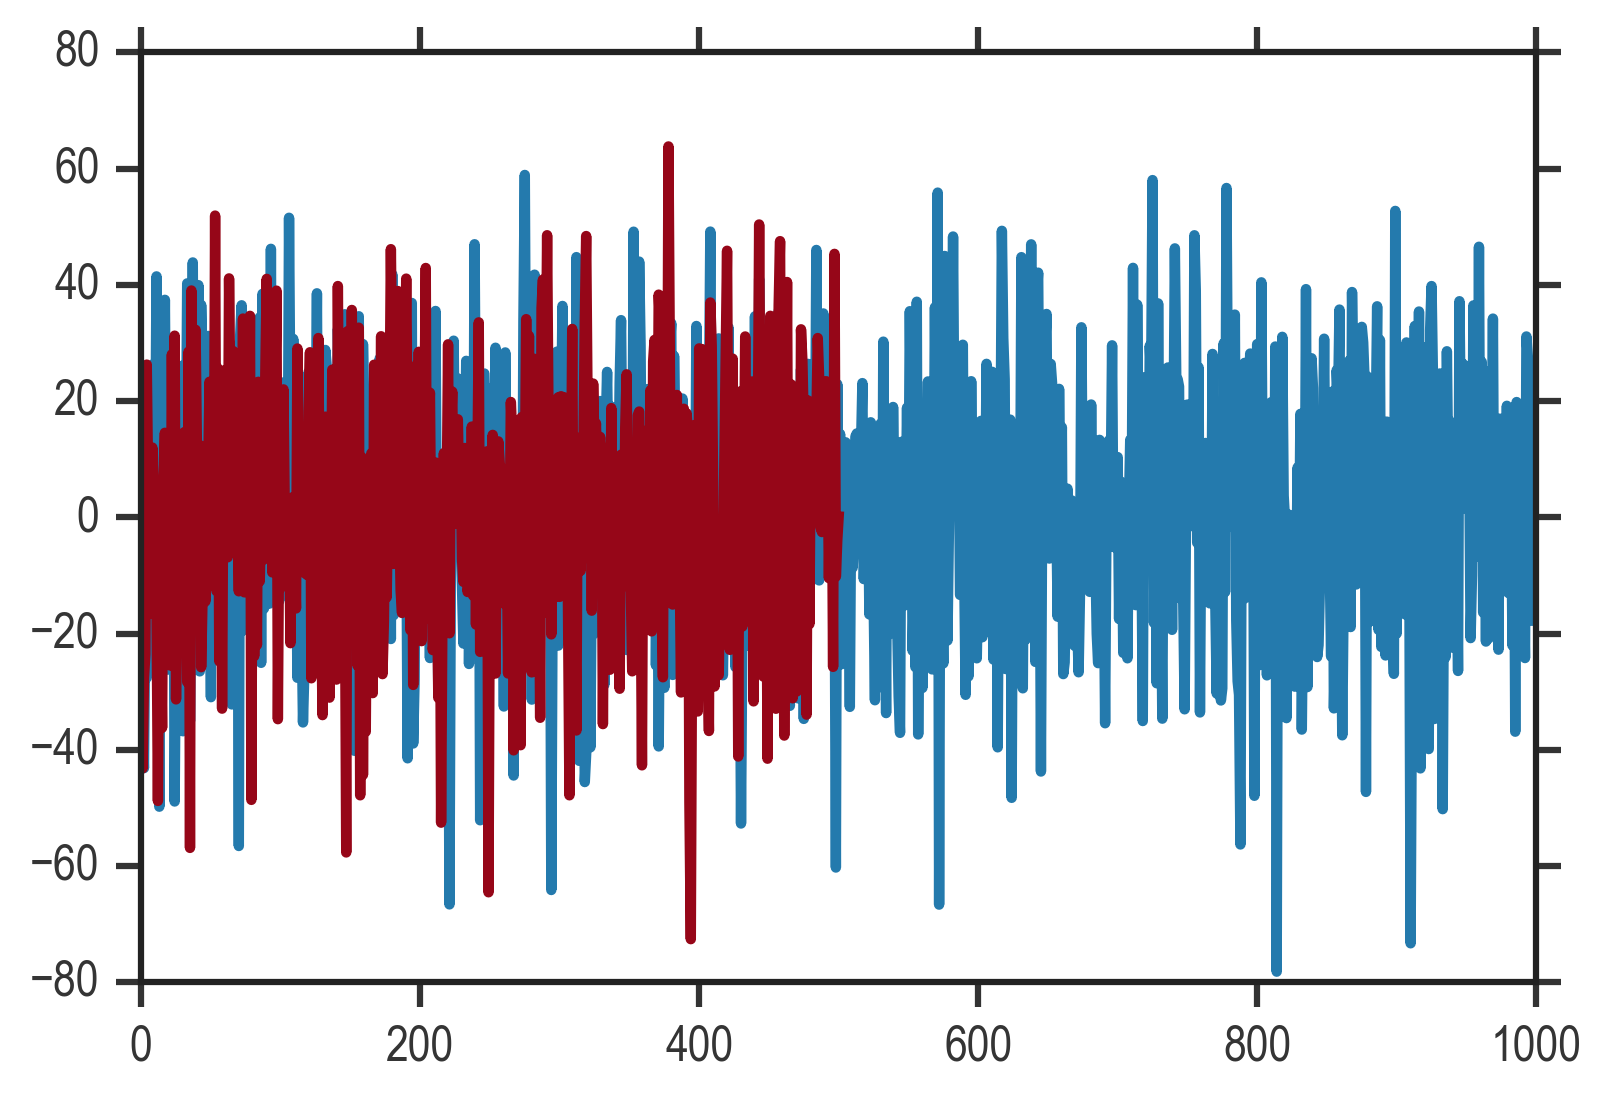

In [860]:
plt.plot(sp2n)
plt.plot(sp2)

In [869]:
ret = sp1 * sp2
retn = sp1n * sp2n
ret_abs = abs(sp1) * abs(sp2)
retn_abs = abs(sp1n) * abs(sp2n)

/Users/lmcintosh/Library/Python/3.5/lib/python/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


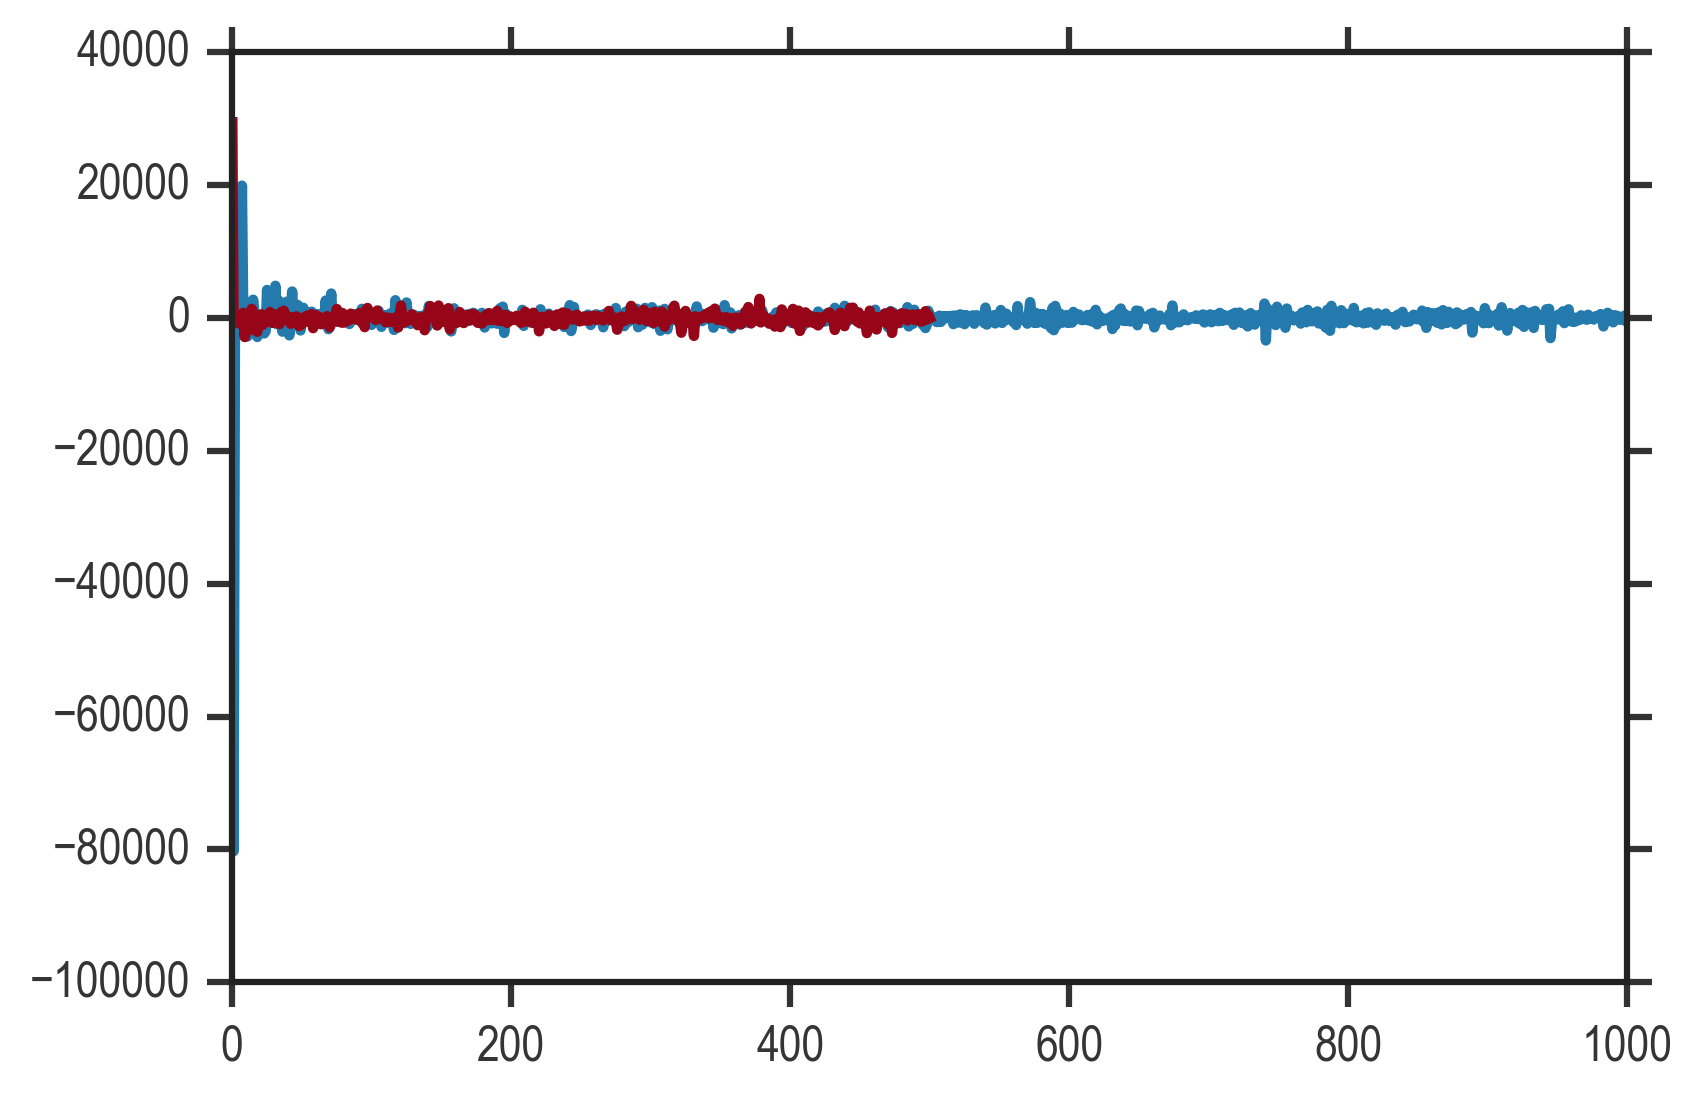

In [870]:
plt.plot(retn)
plt.plot(ret)

In [871]:
blah = np.fft.irfft(ret)
blahn = np.fft.irfftn(retn)
blah_abs = np.fft.irfft(ret_abs)
blahn_abs = np.fft.irfftn(retn_abs)

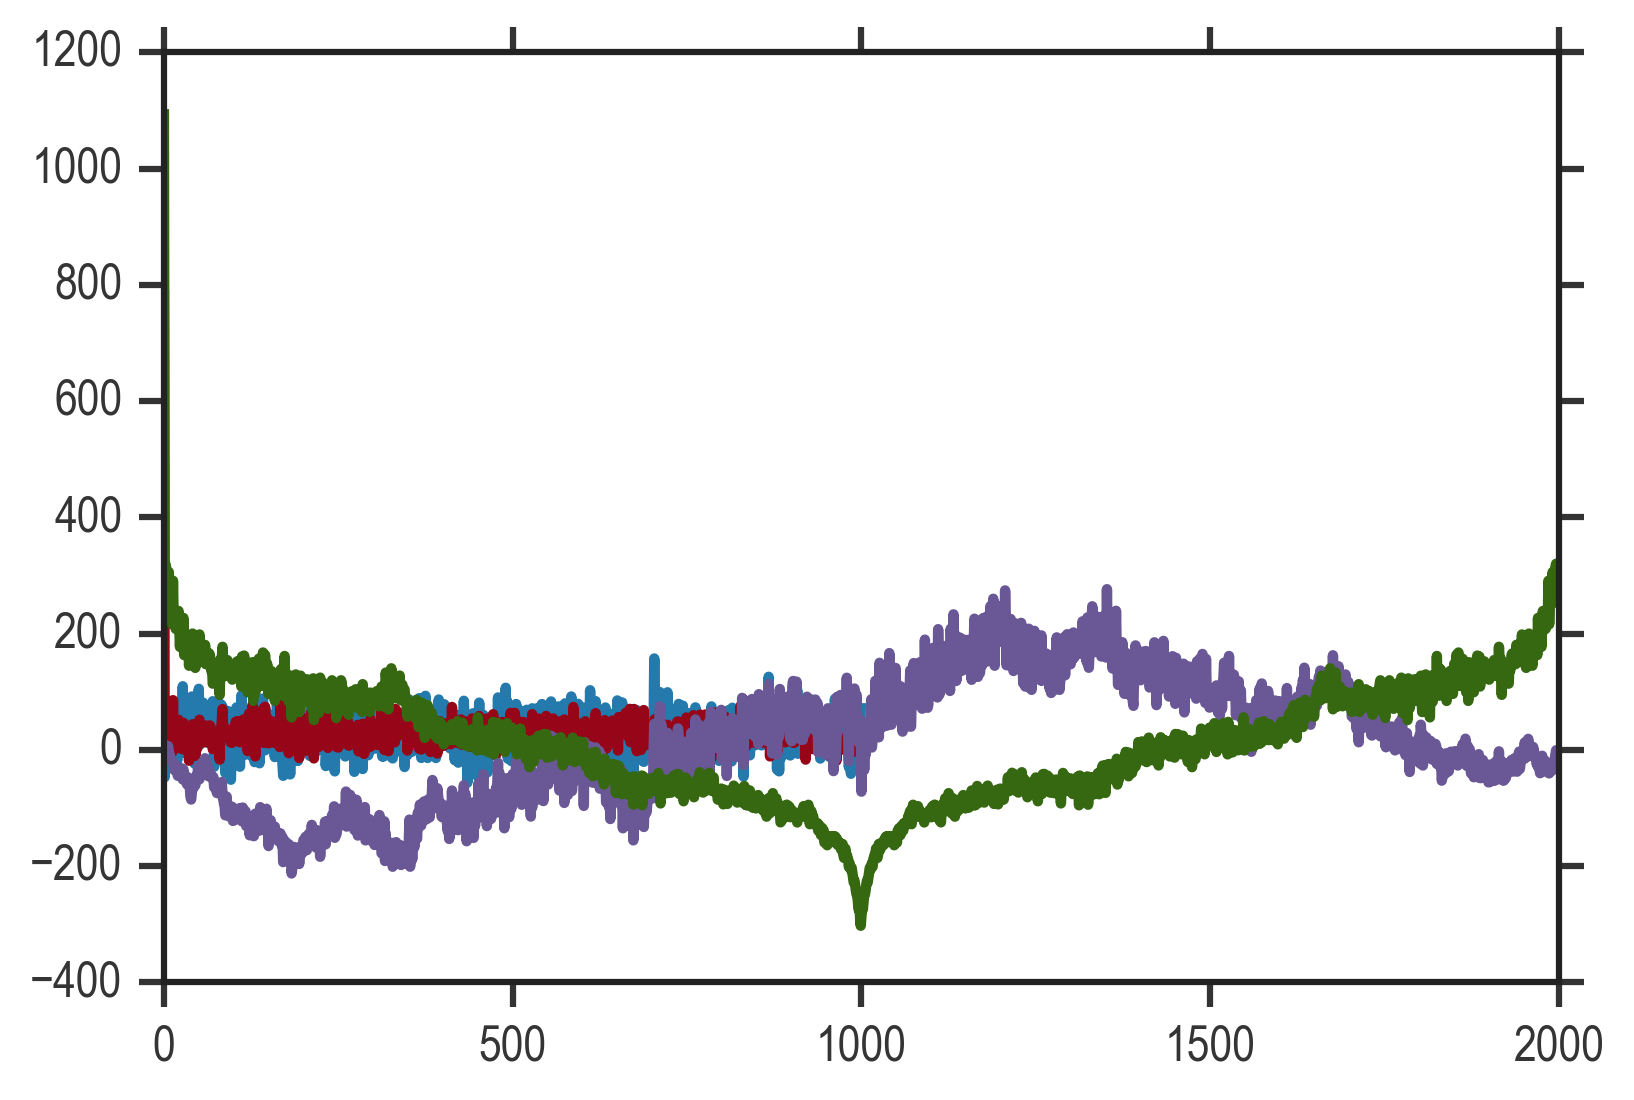

In [872]:
plt.plot(blah)
plt.plot(blah_abs)
plt.plot(blahn)
plt.plot(blahn_abs)

In [873]:
np.var(blah)

868.38875343884388

In [874]:
np.var(blah_abs)

868.38875343884388

In [875]:
np.var(blahn)

11032.357733648036

In [876]:
np.var(blahn_abs)

11032.367383061925

In [877]:
? np.fft.rfftn

In [878]:
c = abs(np.fft.rfft(test_x, n=len(test_x)+len(test_filt)-1)) * abs(np.fft.rfft(test_filt, n=len(test_x)+len(test_filt)-1))

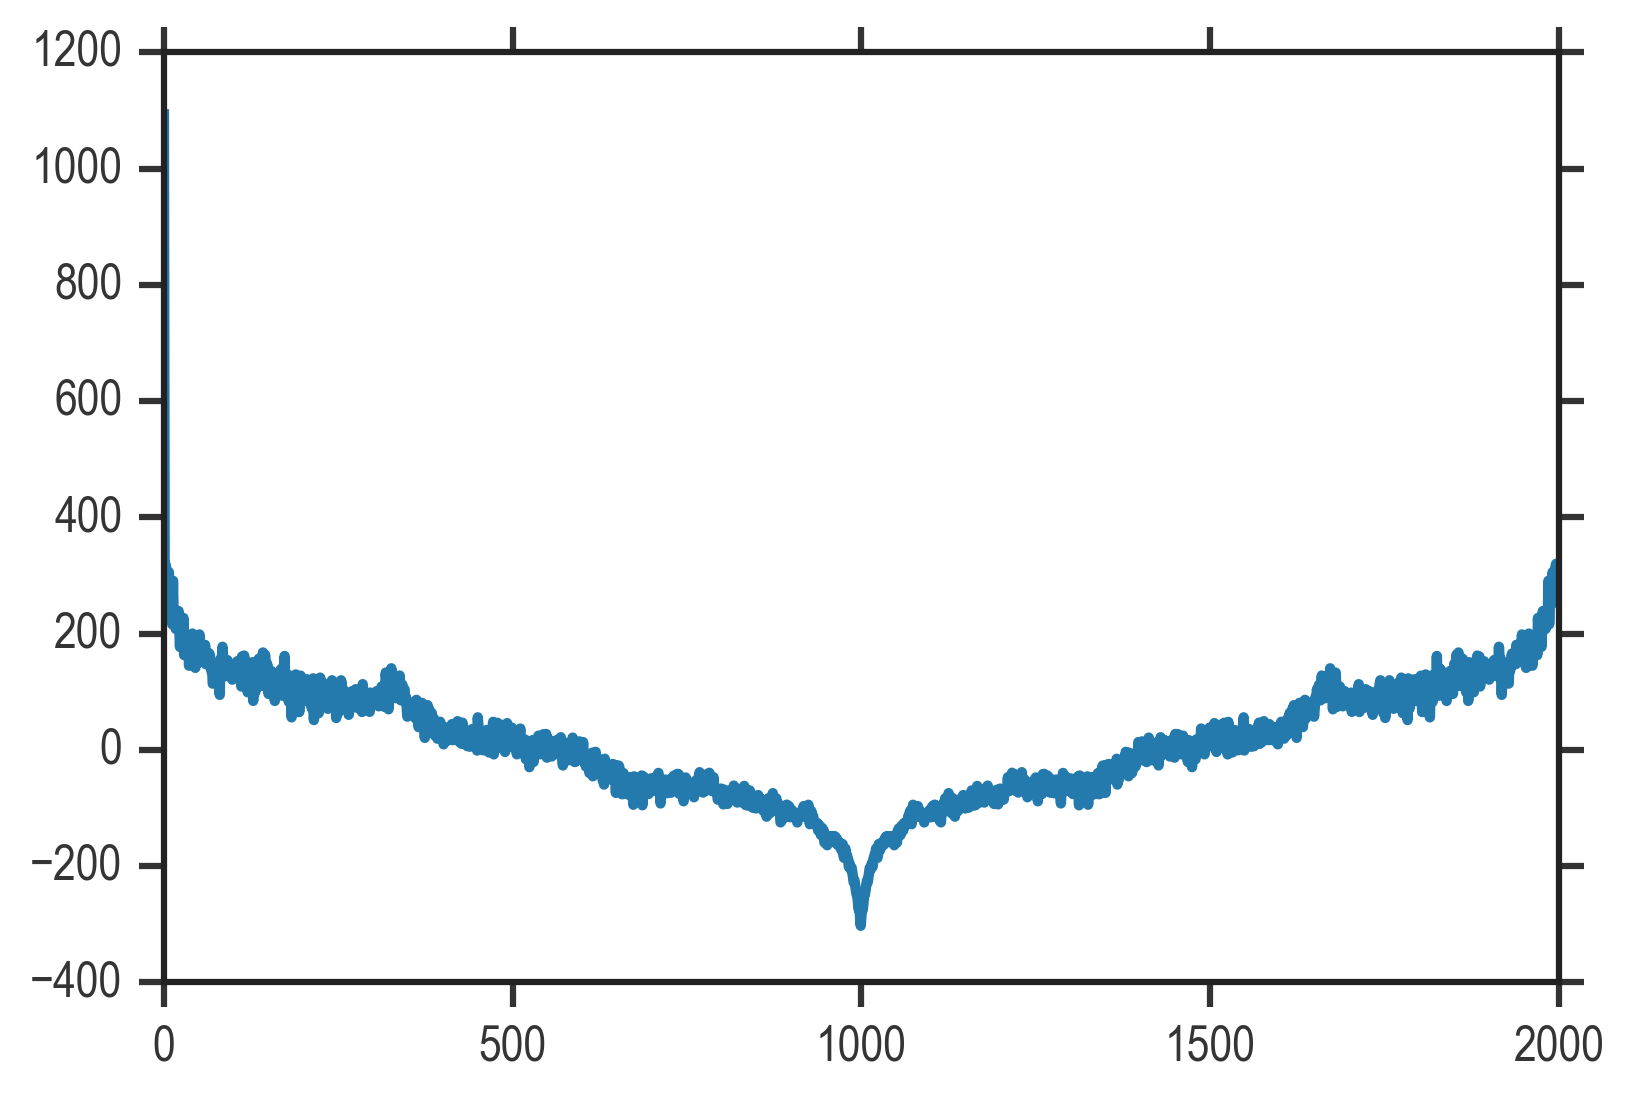

In [879]:
plt.plot(np.fft.irfft(c))

In [1008]:
N = len(average_spacing)
# test_x = 20*np.random.randn(N) + 100
test_x = 0.5*np.fft.irfft(signal) - 10 #np.random.randn(N)
test_input_noise = input_noise*np.random.randn(N)
test_output_noise = output_noise*np.random.randn(N)
# test_filt = np.random.randn(N)
test_filt = 20*ganglion_aligned_rfs['fast_off_adapting'][np.random.choice(len(ganglion_aligned_rfs['fast_off_adapting']))]
test_y = np.convolve(test_x + test_input_noise, test_filt, mode='same') + test_output_noise

In [1009]:
size = len(test_x) + len(test_filt) - 1
2 * np.sum((abs(np.fft.rfft(test_x, n=size)) * abs(np.fft.rfft(test_filt, n=size)))**2) / size

5520750.3396836082

In [1010]:
np.sum(np.convolve(test_x, test_filt, mode='full')**2)

4798074.6979116295

In [1011]:
np.var(np.convolve(test_x, test_filt, mode='full'))

25631.440604651863

In [1012]:
size = len(test_x) + len(test_filt) - 1
2 * np.sum((abs(np.fft.rfft(test_x, n=size)[1:]) * abs(np.fft.rfft(test_filt, n=size)[1:]))**2) / size**2

25631.440604651816

This is great! I finally have an accurate closed form solution for variance in the frequency domain. Let's take a closer look at rfft with the n parameter to see if we fully understand it. I think it's just padding the input with n - len(a) zeros.

In [1030]:
test_x_list = list(test_x)
test_x_list.extend(np.zeros((size - len(test_x)),))
test_x_padded = np.array(test_x_list)
len(test_x_padded)

159

In [1031]:
blah = np.fft.rfft(test_x, n=size)
blah_padded = np.fft.rfft(test_x_padded)

/Users/lmcintosh/Library/Python/3.5/lib/python/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


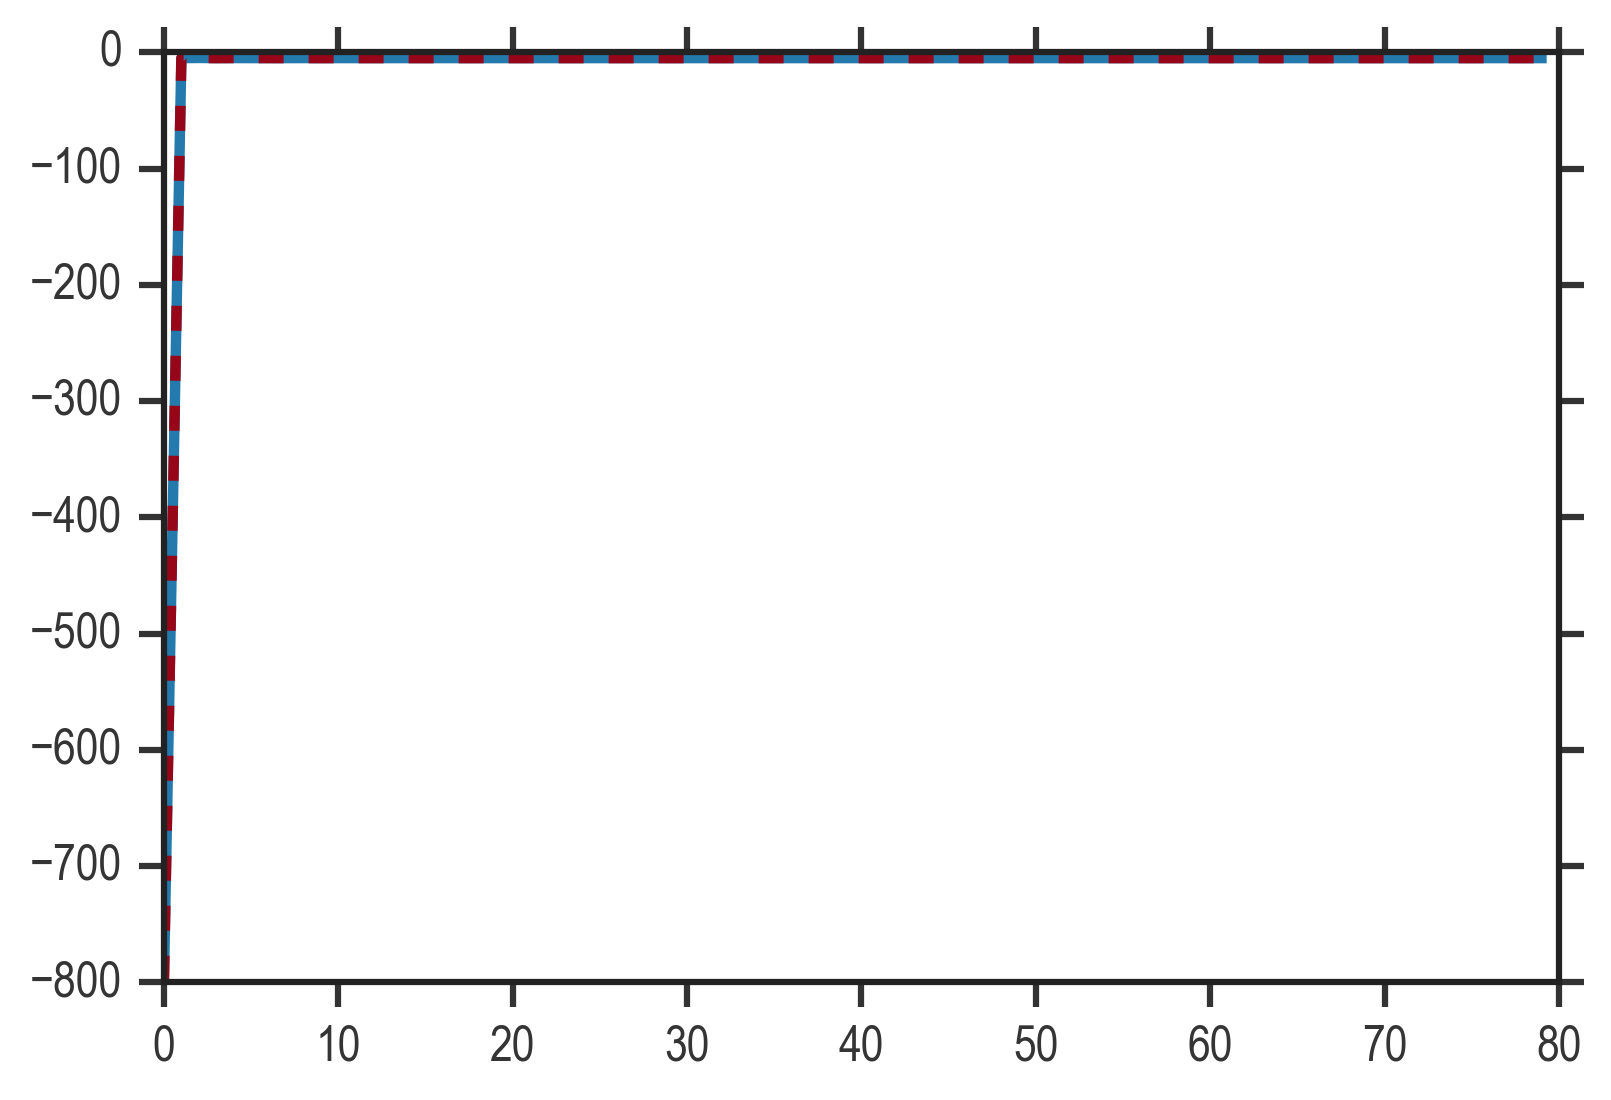

In [1043]:
plt.plot(blah)
plt.plot(blah_padded, '--')

Woohoo! They're exactly the same!